In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [181]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Table of Content A/B Test Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**July 2022**

[Analysis TICKET](https://phabricator.wikimedia.org/T309682)   
[AB test disabled on 2022-06-16](https://phabricator.wikimedia.org/T309683)

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Data exploration](#Data-exploration)
5. [Data analysis](#Data-analysis)  
    5.1 [Clicks on ToC](#Clicks-on-ToC)  
    5.2 [Scrolls back to ToC](#Scrolls-to-ToC)  
    5.3 [Reading time](#Reading-time)  
    5.4 [Clicks on ToC by viewport size](#Clicks-on-ToC-by-viewport-size)


# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team)  is introducing a new Table of Contents (ToC). The goal is to make it easier for readers and editors to gain context and navigate throughout the page without needing to scroll to the top. Please find more information on this change and other feature deployments on the [Table of contents project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Table_of_contents).

An AB test was performed on the early adopter wikis between May 26, 2022 and June 15, 2022 for both logged-in users and anonymous users. This report details the analysis and results for the deployment of the new table of contents on both user groups. 

## Old feature


<img src="Figures/old.png" width="800" height="600" align="center"/>

## New feature

<img src="Figures/new.png" width="800" height="600" align="center"/>

# Purpose

The primary goal of the AB Test was to test the hypothesis that 
1) the group with the new ToC will get more clicks as it is easier for user to reach
2) the group with the new ToC will get less scrolls back to ToC as it is easier for user to navigate 

As part of this analysis, we were also curious about how the new ToC affects the time readers spent on a page.


# Methodology

The AB test was run on a per wiki basis on both logged-in users and anonymous users. The sessions included in the test were randomly assigned to either the control (old ToC) or treatment (new ToC) based on their landing page id.

We compared the total numbers of clicks, the total numbers of scrolls, the average reading time (second/kilobyte) between control and treatment groups. We also reviewed the difference in percentage between the treatment group and the control group. The logged-in user group and anonymous user group are analyzed separately. 

We also ran Hierarchical Generalized Linear Modeling on session based data to determine if the difference is statistically significant.

# Data exploration
June 9, 2022

## Check total enrollment  



In [7]:
query <- "
select wiki, TO_DATE(meta.dt) AS date_time,`group` AS test_group, count(1) AS pv,
count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE year=2022 AND month IN (4, 5,6)
AND experiment_name='skin-vector-toc-experiment'
GROUP BY wiki, TO_DATE(meta.dt),`group`
ORDER BY wiki, date_time, `group`
LIMIT 100000
"

In [8]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [13]:
df$date_time <- as.Date(df$date_time)

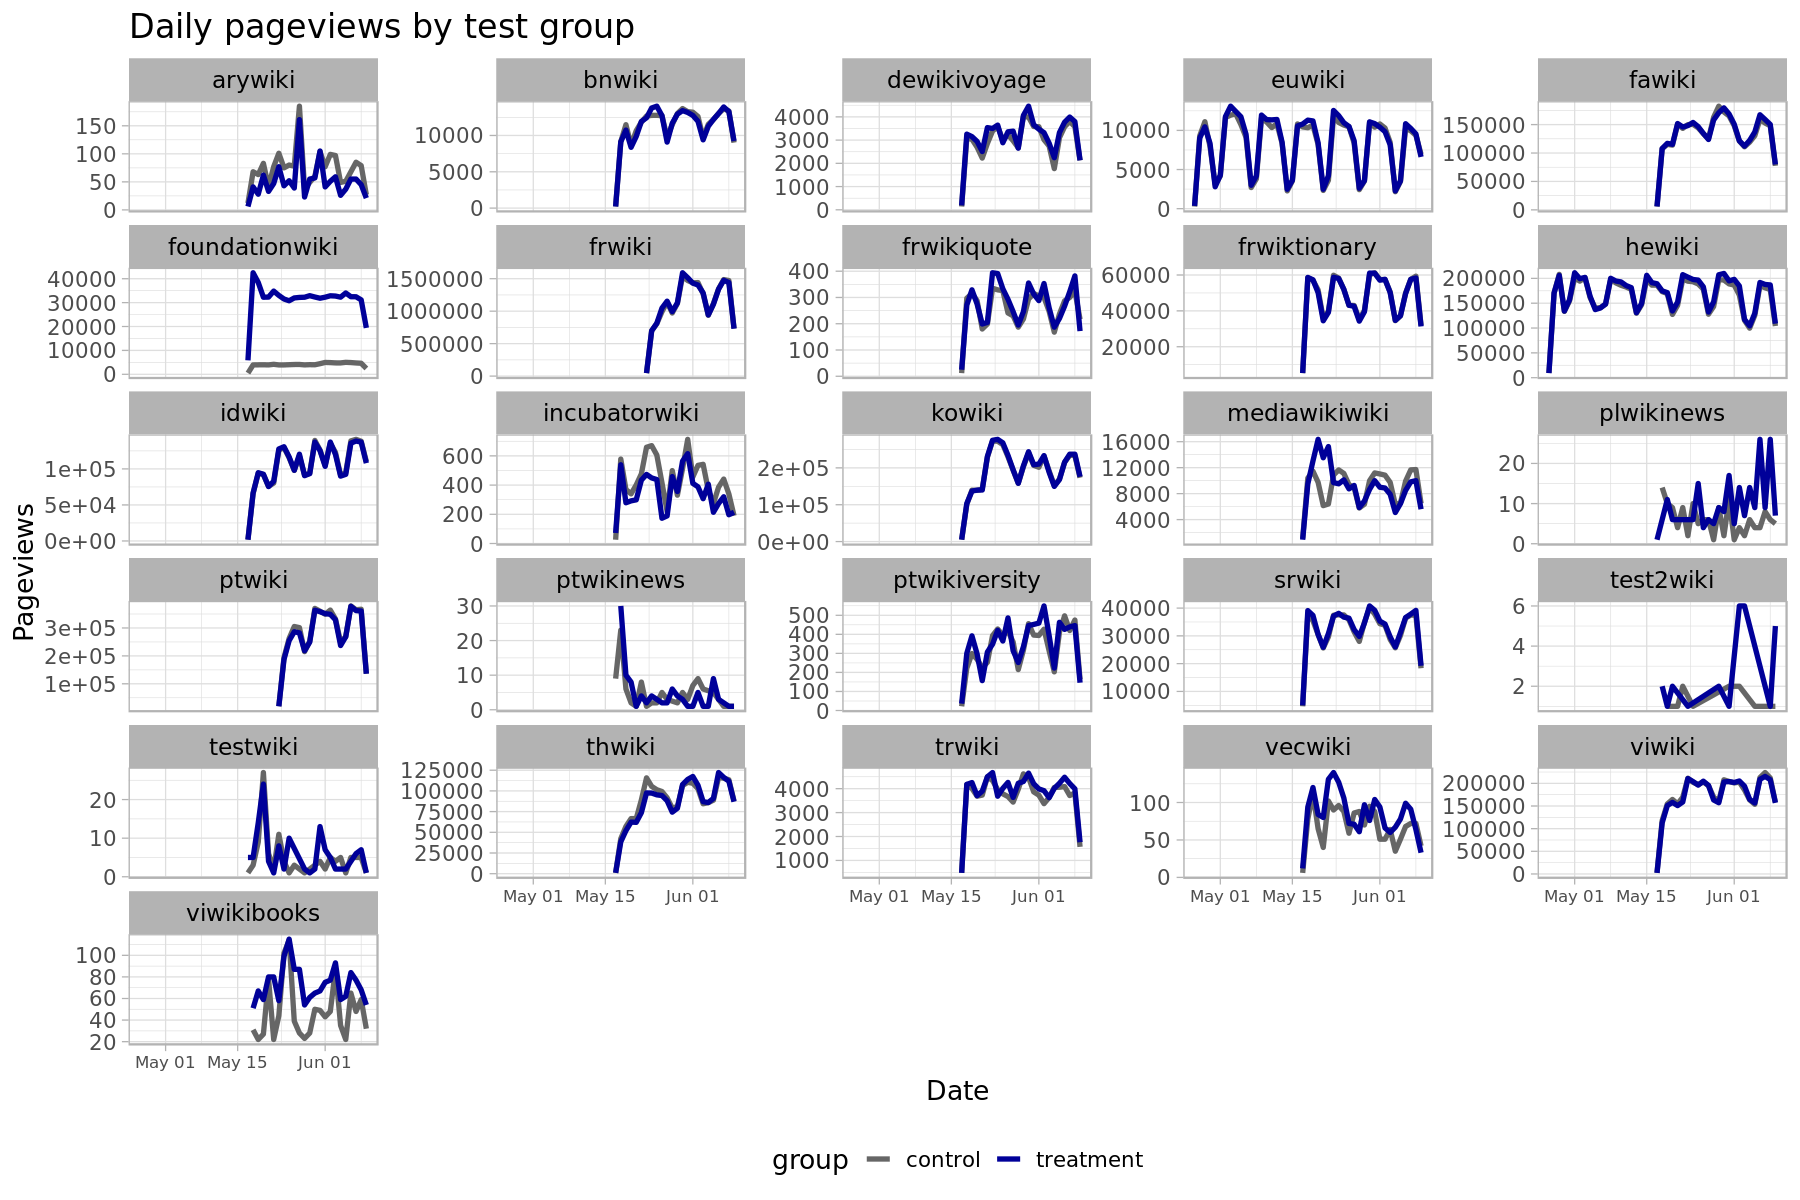

In [16]:
g_pv <- ggplot(data=df, 
                                mapping=aes(x=date_time, y=pv, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily pageviews by test group',
     x = 'Date',
     y = 'Pageviews') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_pv

In [15]:
head(df_pv)

wiki    domain                 test_group total_pv
1 arywiki ary.wikipedia.org      control    1715    
2 arywiki ary.wikipedia.org      treatment  1101    
3 arywiki ary.wikipedia.shisu.cf control       1    
4 bnwiki  bn.wikipedia.ahau.cf   control       3    
5 bnwiki  bn.wikipedia.ahau.cf   treatment     2    
6 bnwiki  bn.wikipedia.ahmu.cf   control       1

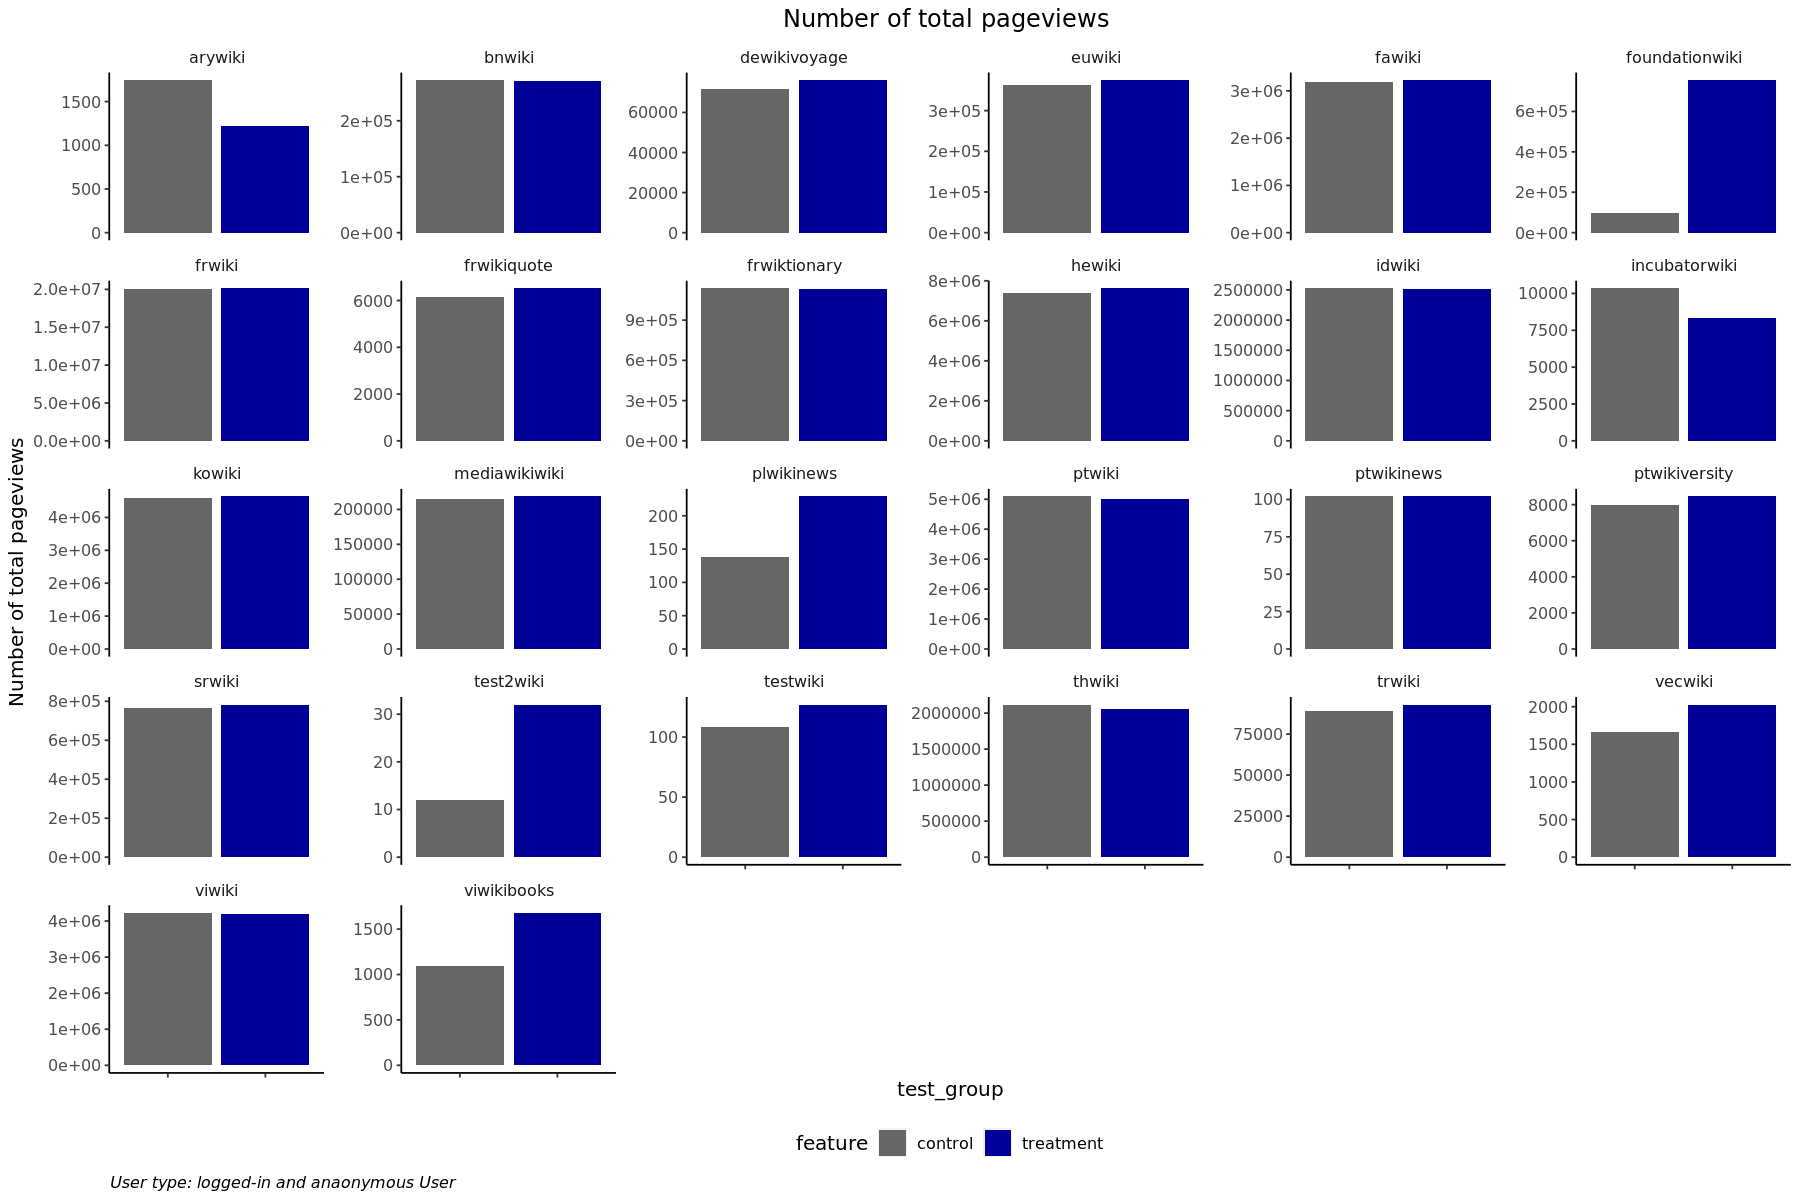

In [18]:
barchart_pv_overall  <- df  %>%
        group_by(wiki, test_group) %>% 
        summarize(total_pv=sum(pv), .groups='drop') %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total pageviews" ,
             title = "Number of total pageviews " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pv_overall

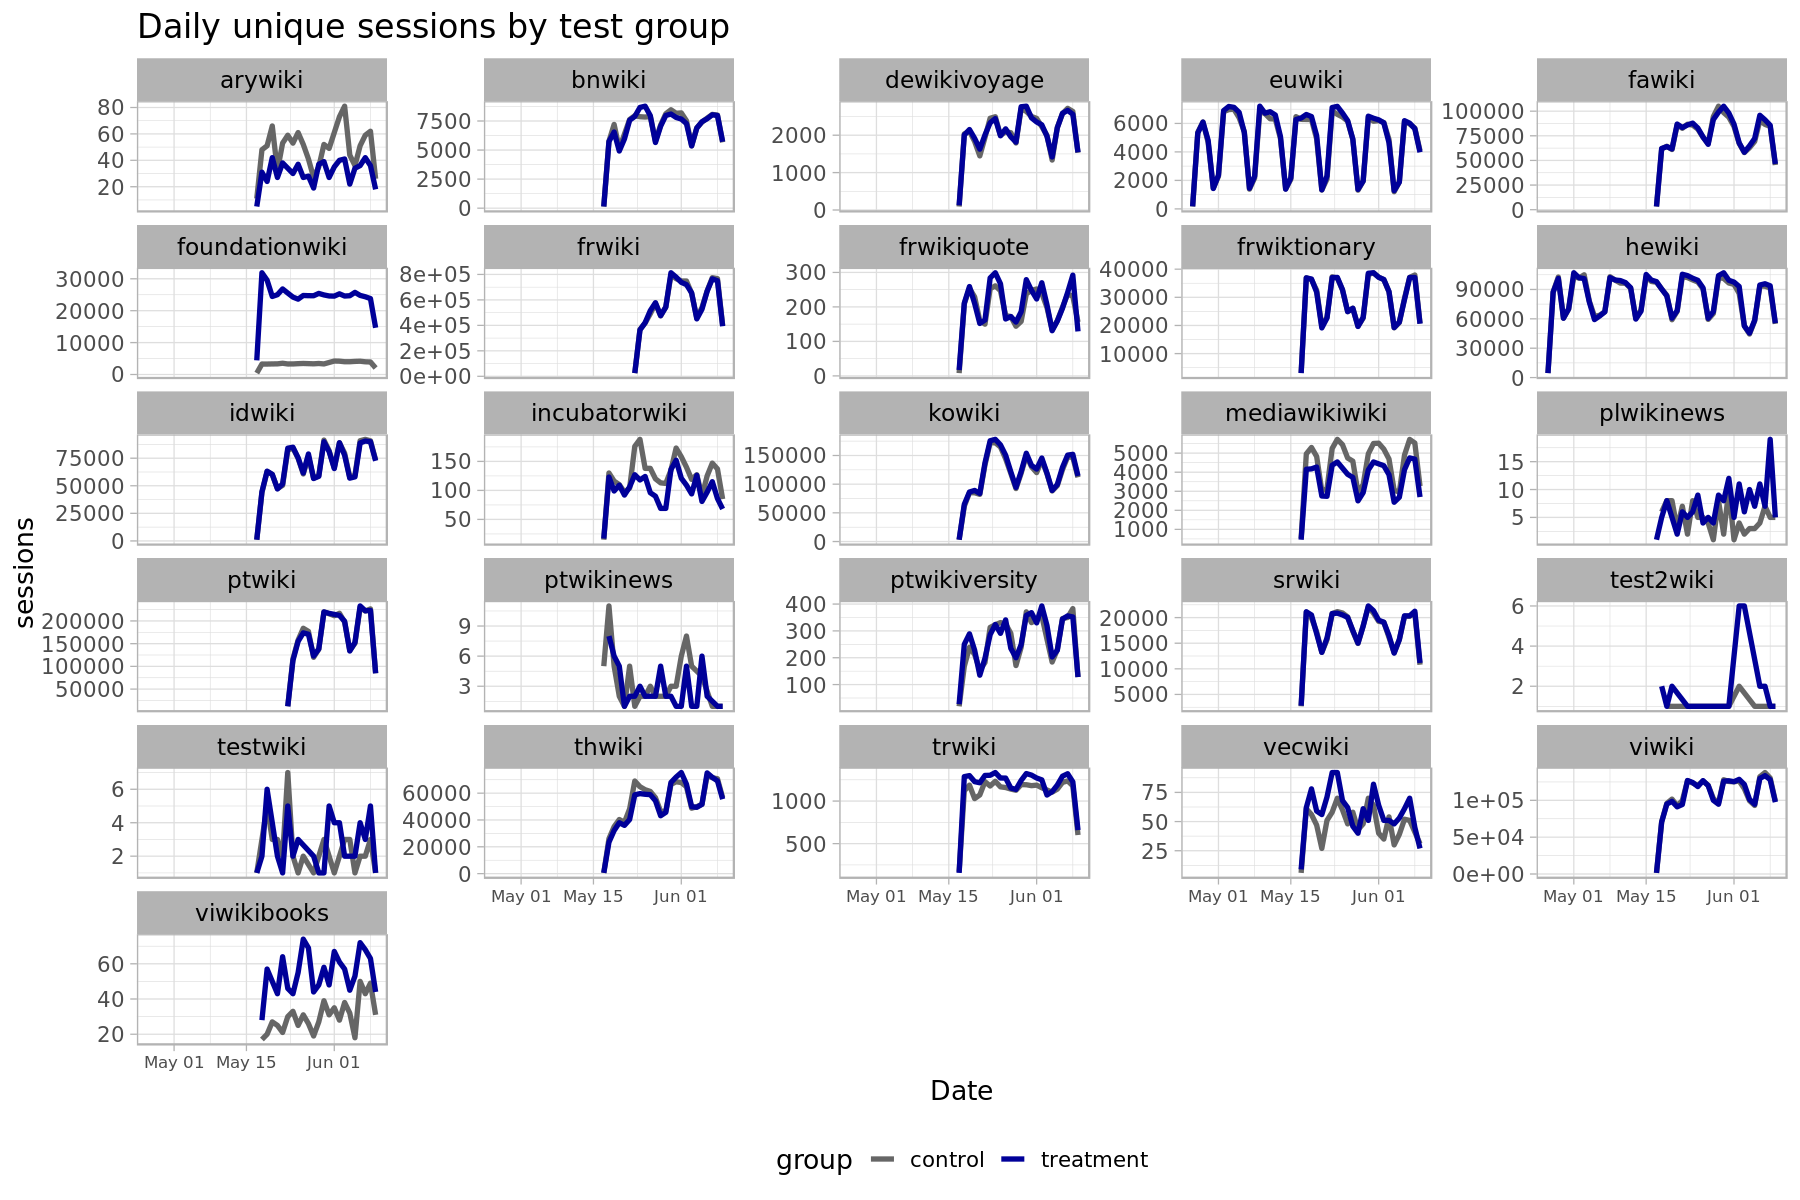

In [20]:
g_s <- ggplot(data=df, 
                                mapping=aes(x=date_time, y=sessions, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily unique sessions by test group',
     x = 'Date',
     y = 'sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_s

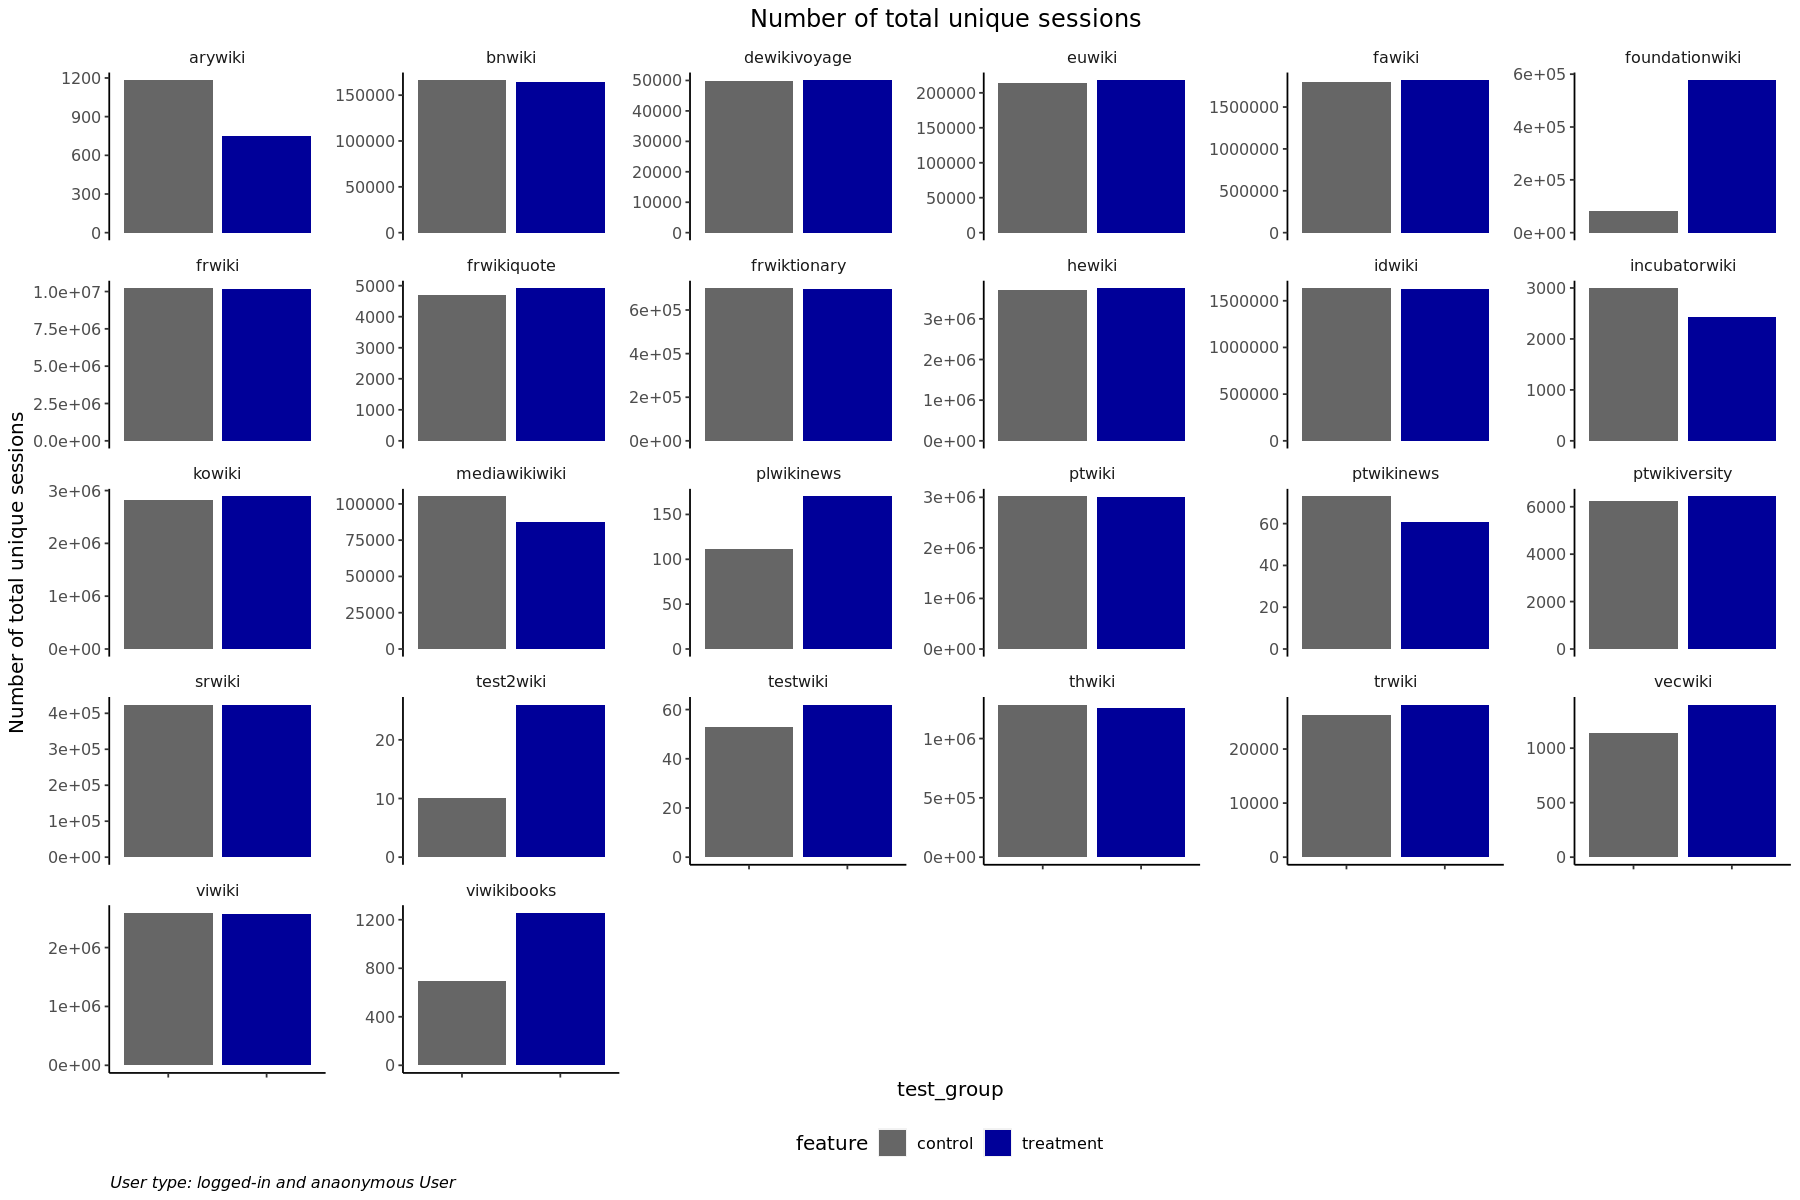

In [21]:
barchart_sessions_overall  <- df  %>%
        group_by(wiki, test_group) %>% 
        summarize(total_sessions=sum(sessions), .groups='drop') %>%
        ggplot(aes(x = test_group, y= total_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total unique sessions" ,
             title = "Number of total unique sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall

__Note:__  


5 wikis with low traffic:  plwikinews, ptwikinews, vecwiki, arywiki, viwikibook  
Foundationwiki has low traffic in the control group.


## Check sessions are assigned in both groups

In [131]:
query_check_duplicate <- "
WITH t_duplicate AS
(SELECT  web_session_id, wiki, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
GROUP BY  web_session_id, wiki
HAVING groups>1
)
SELECT wiki, count(web_session_id) AS dup_sessions
FROM t_duplicate
GROUP BY wiki
"

In [132]:
df_duplicate <- wmfdata::query_hive(query_check_duplicate)

Don't forget to authenticate with Kerberos using kinit



In [133]:
df_duplicate

wiki           dup_sessions
1  arywiki             41     
2  bnwiki           31209     
3  dewikivoyage      3763     
4  euwiki           22606     
5  fawiki          478563     
6  foundationwiki    5851     
7  frwiki         3245573     
8  frwikiquote        428     
9  frwiktionary     89800     
10 hewiki          529285     
11 idwiki          305725     
12 incubatorwiki      591     
13 kowiki          527008     
14 mediawikiwiki    23291     
15 plwikinews          16     
16 ptwiki          751847     
17 ptwikinews           5     
18 ptwikiversity      173     
19 srwiki           90155     
20 thwiki          246259     
21 trwiki            8579     
22 vecwiki             96     
23 viwiki          539556     
24 viwikibooks         30

In [137]:
sum(df_duplicate[, 'dup_sessions'])

[1] 6900450

__Note:__


All sessions assigned to both treatment group and control group need to be excluded in analysis

In [135]:
query_total_sessions <- "
select wiki, `group` AS test_group, count(1) AS pv,
count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE year=2022 AND month IN (5,6)
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND experiment_name='skin-vector-toc-experiment'
GROUP BY wiki, `group`
ORDER BY wiki,  `group`
LIMIT 100000
"

In [136]:
df_total_sessions <- wmfdata::query_hive(query_total_sessions)

Don't forget to authenticate with Kerberos using kinit



In [138]:
df_total_sessions <- df_total_sessions %>%
  group_by(test_group) %>%
  summarize(total_sessions=sum(sessions), total_pv=sum(pv))

In [139]:
df_total_sessions

test_group total_sessions total_pv
1 control    28016822       55011276
2 treatment  28471190       55656417

In [140]:
sum(df_total_sessions[, 'total_sessions'])

[1] 56488012

In [251]:
6900450/(56488012-6900450)

[1] 0.1391569

__Note:__. 
14% of sessions were duplicatedly assigned to both control and treatment group. Will be excluded in following analysis.

## Check bucketing of non-duplicated sessions

In [4]:
query_non_duplicate <- "
WITH t_ab_no_duplicate AS
(SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
GROUP BY  web_session_id, wiki,  meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN t_ab_no_duplicate AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  and t1.year=2022 and t1.month IN (5,6) 
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
" 

In [5]:
df_ab <- wmfdata::query_hive(query_non_duplicate)

Don't forget to authenticate with Kerberos using kinit



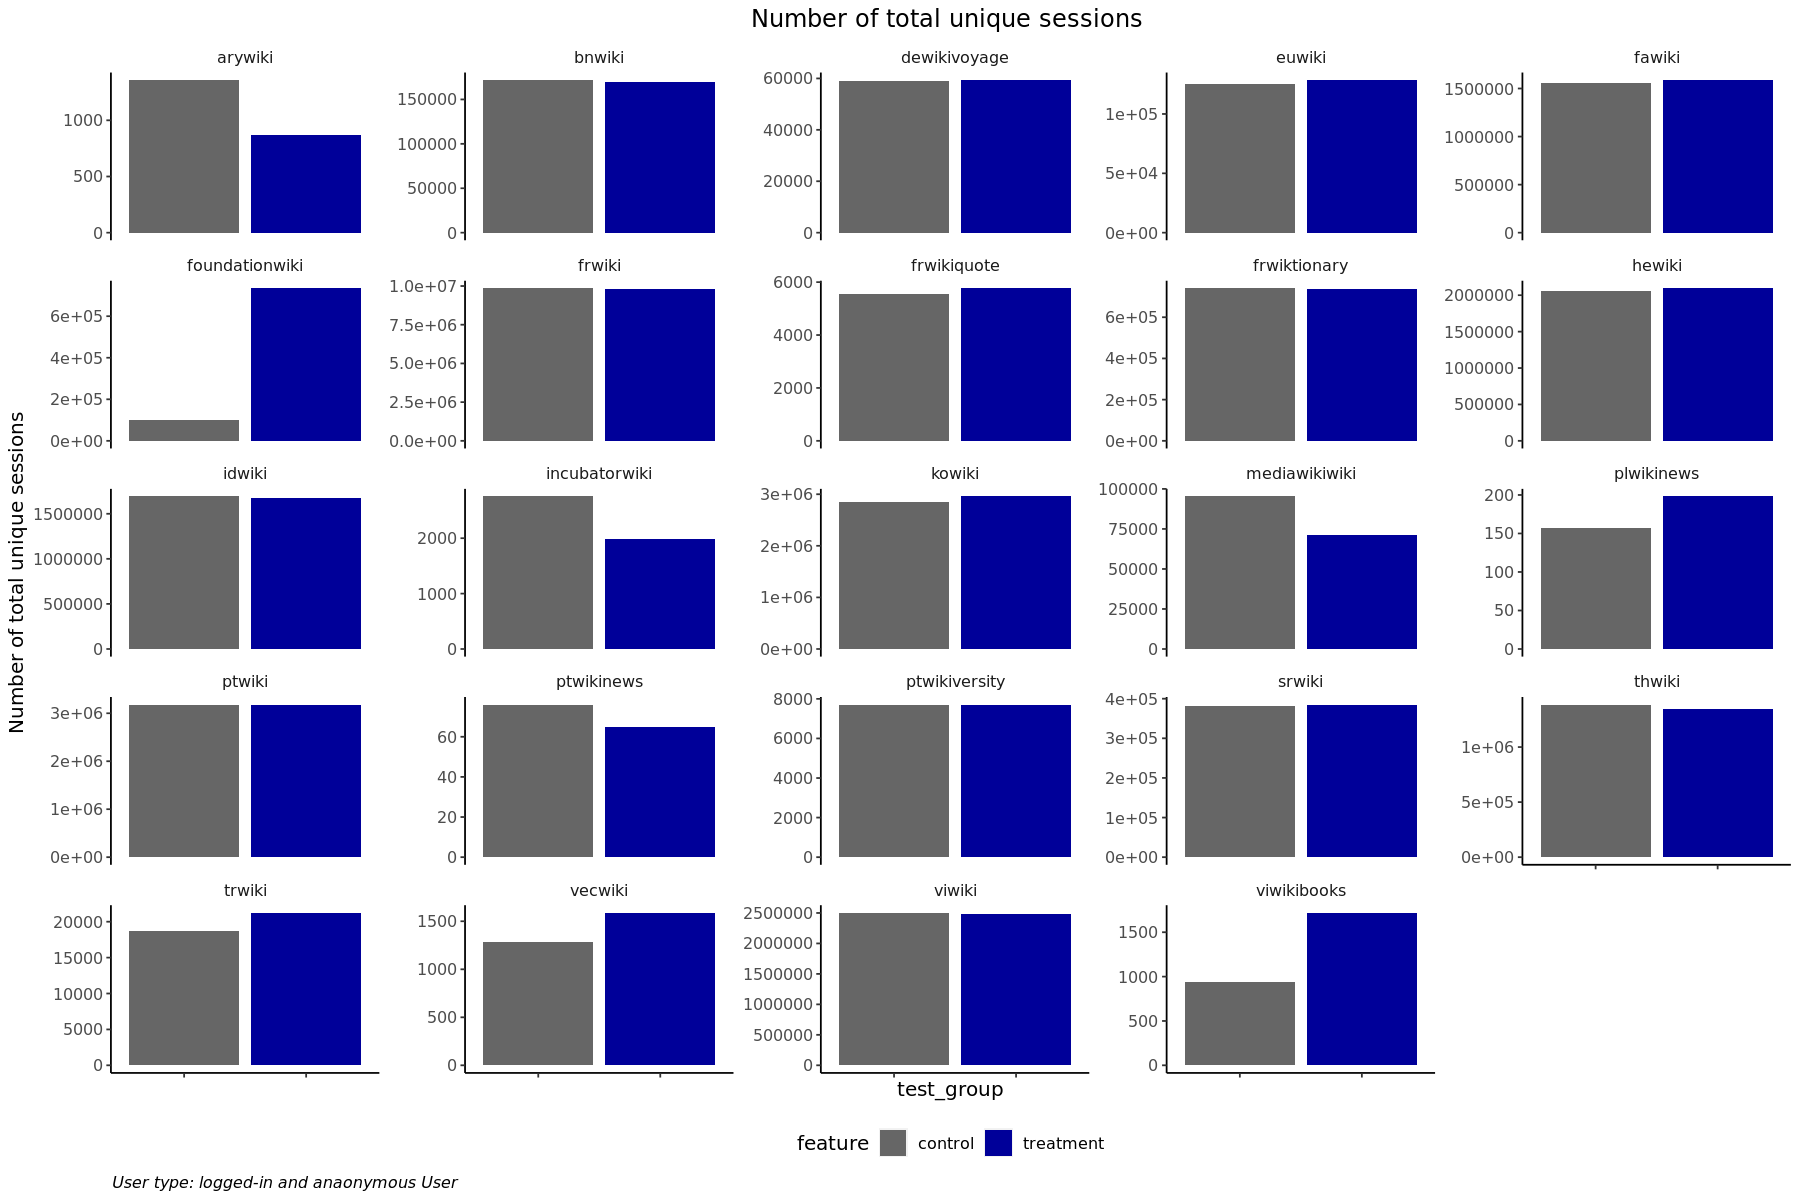

In [7]:
barchart_sessions_overall  <- df_ab  %>%
        group_by(wiki, test_group) %>% 
        summarize(sessions=n_distinct(web_session_id), .groups='drop') %>%
        ggplot(aes(x = test_group, y= sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total unique sessions" ,
             title = "Number of total unique sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall

__Note:__  


8 wikis have unbalanced distribution on unique session: arywiki, foundationwiki, incubatorwiki, mediawiki, 
plwikinews, ptwikinews, vecwiki, viwikibook  .  


In [11]:
query_non_duplicate_pv <- "
WITH t_ab_no_duplicate AS
(SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
GROUP BY  web_session_id, wiki,  meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT 
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 COUNT(1) AS total_pv 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN t_ab_no_duplicate AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  and t1.year=2022 and t1.month IN (5,6) 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
GROUP BY t1.wiki,t1.meta.domain, t1.`group`
" 

In [12]:
df_pv <- wmfdata::query_hive(query_non_duplicate_pv)

Don't forget to authenticate with Kerberos using kinit



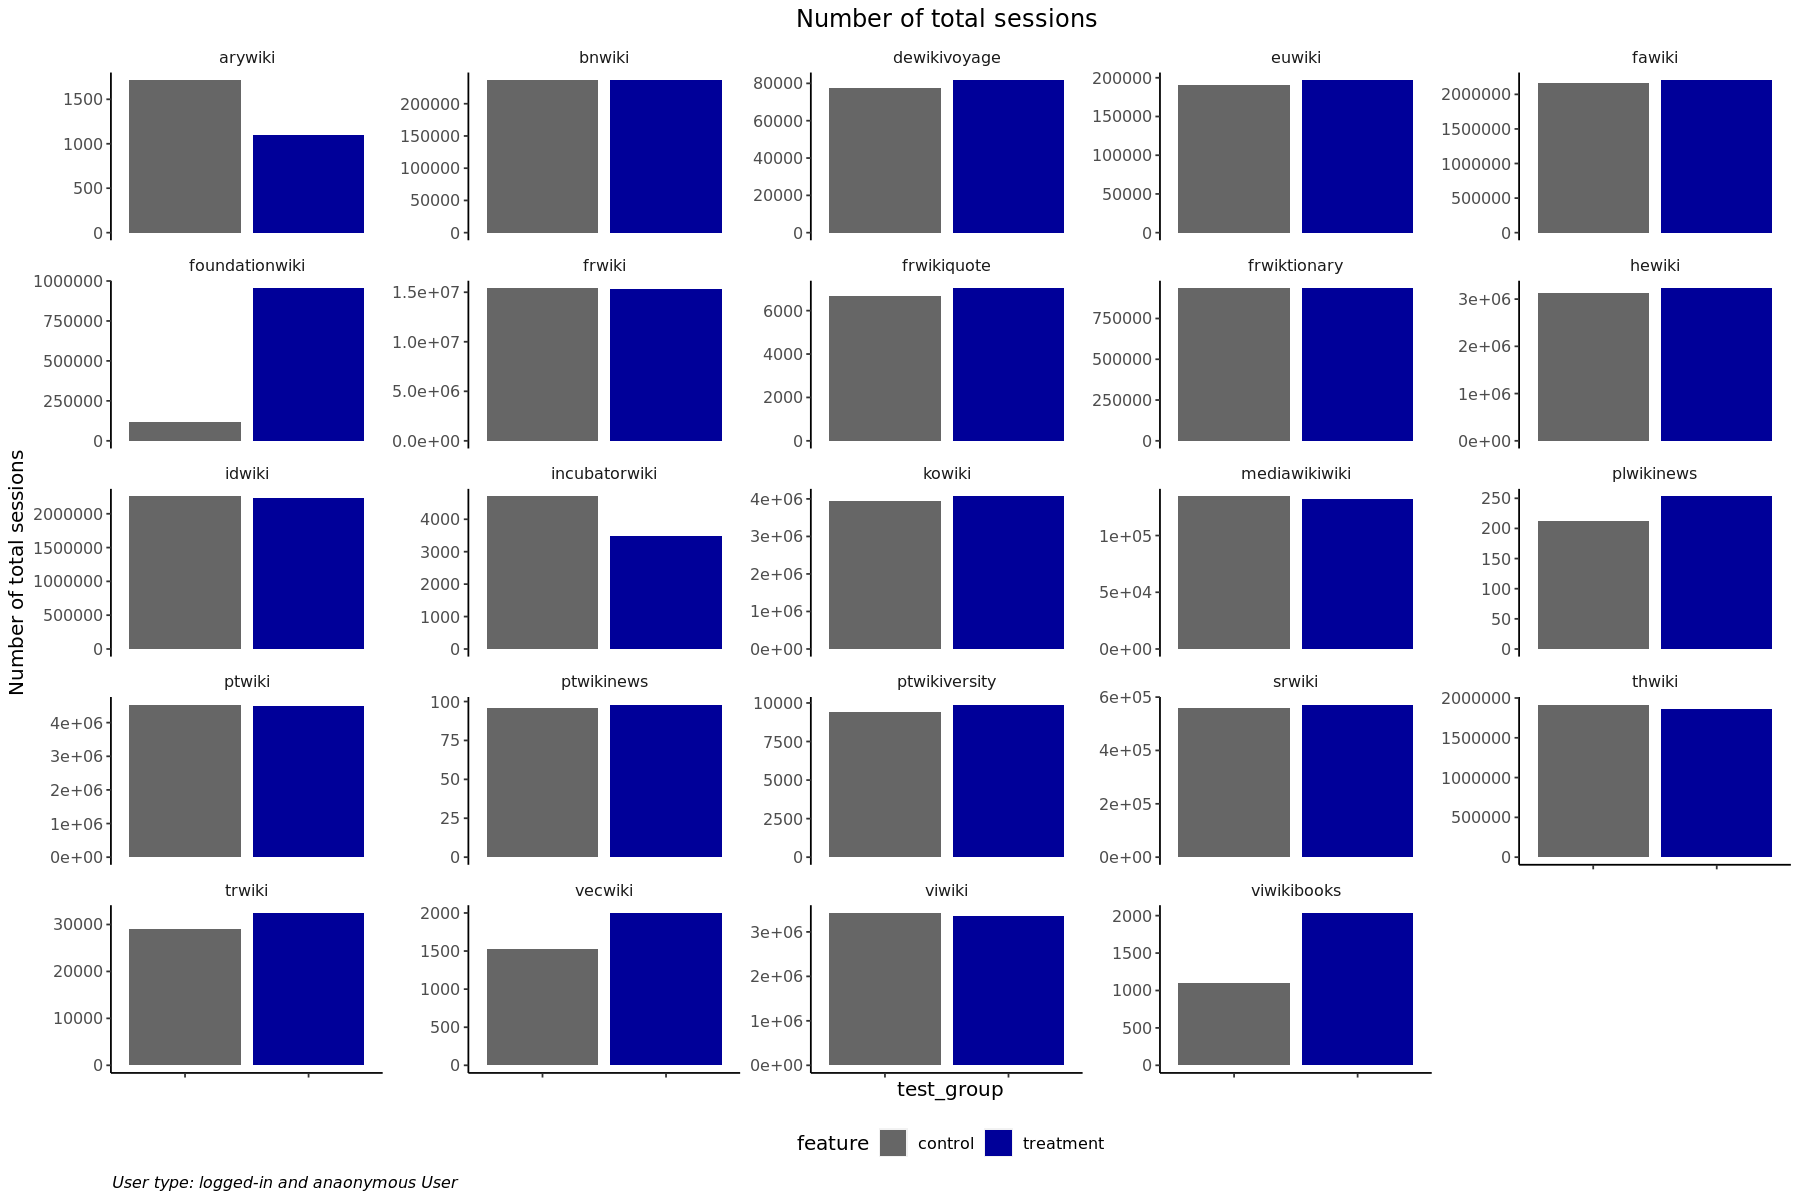

In [13]:
barchart_sessions_overall_2  <- df_pv  %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total sessions" ,
             title = "Number of total sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall_2

__Note:__. 


5 wikis have unbalanced distribution on total pageviews: arywiki, foundationwiki, incubatorwiki,  
 vecwiki, viwikibook  .  


# Data analysis


## Clicks on ToC
__Test question: Is the new table of contents is used more frequently than the previous table of contents__


Clicks on ToC was tracked in `event.DesktopWebUIActionsTracking` schema.
- Clicks on old table of contents are tracked by the ui.toc event.
- Clicks on new table of contents are tracked by the ui.sidebar-toc event.   


__Important note__   
We show the old table of contents in the treatment bucket if the window is small (<1000px) for a better user experince on smaller viewport devices. The sessions with small viewport ( <1000px ) should be excluded in AB test analysis. 


In [161]:
query_click <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022  
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
AND NOT is_bot
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) AS event_date, 
wiki, event.isanon,  t4.test_group, 
event.name AS event_name, 
event.viewportSizeBucket AS view_size,
count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t3.year=2022 and t3.month IN (5,6)
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t4.session_dt <= t3.meta.dt
AND event.name IN ( 'ui.toc', 'ui.sidebar-toc')
AND event.action='click' AND event.skinversion=2 
GROUP BY t3.year, t3.month,t3.day, t3.wiki, event.isanon, t4.test_group, event.name , event.viewportSizeBucket
"

In [162]:
df_clicks <- wmfdata::query_hive(query_click)

Don't forget to authenticate with Kerberos using kinit



In [163]:
df_clicks$event_date <- as.Date(df_clicks$event_date)

In [168]:
df_clicks

event_date wiki           isanon test_group event_name     view_size    
1    2022-05-26 bnwiki         false  control    ui.toc         1200px-2000px
2    2022-05-26 bnwiki         true   control    ui.toc         1000px-1199px
3    2022-05-26 bnwiki         true   control    ui.toc         1200px-2000px
4    2022-05-26 dewikivoyage   false  control    ui.toc         1200px-2000px
5    2022-05-26 dewikivoyage   false  treatment  ui.sidebar-toc 1200px-2000px
6    2022-05-26 dewikivoyage   true   control    ui.toc         1000px-1199px
7    2022-05-26 dewikivoyage   true   control    ui.toc         1200px-2000px
8    2022-05-26 dewikivoyage   true   control    ui.toc         720px-999px  
9    2022-05-26 dewikivoyage   true   control    ui.toc         >2000px      
10   2022-05-26 dewikivoyage   true   treatment  ui.sidebar-toc 1000px-1199px
11   2022-05-26 dewikivoyage   true   treatment  ui.sidebar-toc 1200px-2000px
12   2022-05-26 euwiki         false  control    ui.toc         1200px-2000px
13   2022-05-26 euwiki         true   control    ui.toc         1000px-1199px
14   2022-05-26 euwiki         true   control    ui.toc         1200px-2000px
15   2022-05-26 fawiki         false  control    ui.toc         1000px-1199px
16   2022-05-26 fawiki         false  control    ui.toc         1200px-2000px
17   2022-05-26 fawiki         false  control    ui.toc         720px-999px  
18   2022-05-26 fawiki         true   control    ui.toc         1000px-1199px
19   2022-05-26 fawiki         true   control    ui.toc         1200px-2000px
20   2022-05-26 fawiki         true   control    ui.toc         320px-719px  
21   2022-05-26 fawiki         true   control    ui.toc         720px-999px  
22   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 1000px-1199px
23   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 1200px-2000px
24   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 720px-999px  
25   2022-05-26 fawiki         true   treatment  ui.toc         1000px-1199px
26   2022-05-26 foundationwiki false  control    ui.toc         1200px-2000px
27   2022-05-26 foundationwiki true   control    ui.toc         1000px-1199px
28   2022-05-26 foundationwiki true   control    ui.toc         1200px-2000px
29   2022-05-26 foundationwiki true   control    ui.toc         320px-719px  
30   2022-05-26 foundationwiki true   control    ui.toc         720px-999px  
⋮    ⋮          ⋮              ⋮      ⋮          ⋮              ⋮            
3762 2022-06-15 thwiki         true   control    ui.toc         1000px-1199px
3763 2022-06-15 thwiki         true   control    ui.toc         1200px-2000px
3764 2022-06-15 thwiki         true   control    ui.toc         320px-719px  
3765 2022-06-15 thwiki         true   control    ui.toc         720px-999px  
3766 2022-06-15 thwiki         true   control    ui.toc         >2000px      
3767 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 1000px-1199px
3768 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 1200px-2000px
3769 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 720px-999px  
3770 2022-06-15 thwiki         true   treatment  ui.sidebar-toc >2000px      
3771 2022-06-15 thwiki         true   treatment  ui.toc         1200px-2000px
3772 2022-06-15 trwiki         false  control    ui.toc         1000px-1199px
3773 2022-06-15 trwiki         false  control    ui.toc         1200px-2000px
3774 2022-06-15 trwiki         false  treatment  ui.sidebar-toc 1200px-2000px
3775 2022-06-15 trwiki         true   control    ui.toc         1200px-2000px
3776 2022-06-15 trwiki         true   treatment  ui.sidebar-toc 1200px-2000px
3777 2022-06-15 trwiki         true   treatment  ui.toc         1200px-2000px
3778 2022-06-15 trwiki         true   treatment  ui.toc         720px-999px  
3779 2022-06-15 vecwiki        true   control    ui.toc         720px-999px  
3780 2022-06-15 viwiki         false  control    ui.toc         1000px-1199px
3781 2022-06-15 viwiki     

In [169]:
filter(df_clicks, test_group=='treatment' & event_name=='ui.toc' & event_date=='2022-06-15')

event_date wiki         isanon test_group event_name view_size     clicks
1  2022-06-15 bnwiki       true   treatment  ui.toc     1200px-2000px    1  
2  2022-06-15 fawiki       true   treatment  ui.toc     1000px-1199px    2  
3  2022-06-15 fawiki       true   treatment  ui.toc     1200px-2000px    4  
4  2022-06-15 fawiki       true   treatment  ui.toc     320px-719px      1  
5  2022-06-15 frwiki       false  treatment  ui.toc     1000px-1199px    3  
6  2022-06-15 frwiki       false  treatment  ui.toc     1200px-2000px   89  
7  2022-06-15 frwiki       false  treatment  ui.toc     720px-999px      3  
8  2022-06-15 frwiki       false  treatment  ui.toc     <320px           1  
9  2022-06-15 frwiki       false  treatment  ui.toc     >2000px          1  
10 2022-06-15 frwiki       true   treatment  ui.toc     1000px-1199px  224  
11 2022-06-15 frwiki       true   treatment  ui.toc     1200px-2000px 2061  
12 2022-06-15 frwiki       true   treatment  ui.toc     320px-719px     31  
13 2022-06-15 frwiki       true   treatment  ui.toc     720px-999px    103  
14 2022-06-15 frwiki       true   treatment  ui.toc     >2000px         45  
15 2022-06-15 frwiktionary true   treatment  ui.toc     1200px-2000px    1  
16 2022-06-15 ptwiki       false  treatment  ui.toc     1000px-1199px    4  
17 2022-06-15 ptwiki       false  treatment  ui.toc     1200px-2000px   29  
18 2022-06-15 ptwiki       true   treatment  ui.toc     1000px-1199px   28  
19 2022-06-15 ptwiki       true   treatment  ui.toc     1200px-2000px  340  
20 2022-06-15 ptwiki       true   treatment  ui.toc     320px-719px      9  
21 2022-06-15 ptwiki       true   treatment  ui.toc     720px-999px      8  
22 2022-06-15 ptwiki       true   treatment  ui.toc     >2000px          4  
23 2022-06-15 thwiki       true   treatment  ui.toc     1200px-2000px    1  
24 2022-06-15 trwiki       true   treatment  ui.toc     1200px-2000px    6  
25 2022-06-15 trwiki       true   treatment  ui.toc     720px-999px      1  
26 2022-06-15 viwiki       true   treatment  ui.toc     1200px-2000px    1

In [170]:
filter(df_clicks, (test_group=='control' & event_name=='ui.sidebar-toc'))

event_date wiki           isanon test_group event_name     view_size    
1  2022-05-28 frwiki         true   control    ui.sidebar-toc 1200px-2000px
2  2022-05-29 frwiki         true   control    ui.sidebar-toc 1200px-2000px
3  2022-06-03 foundationwiki true   control    ui.sidebar-toc 1200px-2000px
4  2022-06-04 frwiktionary   true   control    ui.sidebar-toc 1200px-2000px
5  2022-06-06 frwiki         true   control    ui.sidebar-toc 1200px-2000px
6  2022-06-07 frwiki         true   control    ui.sidebar-toc 1200px-2000px
7  2022-06-10 ptwiki         true   control    ui.sidebar-toc 1000px-1199px
8  2022-06-11 frwiki         true   control    ui.sidebar-toc 1200px-2000px
9  2022-06-12 frwiki         true   control    ui.sidebar-toc 1200px-2000px
10 2022-06-12 srwiki         true   control    ui.sidebar-toc 1200px-2000px
11 2022-06-12 viwiki         true   control    ui.sidebar-toc 1200px-2000px
12 2022-06-14 foundationwiki true   control    ui.sidebar-toc 1200px-2000px
13 2022-06-14 frwiki         true   control    ui.sidebar-toc 1200px-2000px
   clicks
1   1    
2   2    
3   1    
4   1    
5   1    
6   1    
7  10    
8   1    
9   1    
10  1    
11  1    
12  1    
13  1

In [171]:
filter(df_clicks, !(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc'))

event_date wiki           isanon test_group event_name     view_size    
1    2022-05-26 bnwiki         false  control    ui.toc         1200px-2000px
2    2022-05-26 bnwiki         true   control    ui.toc         1000px-1199px
3    2022-05-26 bnwiki         true   control    ui.toc         1200px-2000px
4    2022-05-26 dewikivoyage   false  control    ui.toc         1200px-2000px
5    2022-05-26 dewikivoyage   false  treatment  ui.sidebar-toc 1200px-2000px
6    2022-05-26 dewikivoyage   true   control    ui.toc         1000px-1199px
7    2022-05-26 dewikivoyage   true   control    ui.toc         1200px-2000px
8    2022-05-26 dewikivoyage   true   control    ui.toc         720px-999px  
9    2022-05-26 dewikivoyage   true   control    ui.toc         >2000px      
10   2022-05-26 dewikivoyage   true   treatment  ui.sidebar-toc 1000px-1199px
11   2022-05-26 dewikivoyage   true   treatment  ui.sidebar-toc 1200px-2000px
12   2022-05-26 euwiki         false  control    ui.toc         1200px-2000px
13   2022-05-26 euwiki         true   control    ui.toc         1000px-1199px
14   2022-05-26 euwiki         true   control    ui.toc         1200px-2000px
15   2022-05-26 fawiki         false  control    ui.toc         1000px-1199px
16   2022-05-26 fawiki         false  control    ui.toc         1200px-2000px
17   2022-05-26 fawiki         false  control    ui.toc         720px-999px  
18   2022-05-26 fawiki         true   control    ui.toc         1000px-1199px
19   2022-05-26 fawiki         true   control    ui.toc         1200px-2000px
20   2022-05-26 fawiki         true   control    ui.toc         320px-719px  
21   2022-05-26 fawiki         true   control    ui.toc         720px-999px  
22   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 1000px-1199px
23   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 1200px-2000px
24   2022-05-26 fawiki         true   treatment  ui.sidebar-toc 720px-999px  
25   2022-05-26 foundationwiki false  control    ui.toc         1200px-2000px
26   2022-05-26 foundationwiki true   control    ui.toc         1000px-1199px
27   2022-05-26 foundationwiki true   control    ui.toc         1200px-2000px
28   2022-05-26 foundationwiki true   control    ui.toc         320px-719px  
29   2022-05-26 foundationwiki true   control    ui.toc         720px-999px  
30   2022-05-26 foundationwiki true   control    ui.toc         >2000px      
⋮    ⋮          ⋮              ⋮      ⋮          ⋮              ⋮            
3269 2022-06-15 srwiki         true   treatment  ui.sidebar-toc 1000px-1199px
3270 2022-06-15 srwiki         true   treatment  ui.sidebar-toc 1200px-2000px
3271 2022-06-15 thwiki         false  control    ui.toc         1200px-2000px
3272 2022-06-15 thwiki         false  treatment  ui.sidebar-toc 1200px-2000px
3273 2022-06-15 thwiki         true   control    ui.toc         1000px-1199px
3274 2022-06-15 thwiki         true   control    ui.toc         1200px-2000px
3275 2022-06-15 thwiki         true   control    ui.toc         320px-719px  
3276 2022-06-15 thwiki         true   control    ui.toc         720px-999px  
3277 2022-06-15 thwiki         true   control    ui.toc         >2000px      
3278 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 1000px-1199px
3279 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 1200px-2000px
3280 2022-06-15 thwiki         true   treatment  ui.sidebar-toc 720px-999px  
3281 2022-06-15 thwiki         true   treatment  ui.sidebar-toc >2000px      
3282 2022-06-15 trwiki         false  control    ui.toc         1000px-1199px
3283 2022-06-15 trwiki         false  control    ui.toc         1200px-2000px
3284 2022-06-15 trwiki         false  treatment  ui.sidebar-toc 1200px-2000px
3285 2022-06-15 trwiki         true   control    ui.toc         1200px-2000px
3286 2022-06-15 trwiki         true   treatment  ui.sidebar-toc 1200px-2000px
3287 2022-06-15 vecwiki        true   control    ui.toc         720px-999px  
3288 2022-06-15 viwiki     

In [164]:
df_test <- df_clicks %>%
 group_by(wiki,isanon,test_group, event_name, view_size) %>%
 summarize(total_clicks=sum(clicks),.groups='drop')

In [165]:
filter(df_test, wiki=='frwiki'& isanon=='false')

wiki   isanon test_group event_name     view_size     total_clicks
1  frwiki false  control    ui.toc         >2000px        243        
2  frwiki false  control    ui.toc         1000px-1199px  812        
3  frwiki false  control    ui.toc         1200px-2000px 6548        
4  frwiki false  control    ui.toc         320px-719px    183        
5  frwiki false  control    ui.toc         720px-999px    355        
6  frwiki false  treatment  ui.sidebar-toc >2000px         40        
7  frwiki false  treatment  ui.sidebar-toc 1000px-1199px  180        
8  frwiki false  treatment  ui.sidebar-toc 1200px-2000px 1376        
9  frwiki false  treatment  ui.sidebar-toc 320px-719px      1        
10 frwiki false  treatment  ui.toc         <320px           2        
11 frwiki false  treatment  ui.toc         >2000px         47        
12 frwiki false  treatment  ui.toc         1000px-1199px  184        
13 frwiki false  treatment  ui.toc         1200px-2000px 1769        
14 frwiki false  treatment  ui.toc         320px-719px     41        
15 frwiki false  treatment  ui.toc         720px-999px     93

In [172]:
filter(df_test, wiki=='frwiki'& isanon=='true')

wiki   isanon test_group event_name     view_size     total_clicks
1  frwiki true   control    ui.sidebar-toc 1200px-2000px      8      
2  frwiki true   control    ui.toc         <320px            87      
3  frwiki true   control    ui.toc         >2000px         4877      
4  frwiki true   control    ui.toc         1000px-1199px  29176      
5  frwiki true   control    ui.toc         1200-2000          1      
6  frwiki true   control    ui.toc         1200px-2000px 214918      
7  frwiki true   control    ui.toc         320px-719px     3662      
8  frwiki true   control    ui.toc         720px-999px    10743      
9  frwiki true   treatment  ui.sidebar-toc <320px             4      
10 frwiki true   treatment  ui.sidebar-toc >2000px          677      
11 frwiki true   treatment  ui.sidebar-toc 1000px-1199px   8394      
12 frwiki true   treatment  ui.sidebar-toc 1200px-2000px  41701      
13 frwiki true   treatment  ui.sidebar-toc 320px-719px       64      
14 frwiki true   treatment  ui.sidebar-toc 720px-999px      138      
15 frwiki true   treatment  ui.toc         <320px            13      
16 frwiki true   treatment  ui.toc         >2000px          863      
17 frwiki true   treatment  ui.toc         1000px-1199px   4610      
18 frwiki true   treatment  ui.toc         1200px-2000px  38449      
19 frwiki true   treatment  ui.toc         320px-719px      682      
20 frwiki true   treatment  ui.toc         720px-999px     1911

__Note:__   (2022-07-06)
Data shows in treatment group, some of sessions saw the old ToC, and some of sessions saw the new ToC, no matter the viewport size. For example on frwiki, in treatment group  more than half of the sessions with larger than 1000px viewport are assigned to old ToC.
Need to discuss with engineers.
More analysis by viewport size can be found at [Clicks on ToC by viewport size](#Clicks-on-ToC-by-viewport-size)

With such a test group assignment, the AB test analysis on scrolls to ToC and reading time is invalid. Because schema mediawiki_web_ab_test_enrollment, mediawiki_reading_depth and mediawiki_web_ui_scroll do not record events on old ToC and new ToC seperated. The treatment group and control group can not be correctly categorized purely based on schema mediawiki_web_ab_test_enrollment. 

### Logged-in user

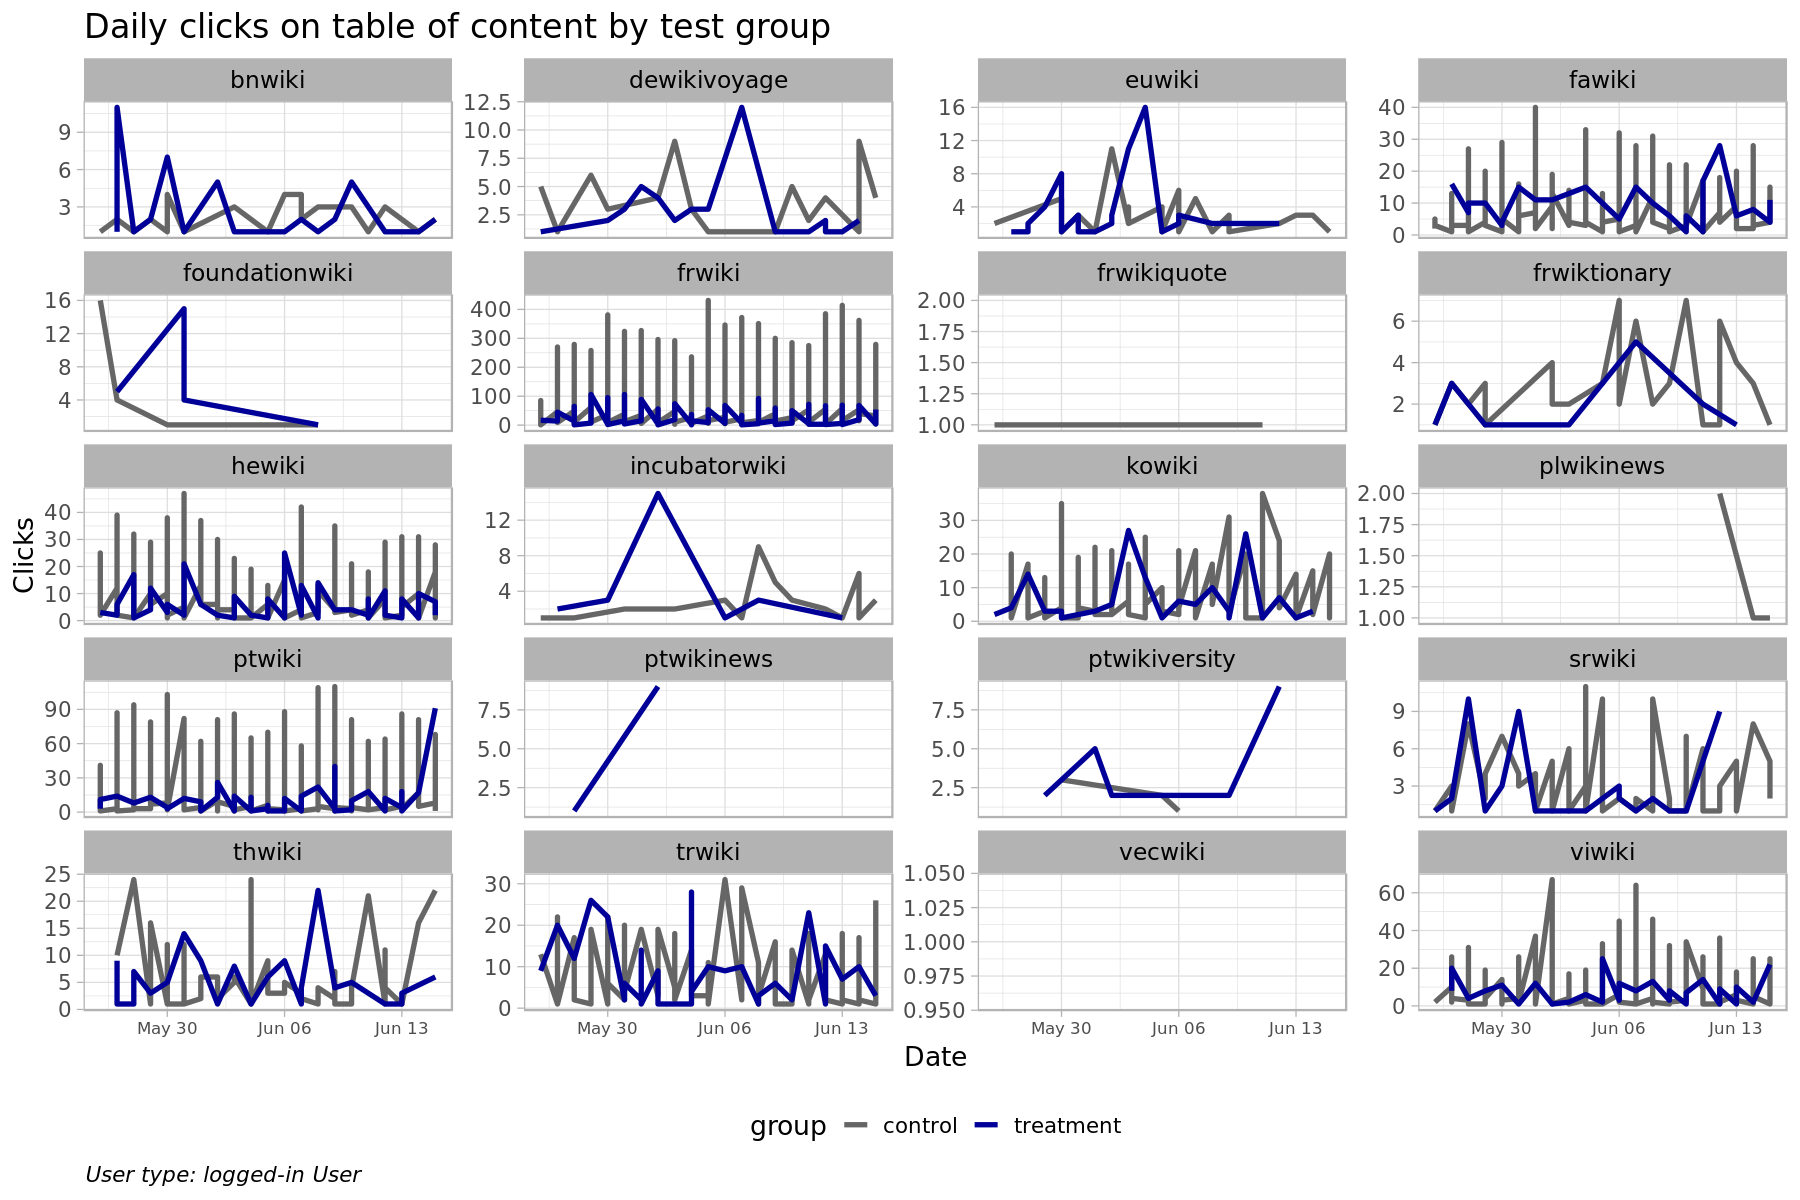

In [182]:
g_click_loggedin <-  df_clicks %>%
filter(isanon=='false') %>% 
filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>% 
ggplot(mapping=aes(x=event_date, y=clicks, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily clicks on table of content by test group',
     x = 'Date',
     y = 'Clicks',
    caption = "User type: logged-in User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_click_loggedin 

In [176]:
df_c_loggedin <- df_clicks  %>%
        filter(isanon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>% 
        group_by(wiki, test_group ) %>%
        summarize(total_clicks=sum(clicks), .groups='drop')

In [177]:
head(df_c_loggedin )

wiki         test_group total_clicks
1 bnwiki       control    49          
2 bnwiki       treatment  47          
3 dewikivoyage control    60          
4 dewikivoyage treatment  44          
5 euwiki       control    67          
6 euwiki       treatment  75

In [178]:
df_c_loggedin_W <- df_c_loggedin  %>%
    spread(test_group, total_clicks) %>%
    mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )
 


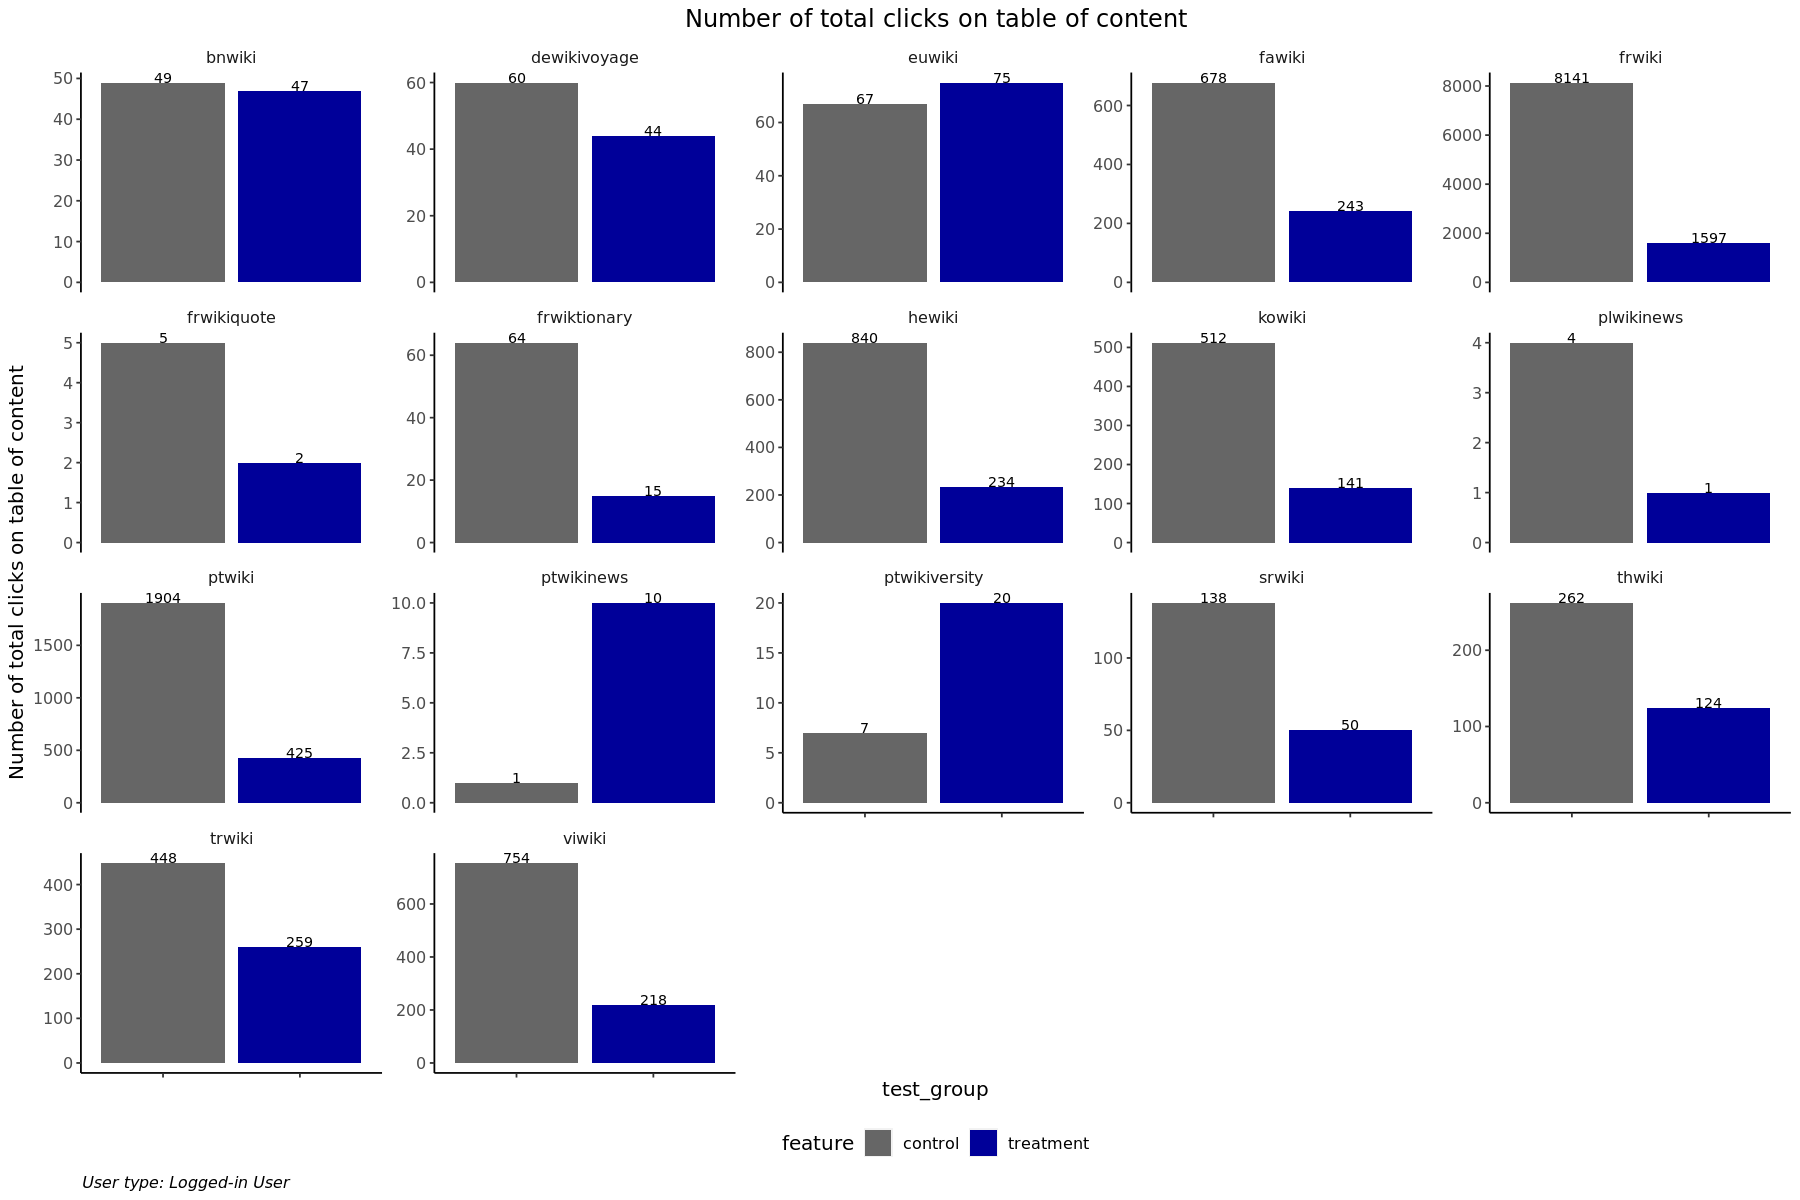

In [183]:
barchart_clicks_loggedin  <- df_c_loggedin %>%
        ggplot(aes(x = test_group, y= total_clicks, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total clicks on table of content" ,
             title = "Number of total clicks on table of content" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_clicks_loggedin

In [180]:
df_c_loggedin_W

wiki          control treatment pct_change
1  bnwiki          49      47       -4.08    
2  dewikivoyage    60      44      -26.67    
3  euwiki          67      75       11.94    
4  fawiki         678     243      -64.16    
5  frwiki        8141    1597      -80.38    
6  frwikiquote      5       2      -60.00    
7  frwiktionary    64      15      -76.56    
8  hewiki         840     234      -72.14    
9  kowiki         512     141      -72.46    
10 plwikinews       4       1      -75.00    
11 ptwiki        1904     425      -77.68    
12 ptwikinews       1      10      900.00    
13 ptwikiversity    7      20      185.71    
14 srwiki         138      50      -63.77    
15 thwiki         262     124      -52.67    
16 trwiki         448     259      -42.19    
17 viwiki         754     218      -71.09

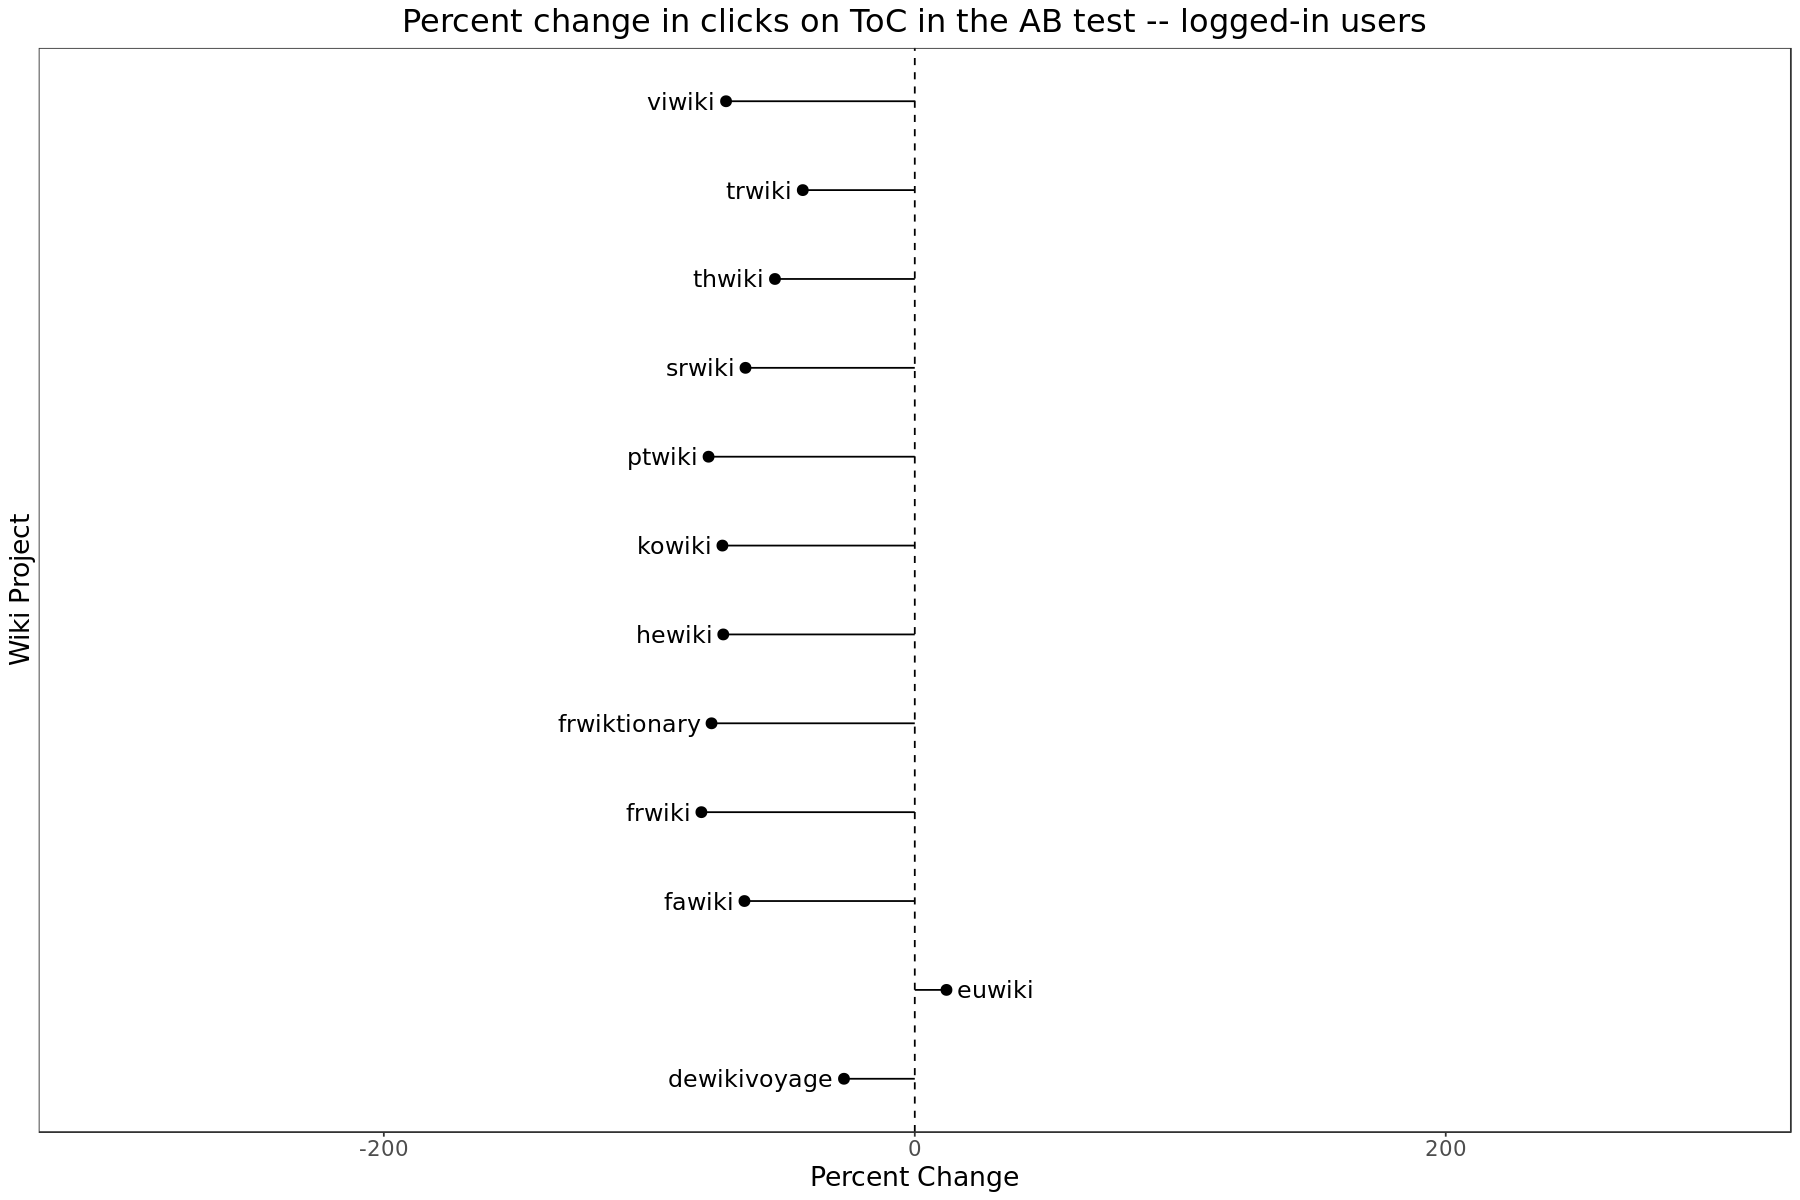

In [184]:
pct_g <- df_c_loggedin_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in clicks on ToC in the AB test -- logged-in users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Average percentage change__

Average of the percent changes observed on each early adopter wiki (%) 

In [185]:
mean((filter(df_c_loggedin_W , is.numeric(pct_change) & control>50))$pct_change, na.rm=TRUE)

[1] -57.31917

### Anonymous user

In [186]:
df_c_anon <- df_clicks  %>%
        filter(isanon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>% 
        group_by(wiki, test_group ) %>%
        summarize(total_clicks=sum(clicks), .groups='drop')
df_c_anon

wiki          test_group total_clicks
1  bnwiki        control      1932      
2  bnwiki        treatment    1320      
3  dewikivoyage  control       960      
4  dewikivoyage  treatment     737      
5  euwiki        control      1098      
6  euwiki        treatment     500      
7  fawiki        control      9773      
8  fawiki        treatment    4885      
9  frwiki        control    263464      
10 frwiki        treatment   50978      
11 frwikiquote   control        53      
12 frwikiquote   treatment      20      
13 frwiktionary  control      1720      
14 frwiktionary  treatment     458      
15 hewiki        control     15583      
16 hewiki        treatment    5384      
17 kowiki        control     28721      
18 kowiki        treatment    7762      
19 plwikinews    control         1      
20 ptwiki        control     51066      
21 ptwiki        treatment   11909      
22 ptwikiversity control       108      
23 ptwikiversity treatment      35      
24 srwiki        control      3521      
25 srwiki        treatment    1595      
26 thwiki        control     15265      
27 thwiki        treatment    6170      
28 trwiki        control       222      
29 trwiki        treatment      38      
30 viwiki        control     26406      
31 viwiki        treatment    9007      
32 viwikibooks   control         6      
33 viwikibooks   treatment      12

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



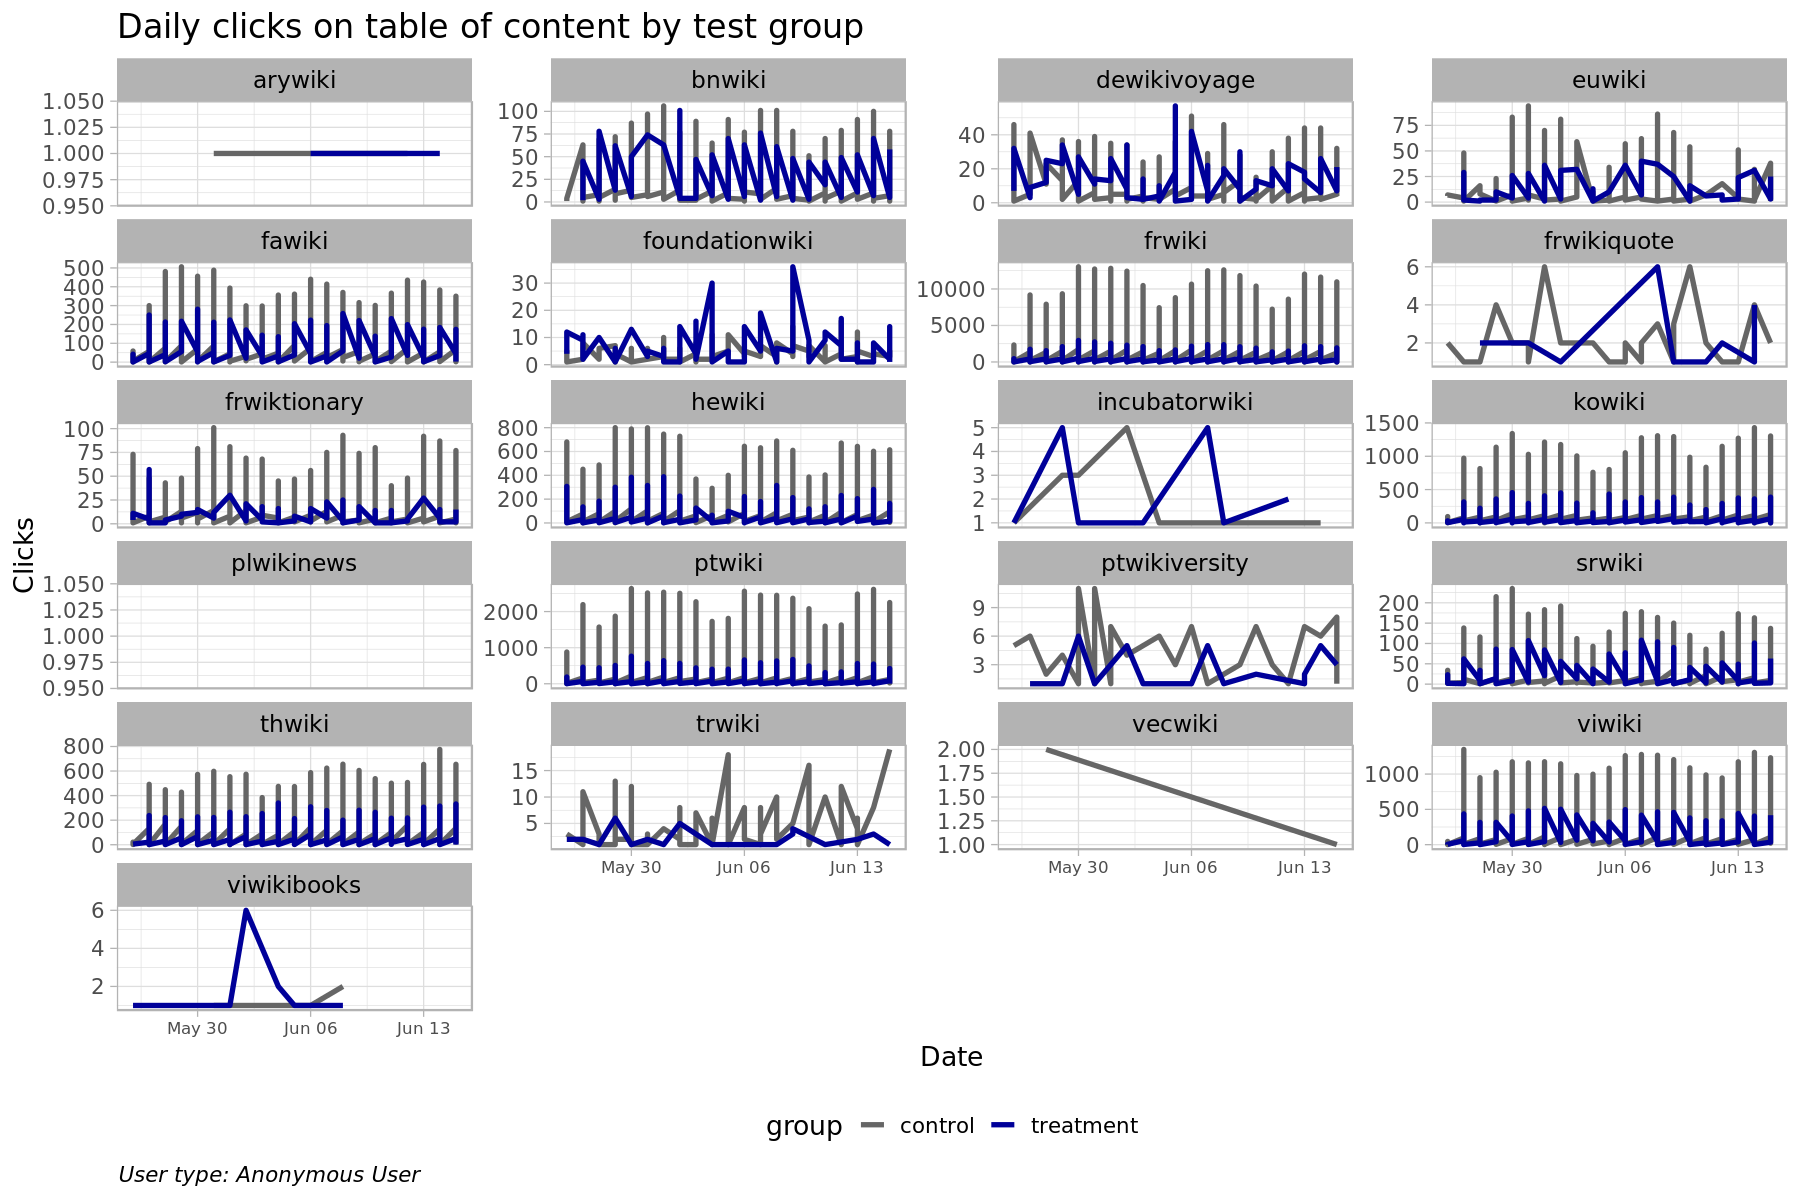

In [187]:
g_click_anon <-  df_clicks %>%
filter(isanon=='true') %>% 
filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>% 
ggplot(mapping=aes(x=event_date, y=clicks, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily clicks on table of content by test group',
     x = 'Date',
     y = 'Clicks',
    caption = "User type: Anonymous User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_click_anon

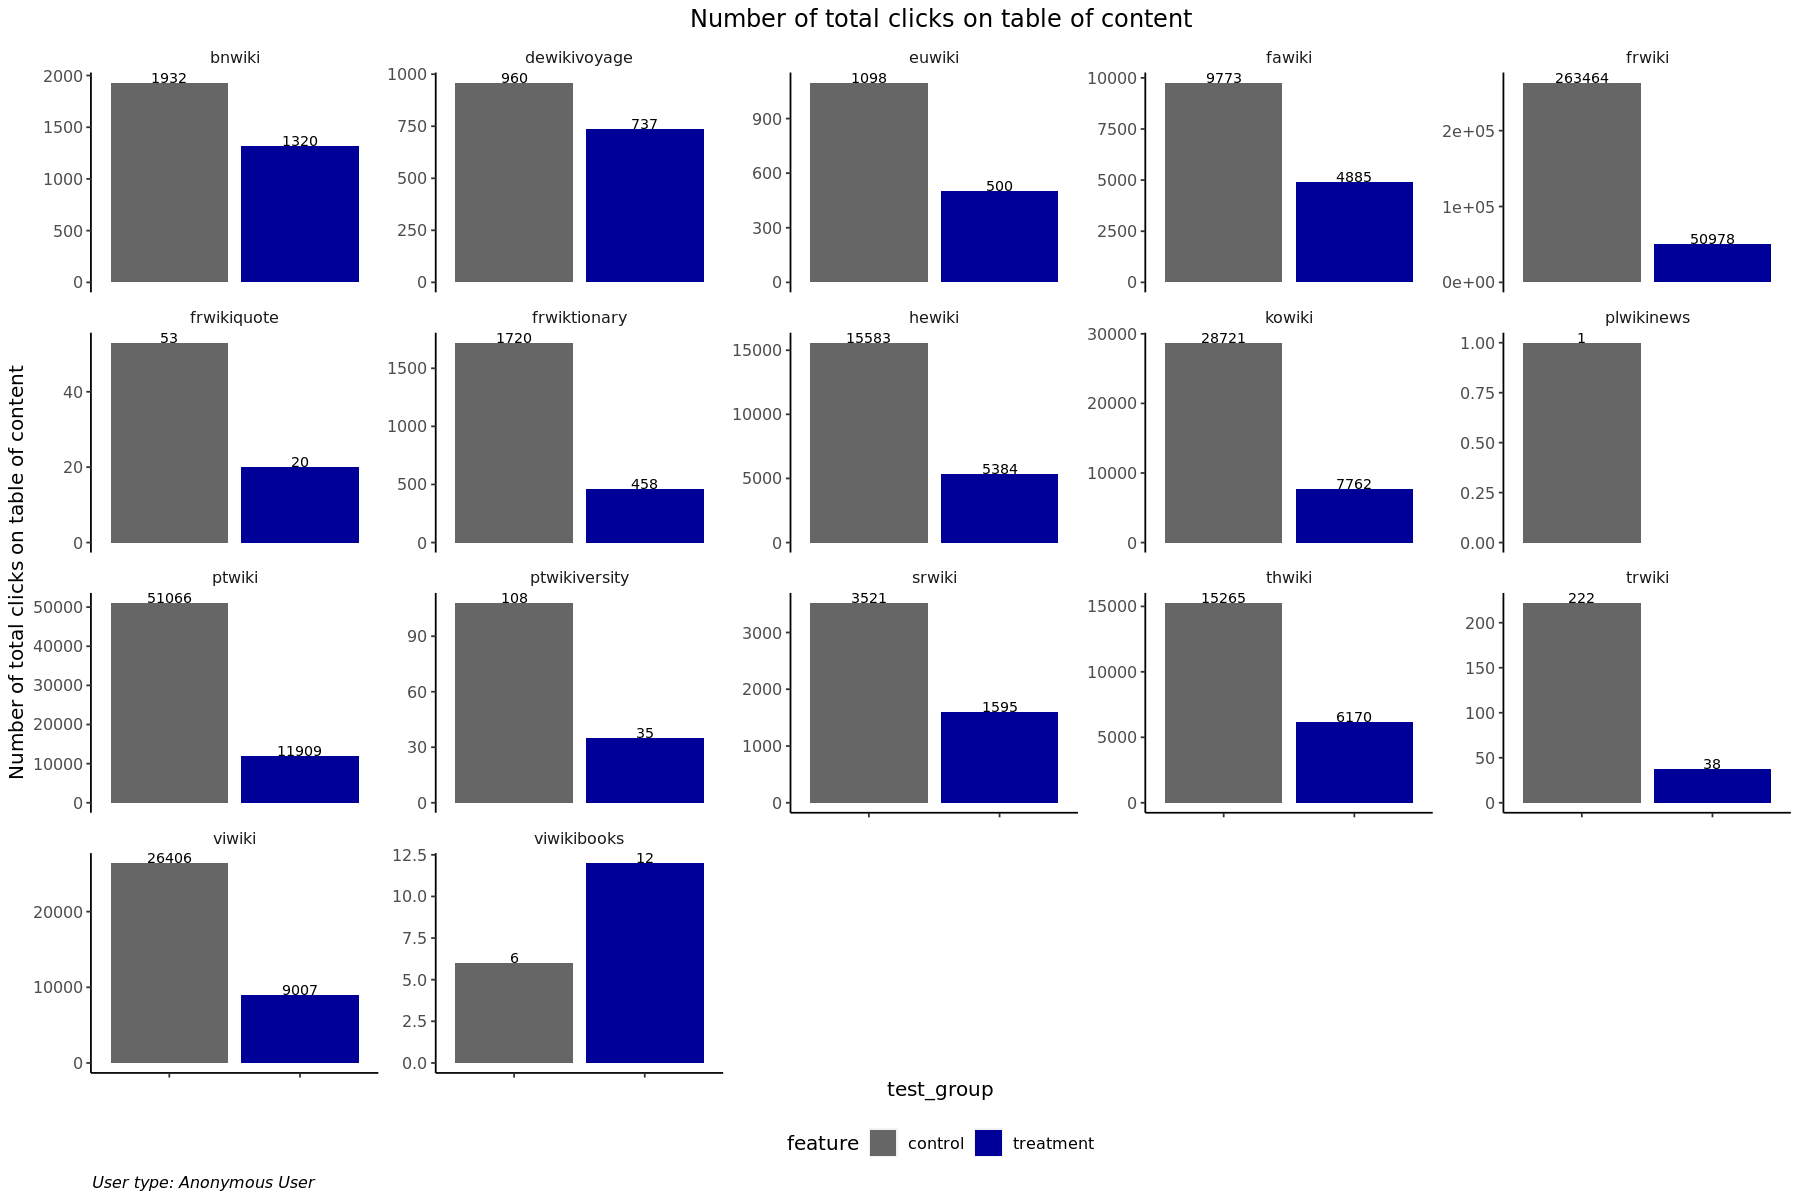

In [188]:
barchart_clicks_anon  <- df_c_anon %>%
        ggplot(aes(x = test_group, y= total_clicks, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total clicks on table of content" ,
             title = "Number of total clicks on table of content" ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_clicks_anon

In [189]:
df_c_anon_W <- df_c_anon  %>%
    spread(test_group, total_clicks)

 

In [190]:
df_c_anon_W[is.na(df_c_anon_W)] <- 0


In [191]:
df_c_anon_W

wiki          control treatment
1  bnwiki          1932   1320    
2  dewikivoyage     960    737    
3  euwiki          1098    500    
4  fawiki          9773   4885    
5  frwiki        263464  50978    
6  frwikiquote       53     20    
7  frwiktionary    1720    458    
8  hewiki         15583   5384    
9  kowiki         28721   7762    
10 plwikinews         1      0    
11 ptwiki         51066  11909    
12 ptwikiversity    108     35    
13 srwiki          3521   1595    
14 thwiki         15265   6170    
15 trwiki           222     38    
16 viwiki         26406   9007    
17 viwikibooks        6     12

In [192]:
df_c_anon_W <- df_c_anon_W %>%
      mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [193]:
df_c_anon_W 

wiki          control treatment pct_change
1  bnwiki          1932   1320      -31.68   
2  dewikivoyage     960    737      -23.23   
3  euwiki          1098    500      -54.46   
4  fawiki          9773   4885      -50.02   
5  frwiki        263464  50978      -80.65   
6  frwikiquote       53     20      -62.26   
7  frwiktionary    1720    458      -73.37   
8  hewiki         15583   5384      -65.45   
9  kowiki         28721   7762      -72.97   
10 plwikinews         1      0     -100.00   
11 ptwiki         51066  11909      -76.68   
12 ptwikiversity    108     35      -67.59   
13 srwiki          3521   1595      -54.70   
14 thwiki         15265   6170      -59.58   
15 trwiki           222     38      -82.88   
16 viwiki         26406   9007      -65.89   
17 viwikibooks        6     12      100.00

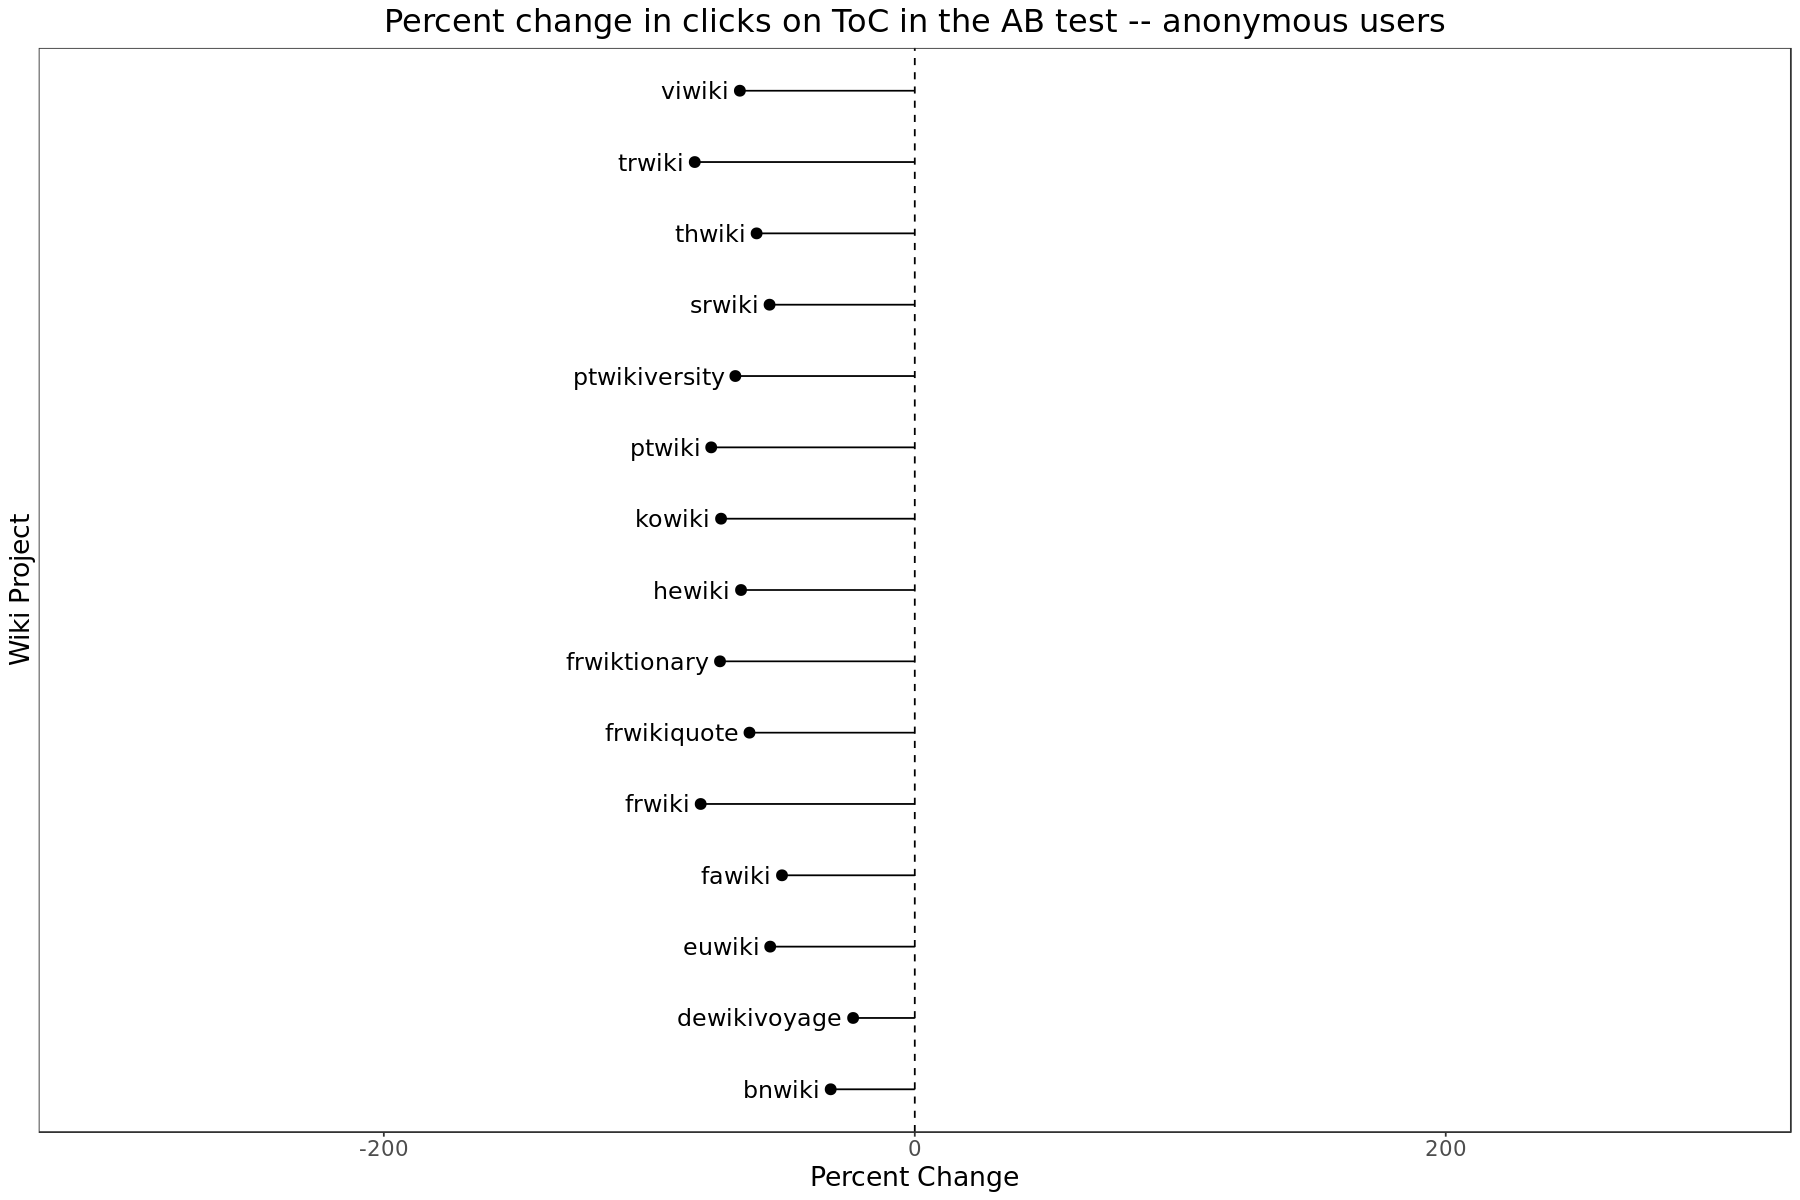

In [194]:
pct_g <- df_c_anon_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in clicks on ToC in the AB test -- anonymous users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Average percentage change__

Average of the percent changes observed on each early adopter wiki (%) 

In [195]:
mean((filter(df_c_anon_W , is.numeric(pct_change) & control>50))$pct_change, na.rm=TRUE)

[1] -61.42733

__Summary__  

Below summary is based on the data after removing the clicks on old ToC in treatment group and removing the clicks on new ToC in control group. 

The hypothesis that the new table of contents is used more frequently than the previous table of contents is NOT supported by data. Instead, compared to control group, the clicks on ToC in treatment group decreased 57% for logged-in users and 61% for anonymous users.

Need to discuss with PM. 

## Scrolls to ToC

__Test question: Does the new table of contents reduce the need to scroll back to the top of the page__. 


__Note:__   (2022-07-06)
Data shows in treatment group, some of sessions saw the old ToC, and some of sessions saw the new ToC.

With such a test group assignment, the AB test analysis on scrolls to ToC is invalid. Because schema mediawiki_web_ab_test_enrollment and mediawiki_web_ui_scroll do not record events on old ToC and new ToC seperated. The treatment group and control group can not be correctly categorized purely based on schema mediawiki_web_ab_test_enrollment. 

In [137]:
query_scroll <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022  
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
AND NOT is_bot
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)

--scrolls by session
SELECT  TO_DATE(t3.meta.dt) AS event_date,t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id, COUNT(1) AS scrolls 
FROM t_ab
LEFT JOIN event.mediawiki_web_ui_scroll AS t3 
ON t_ab.domain=t3.meta.domain AND t3.web_session_id = t_ab.web_session_id
AND t3.year=2022 AND month IN (5,6) 
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
WHERE t_ab.session_dt <= t3.meta.dt
AND t3.action='scroll-to-toc'
GROUP BY  TO_DATE(t3.meta.dt) , t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id

"


In [138]:
df_scrolls <- wmfdata::query_hive(query_scroll)

Don't forget to authenticate with Kerberos using kinit



In [140]:
df_scrolls$event_date <- as.Date(df_scrolls$event_date)

In [ ]:
write_csv(df_scrolls, "Data_out/scrolls.csv")

### Logged-in Users

In [167]:
df_s_loggedin <- df_scrolls  %>%
        filter(is_anon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_scrolls=sum(scrolls), .groups='drop')

In [168]:
df_s_loggedin

wiki          test_group total_scrolls
1  bnwiki        control      712        
2  bnwiki        treatment    827        
3  dewikivoyage  control      128        
4  dewikivoyage  treatment    434        
5  euwiki        control      893        
6  euwiki        treatment    848        
7  fawiki        control     5855        
8  fawiki        treatment   5241        
9  frwiki        control    37162        
10 frwiki        treatment  35200        
11 frwikiquote   control       37        
12 frwikiquote   treatment     29        
13 frwiktionary  control      551        
14 frwiktionary  treatment    540        
15 hewiki        control     4462        
16 hewiki        treatment   5295        
17 idwiki        control     3185        
18 idwiki        treatment   3313        
19 kowiki        control     2847        
20 kowiki        treatment   3387        
21 mediawikiwiki control     1679        
22 mediawikiwiki treatment    707        
23 plwikinews    control       11        
24 plwikinews    treatment      2        
25 ptwiki        control    12184        
26 ptwiki        treatment  11482        
27 ptwikinews    control        3        
28 ptwikinews    treatment     22        
29 ptwikiversity control       11        
30 ptwikiversity treatment     60        
31 srwiki        control     1293        
32 srwiki        treatment   1542        
33 thwiki        control     1812        
34 thwiki        treatment   1619        
35 trwiki        control     4757        
36 trwiki        treatment   4913        
37 viwiki        control     3686        
38 viwiki        treatment   3503        
39 viwikibooks   treatment      2

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



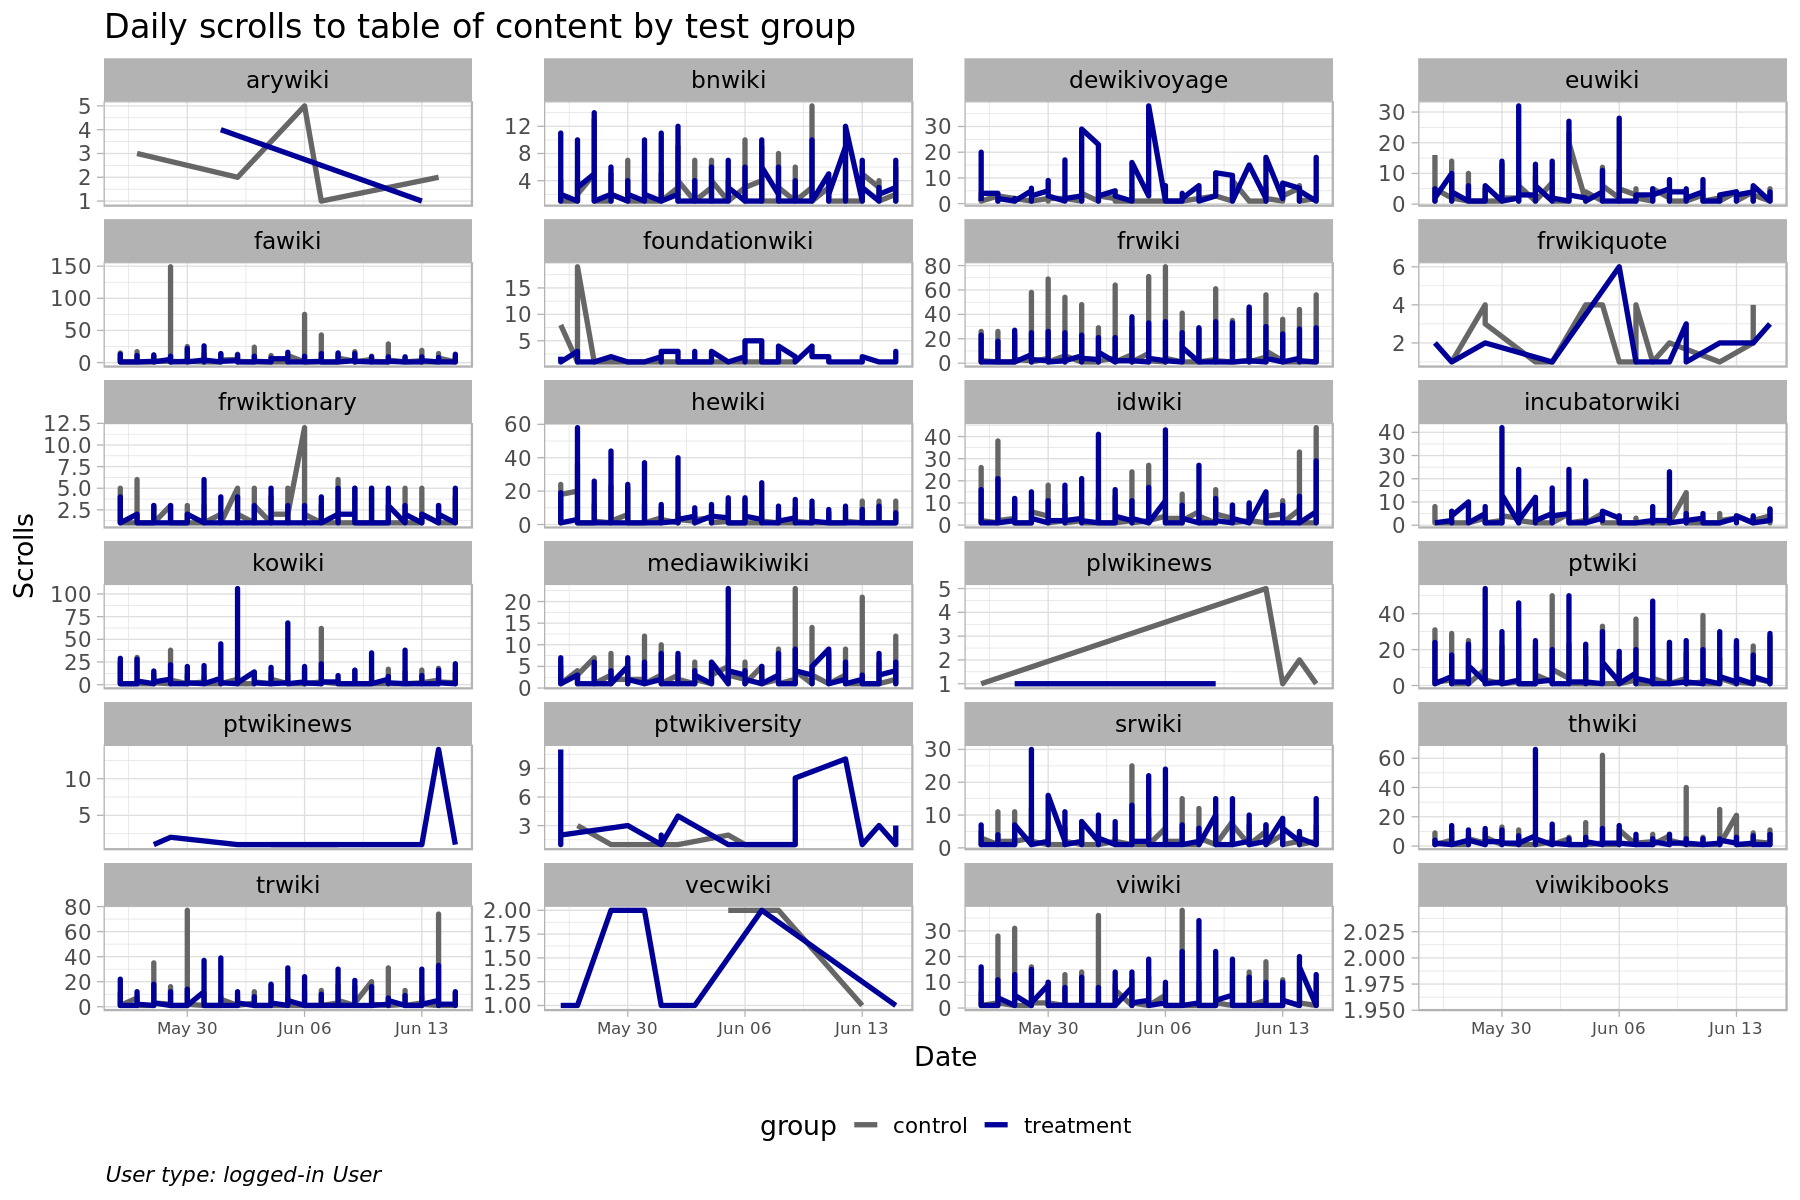

In [169]:
g_scroll_loggedin <-  df_scrolls %>%
filter(is_anon=='false') %>% 
ggplot(mapping=aes(x=event_date, y=scrolls, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily scrolls to table of content by test group',
     x = 'Date',
     y = 'Scrolls',
    caption = "User type: logged-in User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_scroll_loggedin 

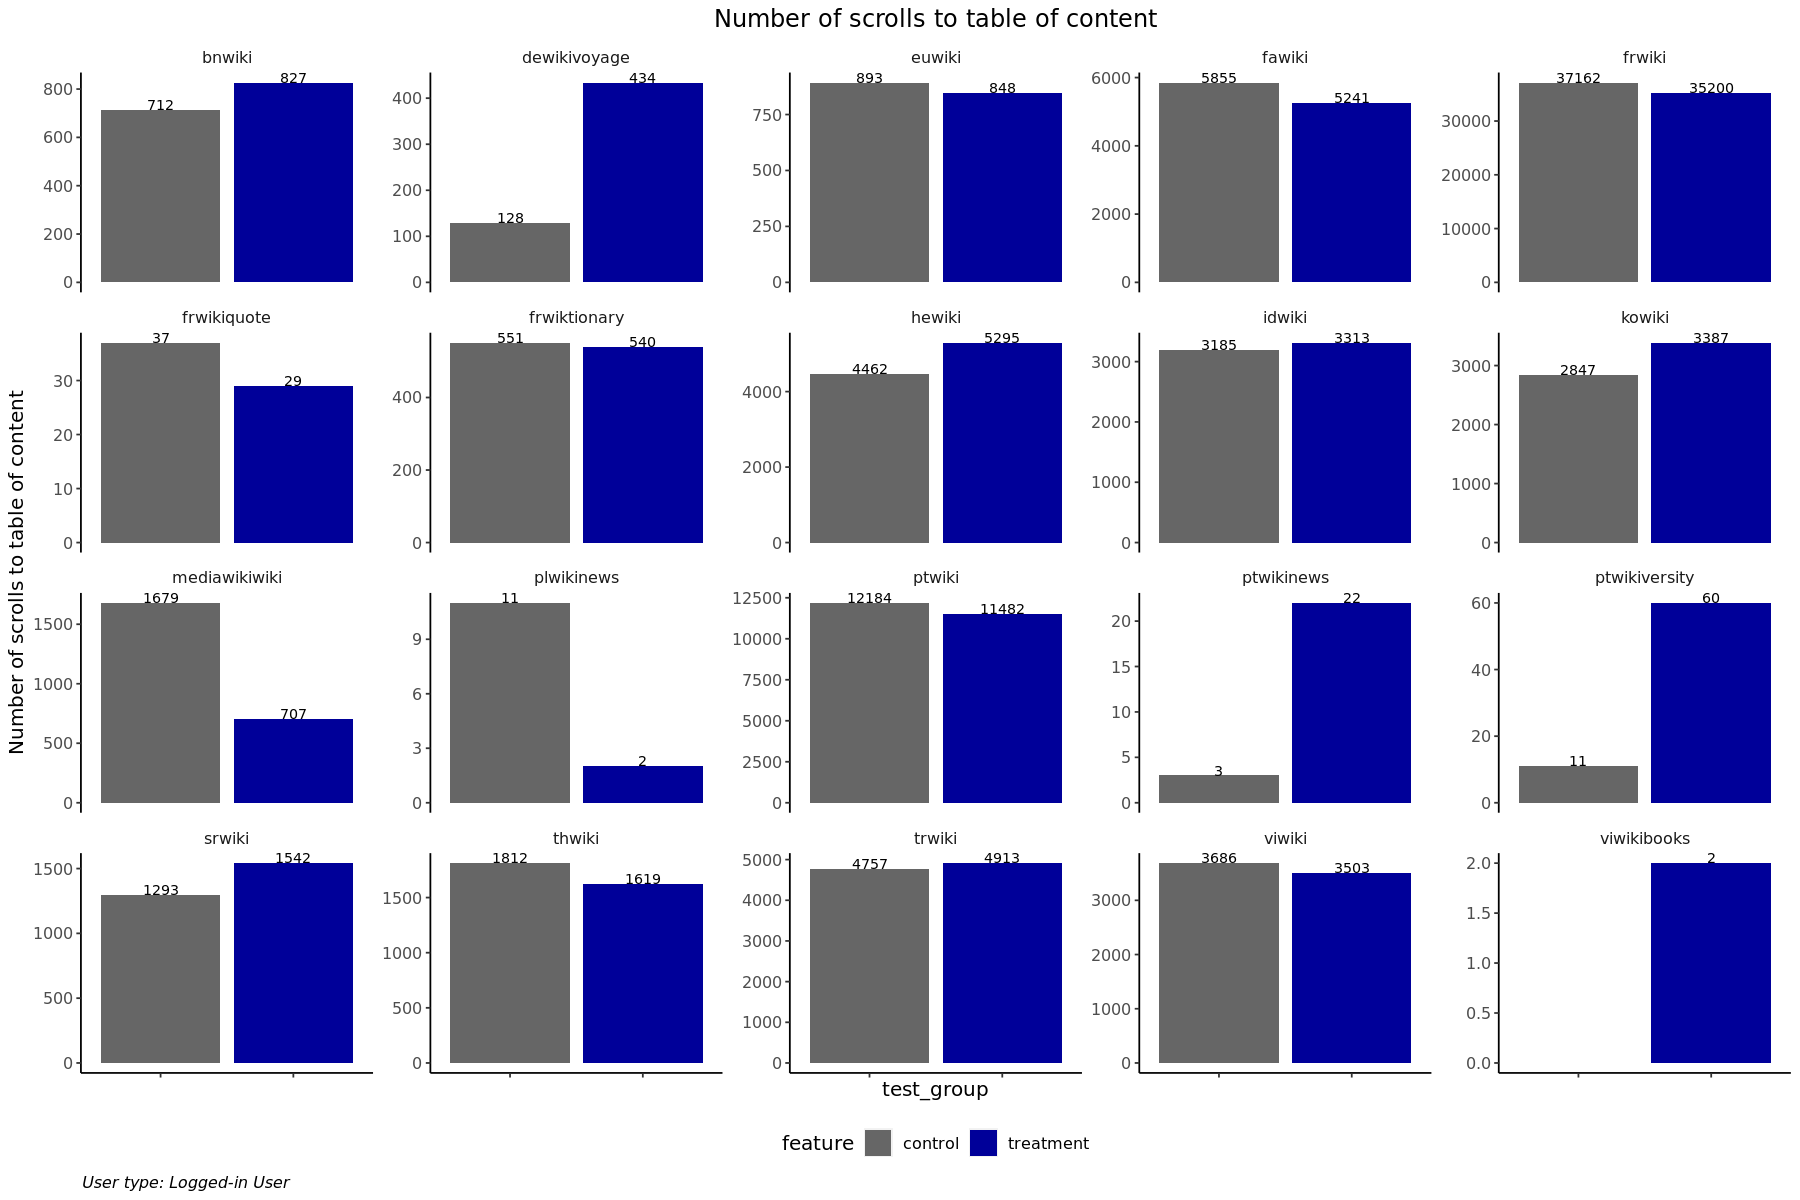

In [170]:
barchart_scrolls_loggedin  <- df_s_loggedin %>%
        ggplot(aes(x = test_group, y= total_scrolls, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_scrolls)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls to table of content" ,
             title = "Number of scrolls to table of content" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scrolls_loggedin

In [150]:
head(df_s_loggedin)

wiki         test_group total_scrolls
1 bnwiki       control    712          
2 bnwiki       treatment  827          
3 dewikivoyage control    128          
4 dewikivoyage treatment  434          
5 euwiki       control    893          
6 euwiki       treatment  848

In [171]:
df_s_loggedin_W <- df_s_loggedin %>%
    pivot_wider(names_from = test_group, values_from = total_scrolls, values_fill = 0)

In [172]:
df_s_loggedin_W

wiki          control treatment
1  bnwiki          712     827    
2  dewikivoyage    128     434    
3  euwiki          893     848    
4  fawiki         5855    5241    
5  frwiki        37162   35200    
6  frwikiquote      37      29    
7  frwiktionary    551     540    
8  hewiki         4462    5295    
9  idwiki         3185    3313    
10 kowiki         2847    3387    
11 mediawikiwiki  1679     707    
12 plwikinews       11       2    
13 ptwiki        12184   11482    
14 ptwikinews        3      22    
15 ptwikiversity    11      60    
16 srwiki         1293    1542    
17 thwiki         1812    1619    
18 trwiki         4757    4913    
19 viwiki         3686    3503    
20 viwikibooks       0       2

In [173]:
df_s_loggedin_W <- df_s_loggedin_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )
 


In [174]:
df_s_loggedin_W

wiki          control treatment pct_change
1  bnwiki          712     827      16.15    
2  dewikivoyage    128     434     239.06    
3  euwiki          893     848      -5.04    
4  fawiki         5855    5241     -10.49    
5  frwiki        37162   35200      -5.28    
6  frwikiquote      37      29     -21.62    
7  frwiktionary    551     540      -2.00    
8  hewiki         4462    5295      18.67    
9  idwiki         3185    3313       4.02    
10 kowiki         2847    3387      18.97    
11 mediawikiwiki  1679     707     -57.89    
12 plwikinews       11       2     -81.82    
13 ptwiki        12184   11482      -5.76    
14 ptwikinews        3      22     633.33    
15 ptwikiversity    11      60     445.45    
16 srwiki         1293    1542      19.26    
17 thwiki         1812    1619     -10.65    
18 trwiki         4757    4913       3.28    
19 viwiki         3686    3503      -4.96    
20 viwikibooks       0       2        Inf

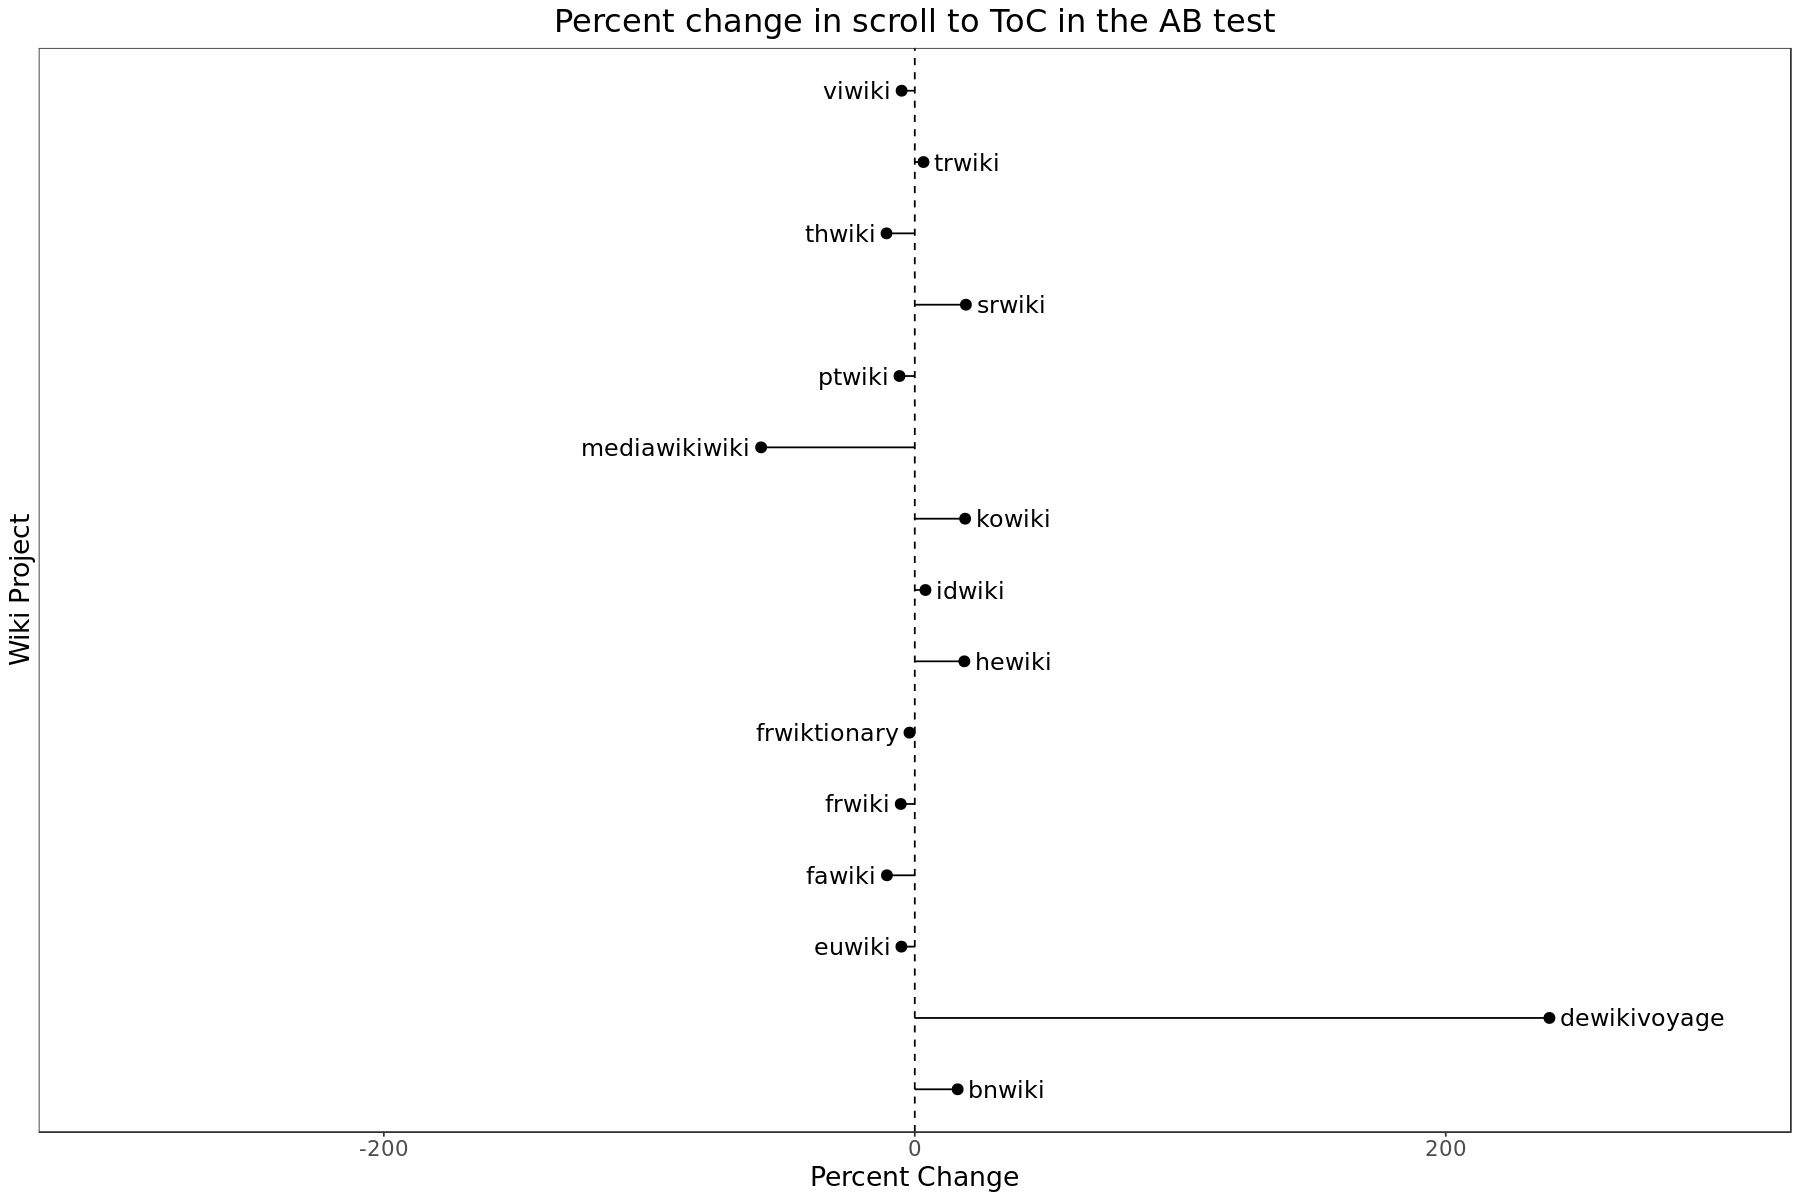

In [177]:
pct_g <- df_s_loggedin_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in scroll to ToC in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For logged-in users:  
On 7 wikis, the number of scrolls back to table of content is smaller in treatment group than in control group.   
On 7 wikis, the number of scrolls back to table of content is larger in treatment group than in control group.   

The new table of content did not reduce the need to scroll back to the table of content significantly. 



### Anonymous Users

In [179]:
df_s_anon <- df_scrolls  %>%
        filter(is_anon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_scrolls=sum(scrolls), .groups='drop')

In [180]:
df_s_anon

wiki          test_group total_scrolls
1  bnwiki        control      8522       
2  bnwiki        treatment    8832       
3  dewikivoyage  control      2332       
4  dewikivoyage  treatment    2356       
5  euwiki        control      3172       
6  euwiki        treatment    3455       
7  fawiki        control     63418       
8  fawiki        treatment   67346       
9  frwiki        control    621892       
10 frwiki        treatment  636386       
11 frwikiquote   control       118       
12 frwikiquote   treatment     142       
13 frwiktionary  control     10347       
14 frwiktionary  treatment    9411       
15 hewiki        control     48346       
16 hewiki        treatment   51887       
17 idwiki        control     73765       
18 idwiki        treatment   72159       
19 kowiki        control     83887       
20 kowiki        treatment   82866       
21 mediawikiwiki control      1968       
22 mediawikiwiki treatment    1326       
23 plwikinews    control         1       
24 ptwiki        control    222333       
25 ptwiki        treatment  221240       
26 ptwikinews    control         1       
27 ptwikinews    treatment       1       
28 ptwikiversity control       302       
29 ptwikiversity treatment     246       
30 srwiki        control     14979       
31 srwiki        treatment   15648       
32 thwiki        control     55747       
33 thwiki        treatment   55115       
34 trwiki        control      1136       
35 trwiki        treatment    1250       
36 viwiki        control     76705       
37 viwiki        treatment   74222       
38 viwikibooks   control        35       
39 viwikibooks   treatment      60

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



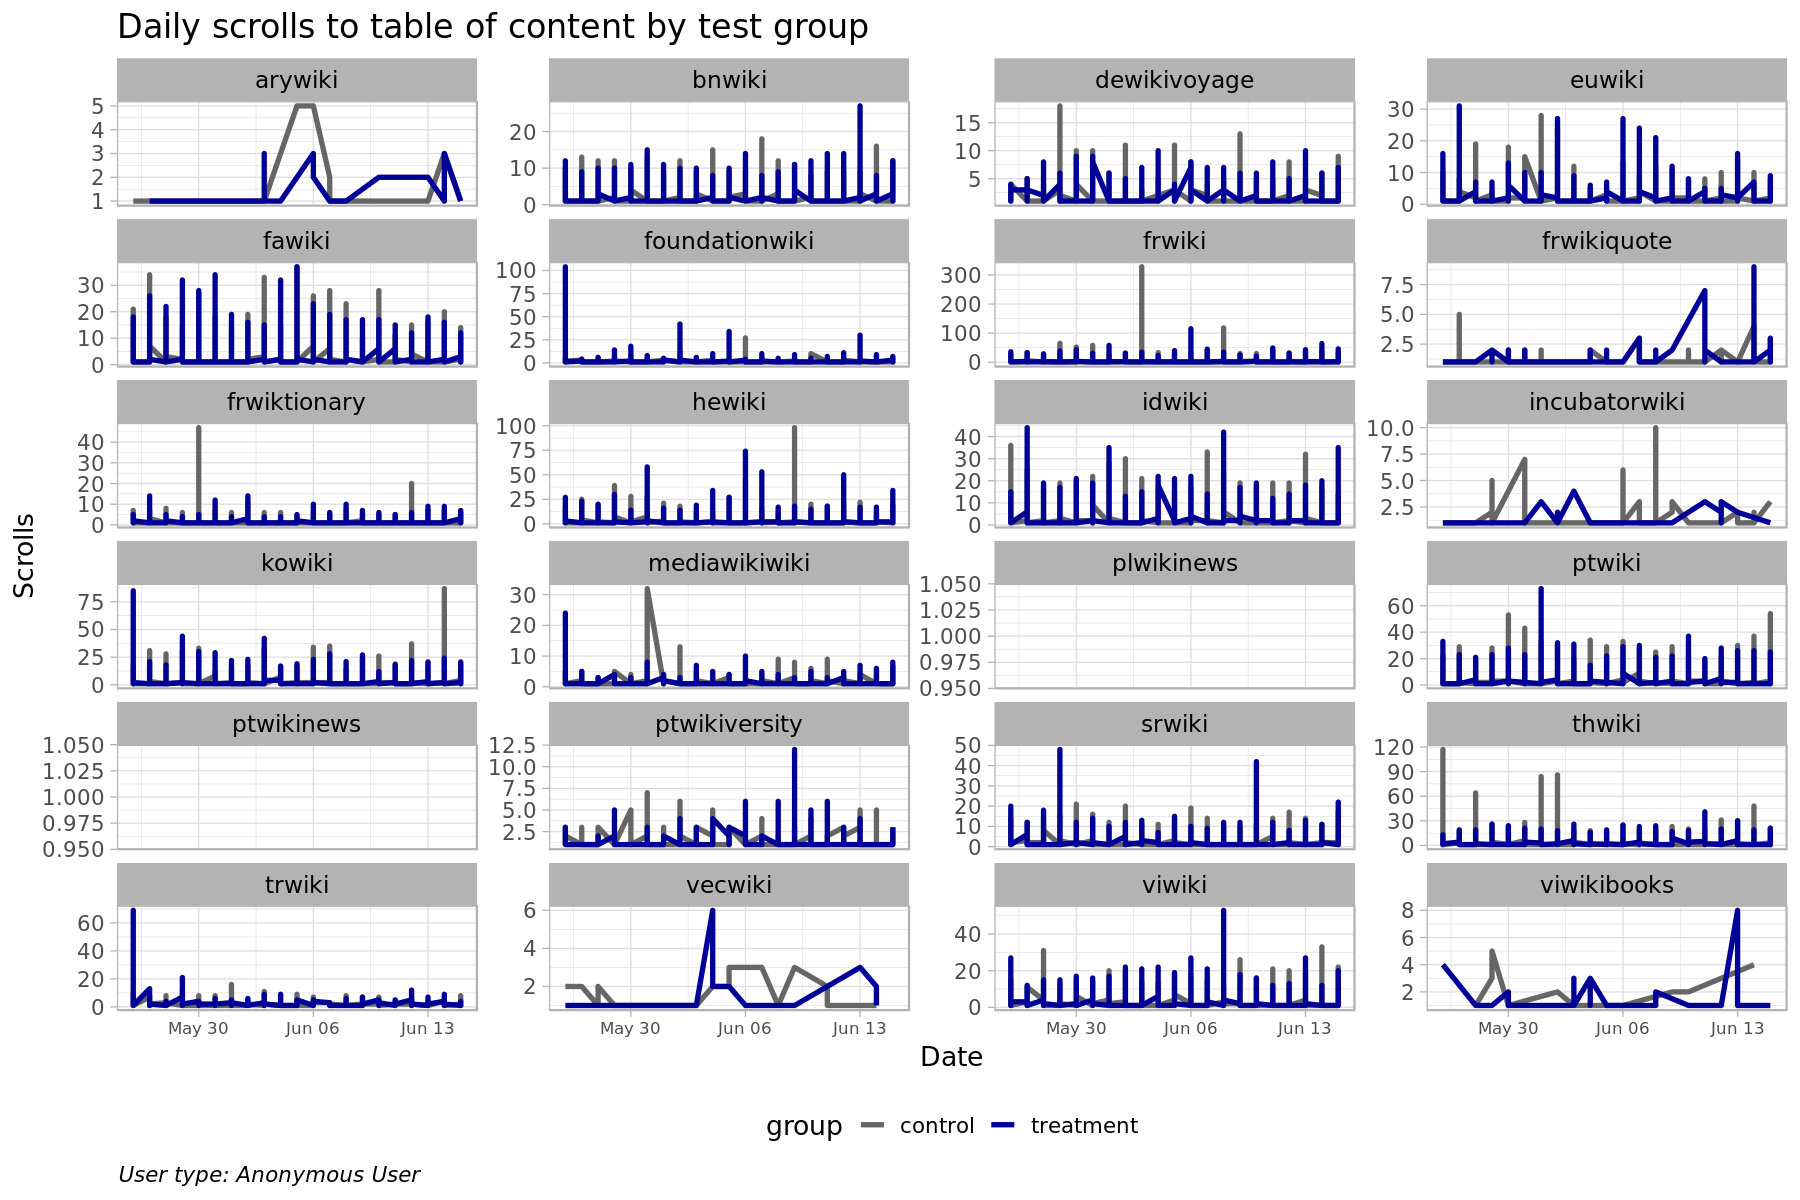

In [181]:
g_scroll_loggedin <-  df_scrolls %>%
filter(is_anon=='true') %>% 
ggplot(mapping=aes(x=event_date, y=scrolls, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily scrolls to table of content by test group',
     x = 'Date',
     y = 'Scrolls',
    caption = "User type: Anonymous User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_scroll_loggedin 

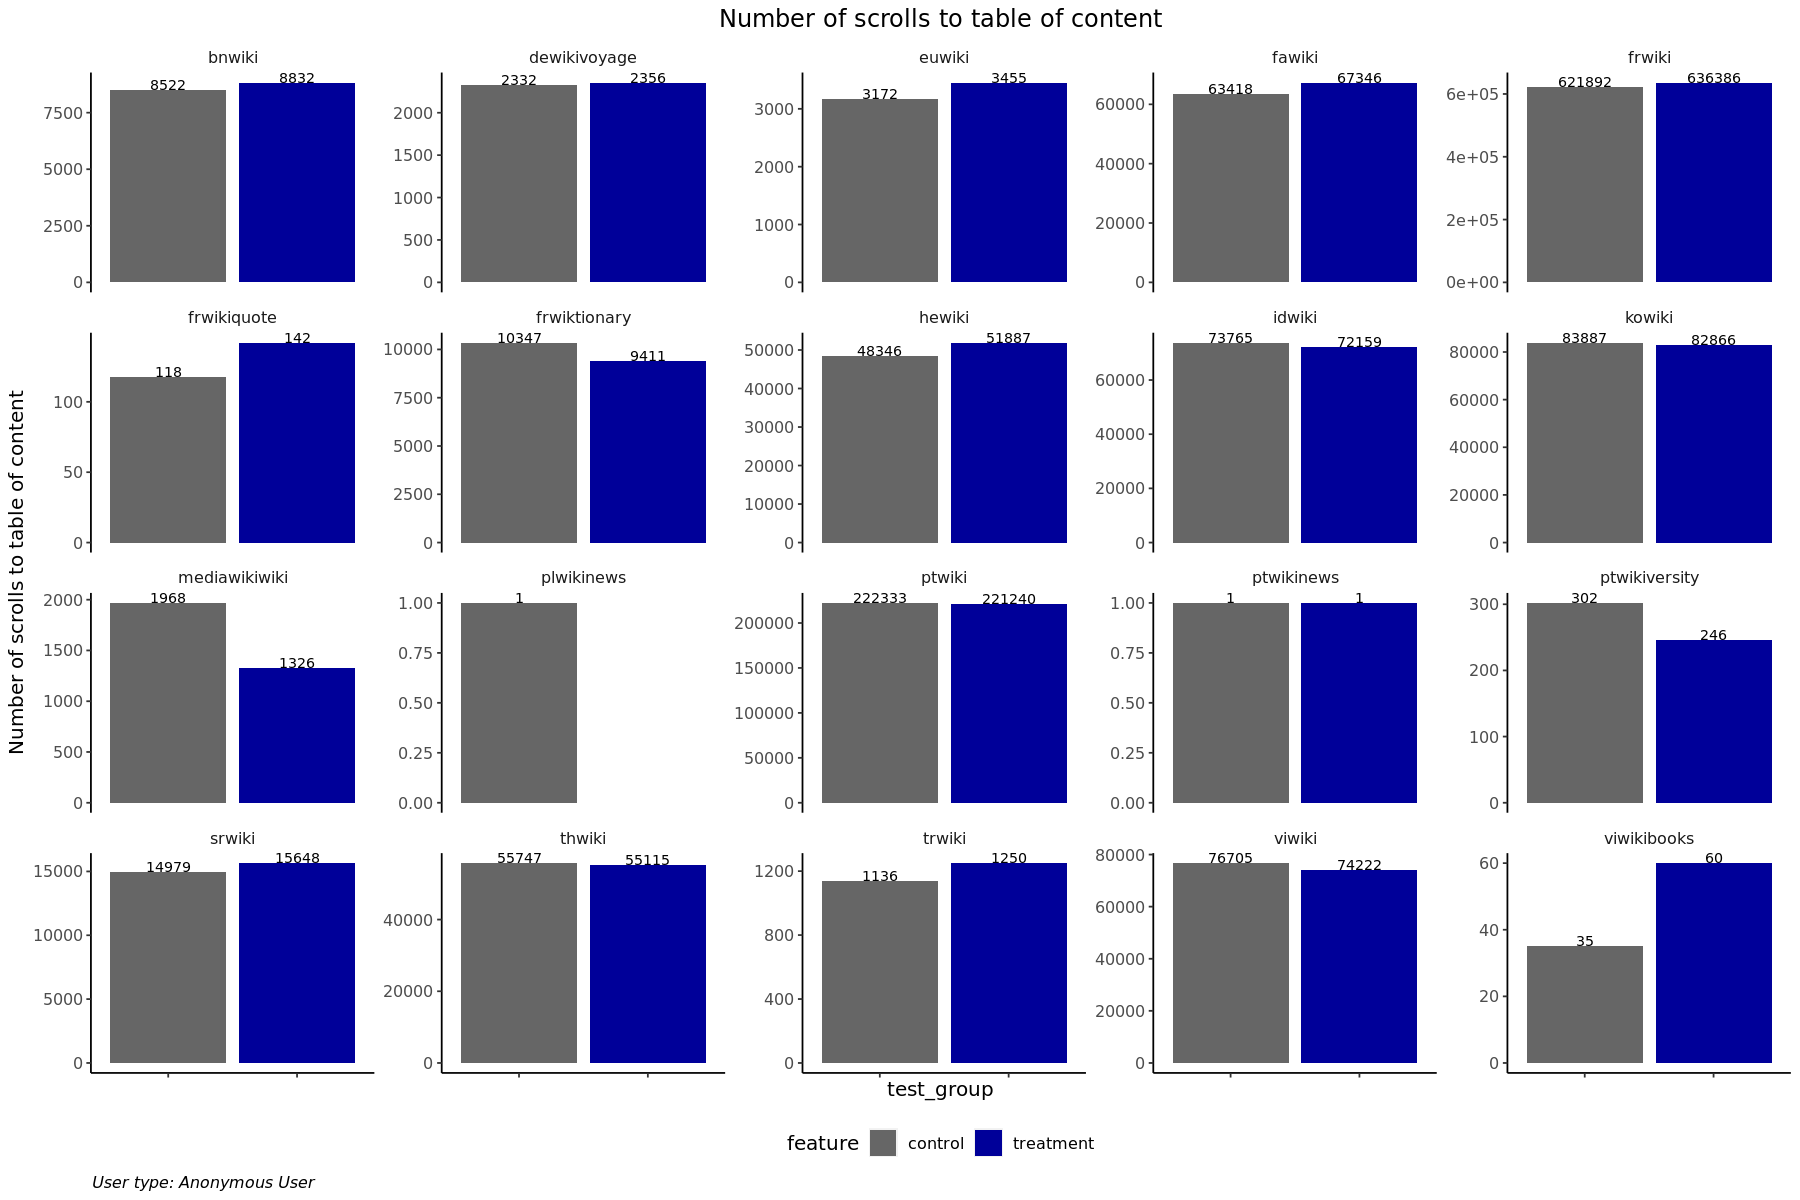

In [182]:
barchart_scrolls_anon  <- df_s_anon %>%
        ggplot(aes(x = test_group, y= total_scrolls, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_scrolls)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls to table of content" ,
             title = "Number of scrolls to table of content" ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scrolls_anon

In [183]:
df_s_anon_W <- df_s_anon %>%
    pivot_wider(names_from = test_group, values_from = total_scrolls, values_fill = 0)

In [184]:
df_s_anon_W <- df_s_anon_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [185]:
df_s_anon_W

wiki          control treatment pct_change
1  bnwiki          8522    8832       3.64   
2  dewikivoyage    2332    2356       1.03   
3  euwiki          3172    3455       8.92   
4  fawiki         63418   67346       6.19   
5  frwiki        621892  636386       2.33   
6  frwikiquote      118     142      20.34   
7  frwiktionary   10347    9411      -9.05   
8  hewiki         48346   51887       7.32   
9  idwiki         73765   72159      -2.18   
10 kowiki         83887   82866      -1.22   
11 mediawikiwiki   1968    1326     -32.62   
12 plwikinews         1       0    -100.00   
13 ptwiki        222333  221240      -0.49   
14 ptwikinews         1       1       0.00   
15 ptwikiversity    302     246     -18.54   
16 srwiki         14979   15648       4.47   
17 thwiki         55747   55115      -1.13   
18 trwiki          1136    1250      10.04   
19 viwiki         76705   74222      -3.24   
20 viwikibooks       35      60      71.43

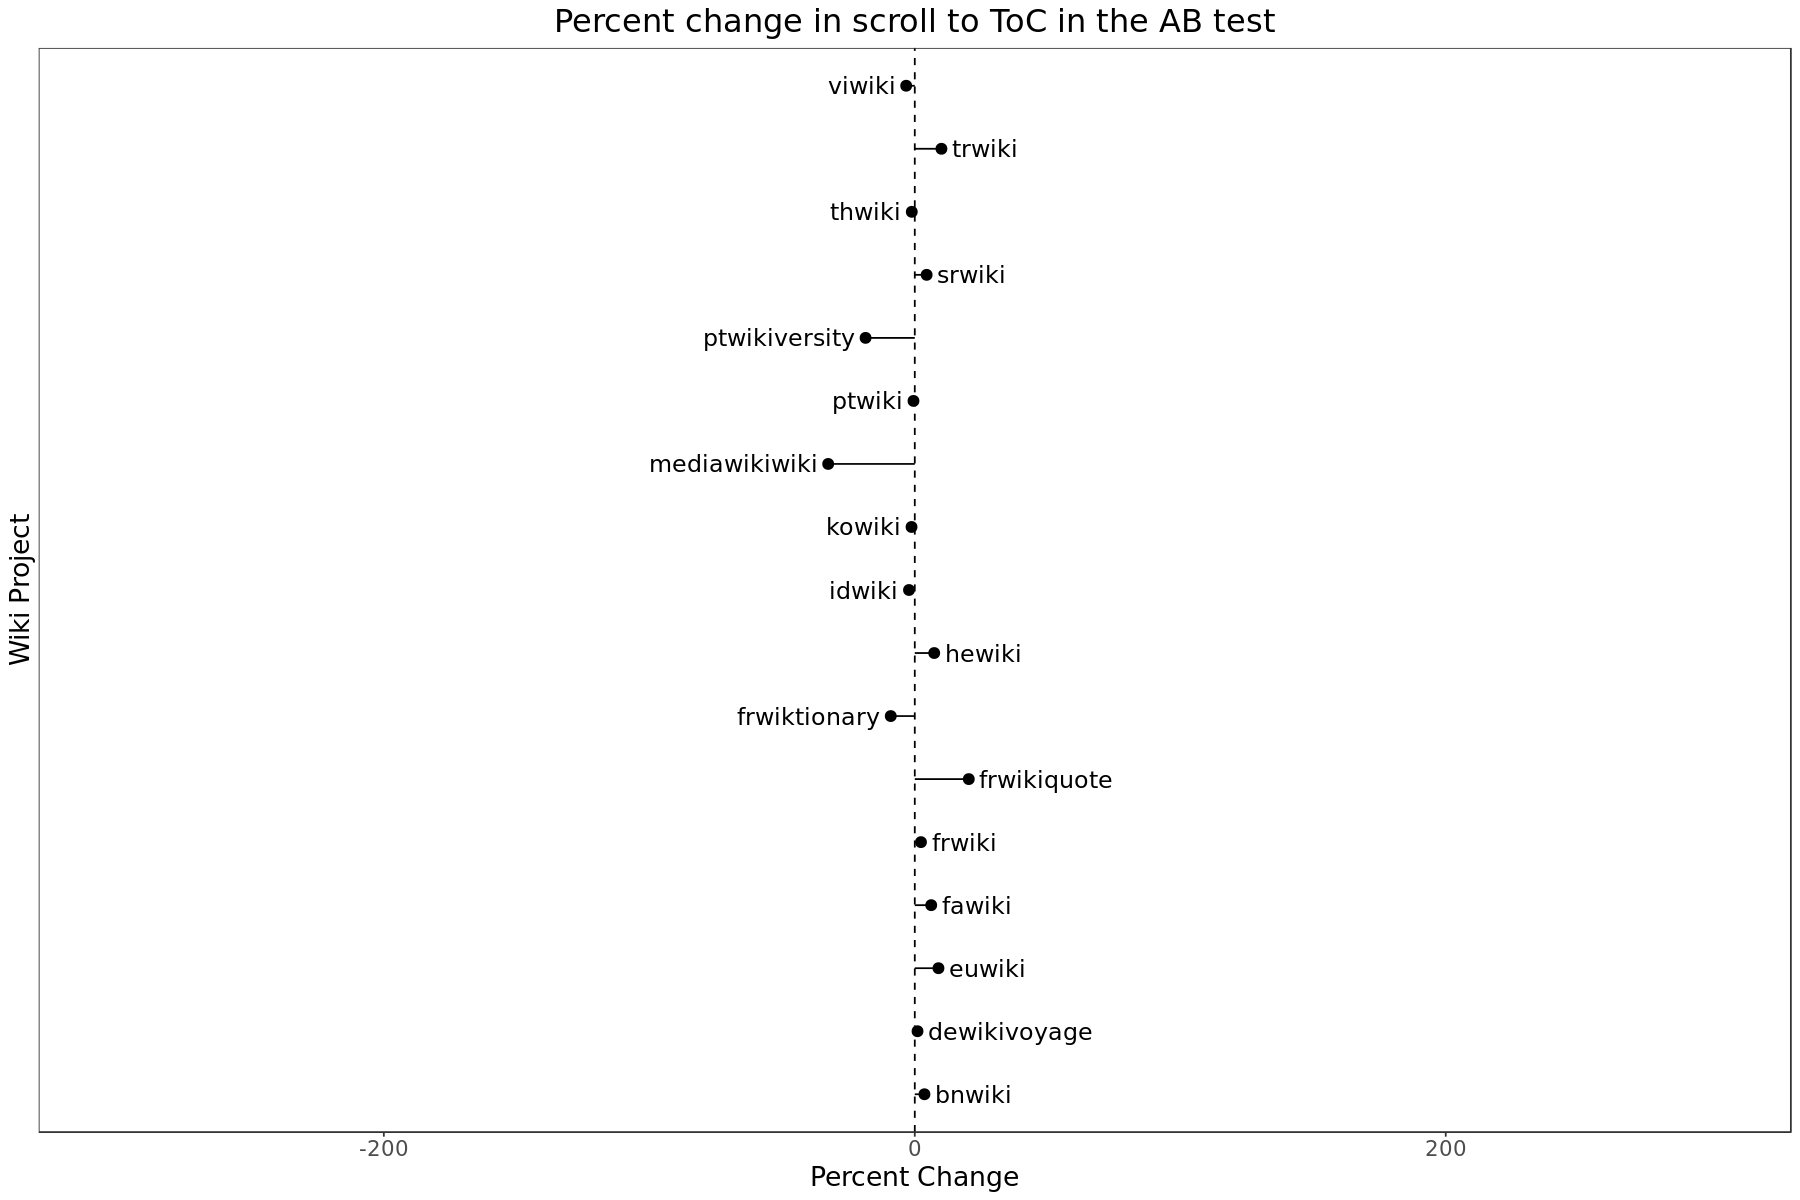

In [186]:
pct_g <- df_s_anon_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in scroll to ToC in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__  


For anonymous users:  
On 6 wikis, the number of scrolls back to table of content in treatment group is smaller than in control group.   
On 9 wikis, the number of scrolls back to table of content in treatment group is larger than in control group.   

The new table of content did not reduce the need to scroll back to the table of content significantly. 



__Data Modeling Summary__.  

We explored Hierarchical Generalized Linear Models using glmer() function from lme4 package to fit the session based data. We also tried Bayesian Multilevel Models using brms package, but failed to get a converged model. 

For logged-in users, 
Coef of treatment group = -0.008601, p-value= 0.0847 > 0.05.  We cannot rejected null hypothesis that treatment group and control group have same level of scrolls back to ToC. 
We don't have data to suppport that the new table of contents reduce the need to scroll back to the top of the page for logged-in users. 

For logged-out users, we did not find a converged model. It's an indication that the data do not fit the model well, because there are too many poorly fitting observations.

__Summary:__  

The hypothsis is that the new table of content reduce the need to scroll back to the table of content. 
It's not supported by data for both logged-in users and anonymous users.

__Note__   
__Test question: Does the new table of contents decrease the time people spend scrolling/scrolling quickly (if possible)__


Field scroll_speed is not recorded (value is null) in mediawiki_web_ui_scroll schema. No data is collected to answer this question.

## Reading time
__Test question: How does the new table of contents affect the time spent on a page__

__Note:__   (2022-07-06)
Data shows in treatment group, some of sessions saw the old ToC, and some of sessions saw the new ToC.

With such a test group assignment, the AB test analysis on reading time is invalid. Because schema mediawiki_web_ab_test_enrollment and mediawiki_reading_depth do not record events on old ToC and new ToC seperated. The treatment group and control group can not be correctly categorized purely based on schema mediawiki_web_ab_test_enrollment. 

In [204]:
query_reading_length <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 AND month IN (5,6) 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
AND NOT is_bot
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)

--reading time by session
SELECT  TO_DATE(t3.meta.dt) AS event_date,t_ab.wiki,   t_ab.test_group, t3.session_token, is_anon,
sum(total_length) AS sum_reading_length, sum(page_length) AS sum_page_length
FROM event.mediawiki_reading_depth AS t3 
INNER JOIN  t_ab
ON t_ab.domain=t3.meta.domain AND t3.session_token = t_ab.web_session_id
WHERE t3.year=2022 AND t3.month IN (5,6) 
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t_ab.session_dt <= t3.meta.dt
AND t3.page_length>0 
-- cap the long tail
AND t3.total_length <= 5000000
GROUP BY  TO_DATE(t3.meta.dt) , t_ab.wiki,   t_ab.test_group, t3.session_token, is_anon
"

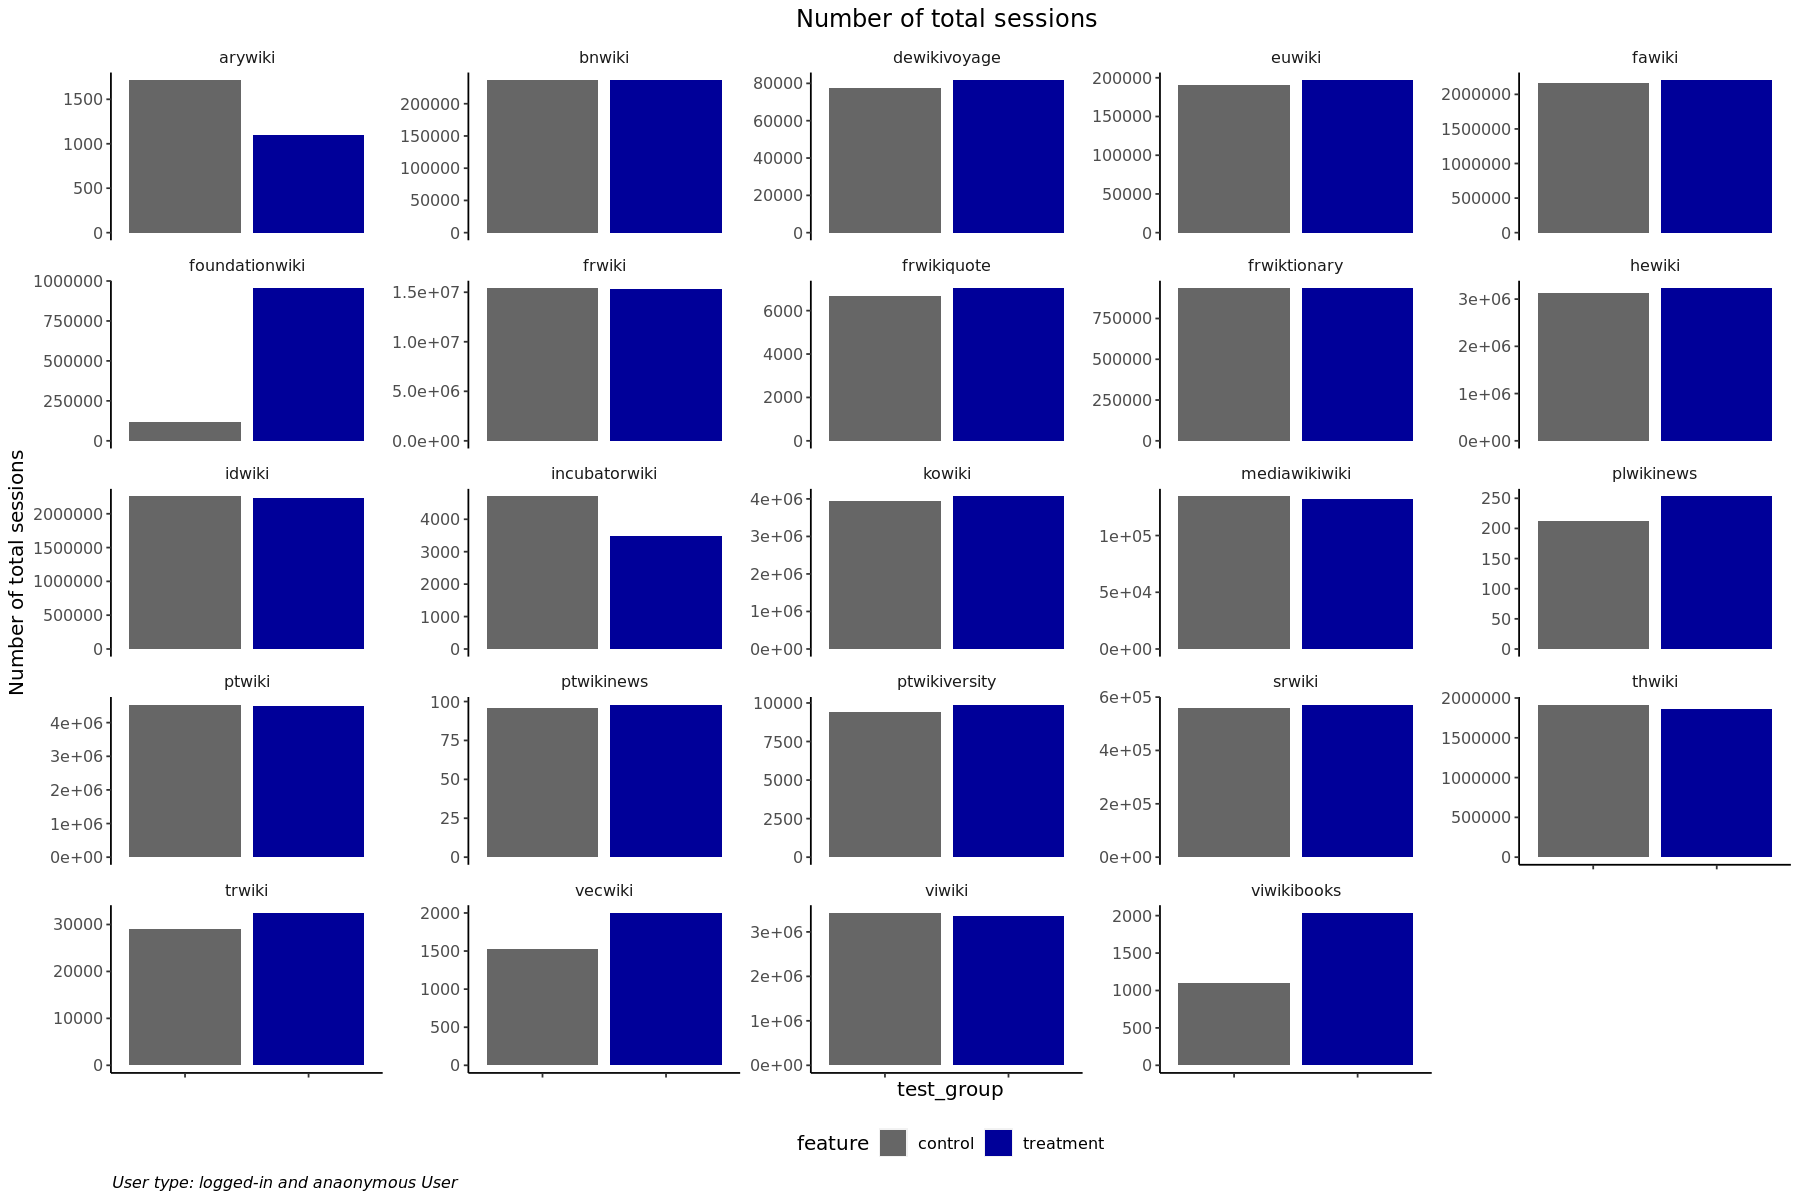

In [13]:
barchart_sessions_overall_2  <- df_pv  %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total sessions" ,
             title = "Number of total sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall_2

In [205]:
df_reading_time <- wmfdata::query_hive(query_reading_length)

Don't forget to authenticate with Kerberos using kinit



In [206]:
df_reading_time$event_date <- as.Date(df_reading_time$event_date)

In [209]:
summary(filter(df_reading_time, is_anon=='false'))

   event_date             wiki            test_group        session_token     
 Min.   :2022-05-26   Length:1662        Length:1662        Length:1662       
 1st Qu.:2022-05-31   Class :character   Class :character   Class :character  
 Median :2022-06-05   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2022-06-05                                                           
 3rd Qu.:2022-06-10                                                           
 Max.   :2022-06-15                                                           
   is_anon          sum_reading_length sum_page_length  
 Length:1662        Min.   :      66   Min.   :    200  
 Class :character   1st Qu.:   30508   1st Qu.:  10000  
 Mode  :character   Median :  131794   Median :  31500  
                    Mean   :  839656   Mean   : 124025  
                    3rd Qu.:  669804   3rd Qu.: 100000  
                    Max.   :40756371   Max.   :6143700  

In [210]:
summary(filter(df_reading_time, is_anon=='true'))

   event_date             wiki            test_group        session_token     
 Min.   :2022-05-26   Length:334599      Length:334599      Length:334599     
 1st Qu.:2022-05-31   Class :character   Class :character   Class :character  
 Median :2022-06-06   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2022-06-05                                                           
 3rd Qu.:2022-06-10                                                           
 Max.   :2022-06-15                                                           
   is_anon          sum_reading_length sum_page_length  
 Length:334599      Min.   :       1   Min.   :      1  
 Class :character   1st Qu.:   30662   1st Qu.:  10000  
 Mode  :character   Median :  108629   Median :  21000  
                    Mean   :  549457   Mean   :  61662  
                    3rd Qu.:  464763   3rd Qu.:  60000  
                    Max.   :80083588   Max.   :9837000  

__Note:__

Majority of the readers is in anonymous mode

In [212]:
df_reading_time_over_page_length <- df_reading_time %>%
    #filter(sum_reading_length!='NA' & sum_page_length>0) %>%
    group_by(wiki, test_group, is_anon) %>%
    summarize(read_time_avg=round(sum(sum_reading_length)/sum(sum_page_length),4), .groups='drop')

In [213]:
df_reading_time_over_page_length

wiki           test_group is_anon read_time_avg
1  arywiki        control    true     3.4177      
2  arywiki        treatment  true     8.0131      
3  bnwiki         control    false    1.3724      
4  bnwiki         control    true    10.0074      
5  bnwiki         treatment  false    9.9918      
6  bnwiki         treatment  true    10.1146      
7  dewikivoyage   control    false    7.5321      
8  dewikivoyage   control    true     8.2551      
9  dewikivoyage   treatment  false    5.8670      
10 dewikivoyage   treatment  true    11.6123      
11 euwiki         control    false   11.0437      
12 euwiki         control    true    23.1421      
13 euwiki         treatment  false   40.2365      
14 euwiki         treatment  true    18.8725      
15 fawiki         control    false    6.5700      
16 fawiki         control    true    12.1744      
17 fawiki         treatment  false    6.7215      
18 fawiki         treatment  true    12.6149      
19 foundationwiki control    true     1.3991      
20 foundationwiki treatment  false    3.9742      
21 foundationwiki treatment  true     1.2699      
22 frwiki         control    false    6.9265      
23 frwiki         control    true     7.3273      
24 frwiki         treatment  false    7.1395      
25 frwiki         treatment  true     6.9144      
26 frwikiquote    control    false   16.6457      
27 frwikiquote    control    true    12.3970      
28 frwikiquote    treatment  true     2.4718      
29 frwiktionary   control    false   12.6196      
30 frwiktionary   control    true    69.5489      
⋮  ⋮              ⋮          ⋮       ⋮            
52 mediawikiwiki  treatment  true    16.6407      
53 plwikinews     treatment  true    64.5350      
54 ptwiki         control    false    5.0943      
55 ptwiki         control    true    10.2322      
56 ptwiki         treatment  false    5.7516      
57 ptwiki         treatment  true    10.5792      
58 ptwikiversity  control    false   68.4139      
59 ptwikiversity  control    true    47.5621      
60 ptwikiversity  treatment  false   40.0410      
61 ptwikiversity  treatment  true    23.5070      
62 srwiki         control    false    2.5893      
63 srwiki         control    true     9.5096      
64 srwiki         treatment  false    5.8222      
65 srwiki         treatment  true     8.6310      
66 thwiki         control    false    5.3195      
67 thwiki         control    true     6.8824      
68 thwiki         treatment  false   11.2635      
69 thwiki         treatment  true     7.4075      
70 trwiki         control    false    4.0360      
71 trwiki         control    true     5.1505      
72 trwiki         treatment  false    5.9574      
73 trwiki         treatment  true     7.4136      
74 vecwiki        control    true     2.6439      
75 vecwiki        treatment  true    30.1309      
76 viwiki         control    false    6.6593      
77 viwiki         control    true     8.1346      
78 viwiki         treatment  false    8.4084      
79 viwiki         treatment  true     8.4355      
80 viwikibooks    control    true     2.6588      
81 viwikibooks    treatment  true    10.4290

### Logged-in User

In [214]:
df_r_loggedin <- df_reading_time_over_page_length %>%
            filter(is_anon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' 
                   & wiki!='vecwiki'
                   & wiki!='viwikibook'& wiki!='plwikinews'& wiki!='ptwikinews'& wiki!='viwikibook' )  

In [215]:
df_r_loggedin

wiki          test_group is_anon read_time_avg
1  bnwiki        control    false    1.3724      
2  bnwiki        treatment  false    9.9918      
3  dewikivoyage  control    false    7.5321      
4  dewikivoyage  treatment  false    5.8670      
5  euwiki        control    false   11.0437      
6  euwiki        treatment  false   40.2365      
7  fawiki        control    false    6.5700      
8  fawiki        treatment  false    6.7215      
9  frwiki        control    false    6.9265      
10 frwiki        treatment  false    7.1395      
11 frwikiquote   control    false   16.6457      
12 frwiktionary  control    false   12.6196      
13 frwiktionary  treatment  false   12.5604      
14 hewiki        control    false    7.8766      
15 hewiki        treatment  false    8.0965      
16 idwiki        control    false   12.6832      
17 idwiki        treatment  false    6.8142      
18 kowiki        control    false    7.0495      
19 kowiki        treatment  false    8.4294      
20 mediawikiwiki control    false   21.2185      
21 mediawikiwiki treatment  false   31.3582      
22 ptwiki        control    false    5.0943      
23 ptwiki        treatment  false    5.7516      
24 ptwikiversity control    false   68.4139      
25 ptwikiversity treatment  false   40.0410      
26 srwiki        control    false    2.5893      
27 srwiki        treatment  false    5.8222      
28 thwiki        control    false    5.3195      
29 thwiki        treatment  false   11.2635      
30 trwiki        control    false    4.0360      
31 trwiki        treatment  false    5.9574      
32 viwiki        control    false    6.6593      
33 viwiki        treatment  false    8.4084

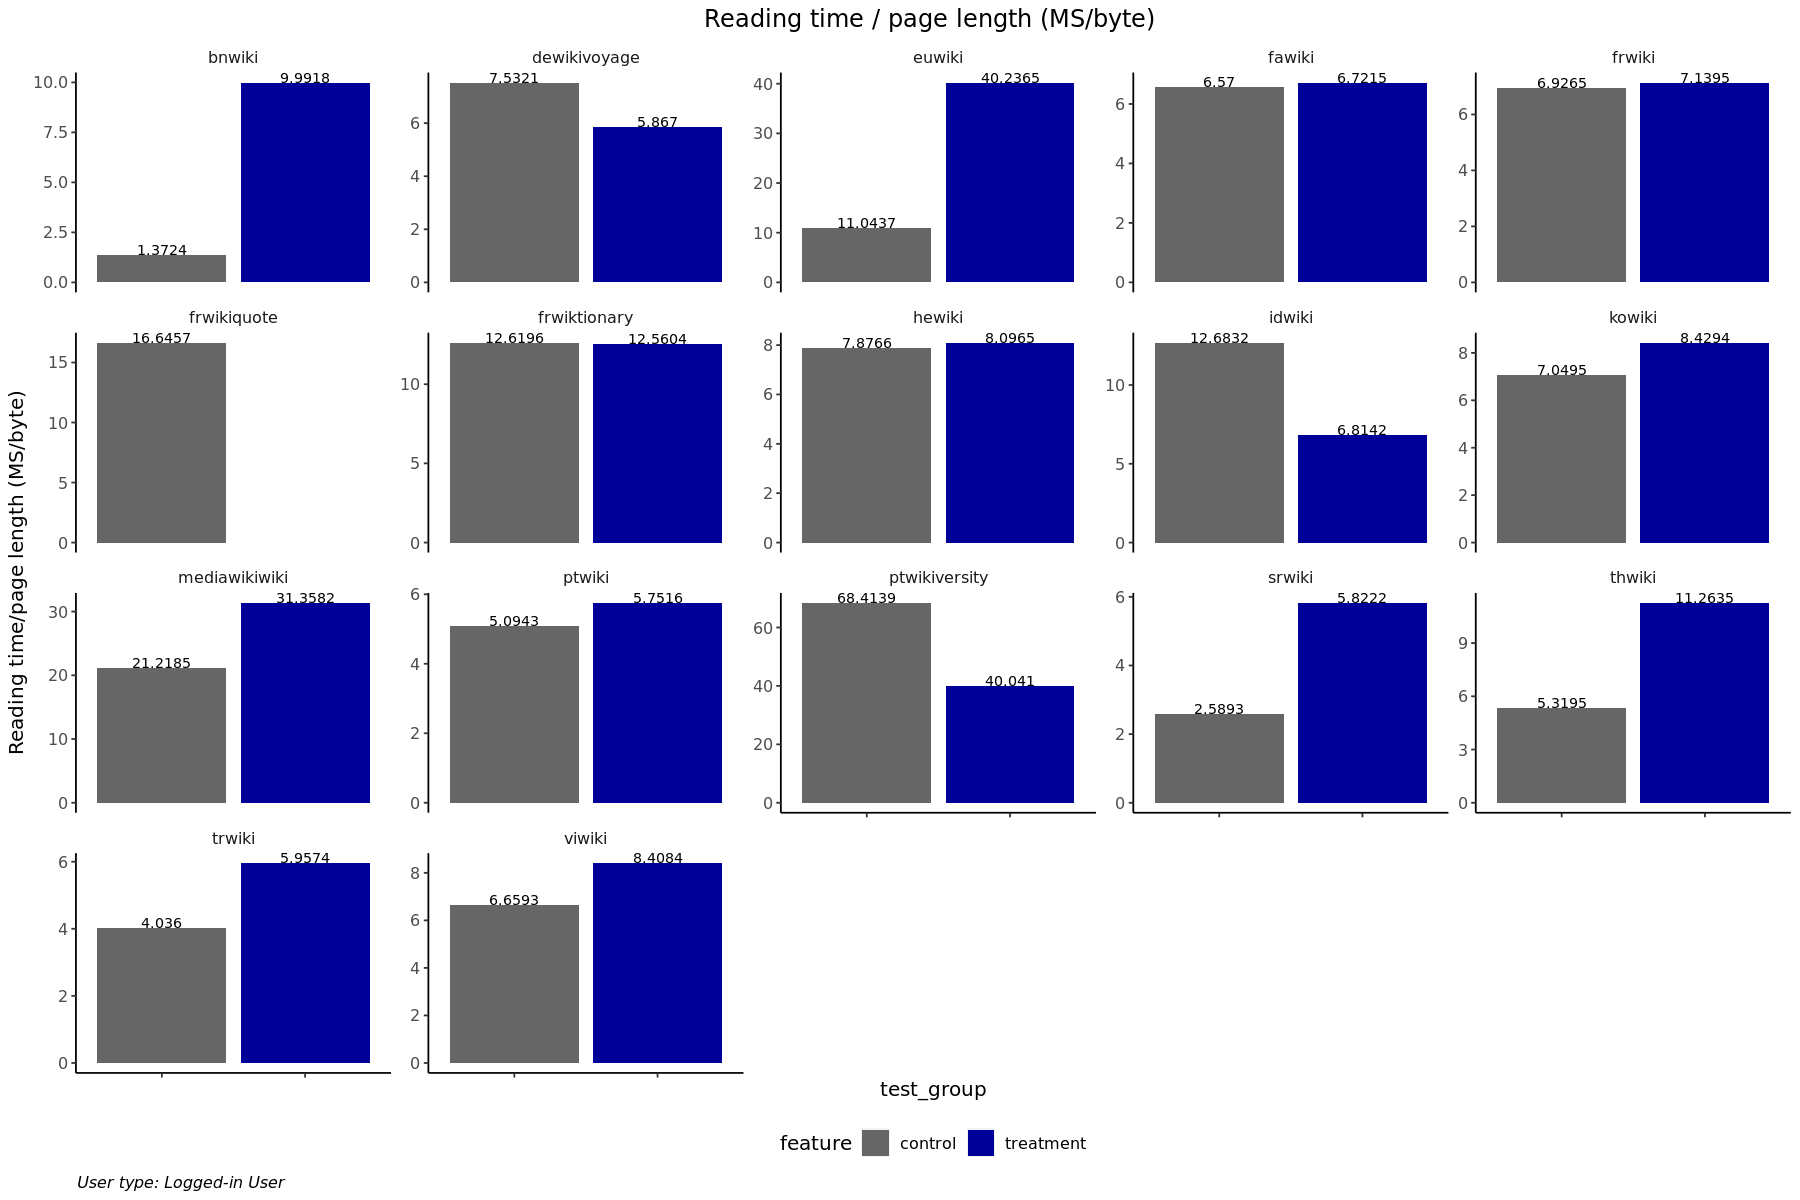

In [216]:
barchart_read_time_loggedin  <- df_r_loggedin %>%
        ggplot(aes(x = test_group, y= read_time_avg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(read_time_avg)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Reading time/page length (MS/byte)" ,
             title = "Reading time / page length (MS/byte) " ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_read_time_loggedin

In [220]:
df_r_loggedin_W <- df_r_loggedin %>%
    pivot_wider(names_from = test_group, values_from = read_time_avg, values_fill = 0)

In [221]:
df_r_loggedin_W <- df_r_loggedin_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [224]:
df_r_loggedin_W

wiki          is_anon control treatment pct_change
1  bnwiki        false    1.3724  9.9918    628.05   
2  dewikivoyage  false    7.5321  5.8670    -22.11   
3  euwiki        false   11.0437 40.2365    264.34   
4  fawiki        false    6.5700  6.7215      2.31   
5  frwiki        false    6.9265  7.1395      3.08   
6  frwikiquote   false   16.6457  0.0000   -100.00   
7  frwiktionary  false   12.6196 12.5604     -0.47   
8  hewiki        false    7.8766  8.0965      2.79   
9  idwiki        false   12.6832  6.8142    -46.27   
10 kowiki        false    7.0495  8.4294     19.57   
11 mediawikiwiki false   21.2185 31.3582     47.79   
12 ptwiki        false    5.0943  5.7516     12.90   
13 ptwikiversity false   68.4139 40.0410    -41.47   
14 srwiki        false    2.5893  5.8222    124.86   
15 thwiki        false    5.3195 11.2635    111.74   
16 trwiki        false    4.0360  5.9574     47.61   
17 viwiki        false    6.6593  8.4084     26.27

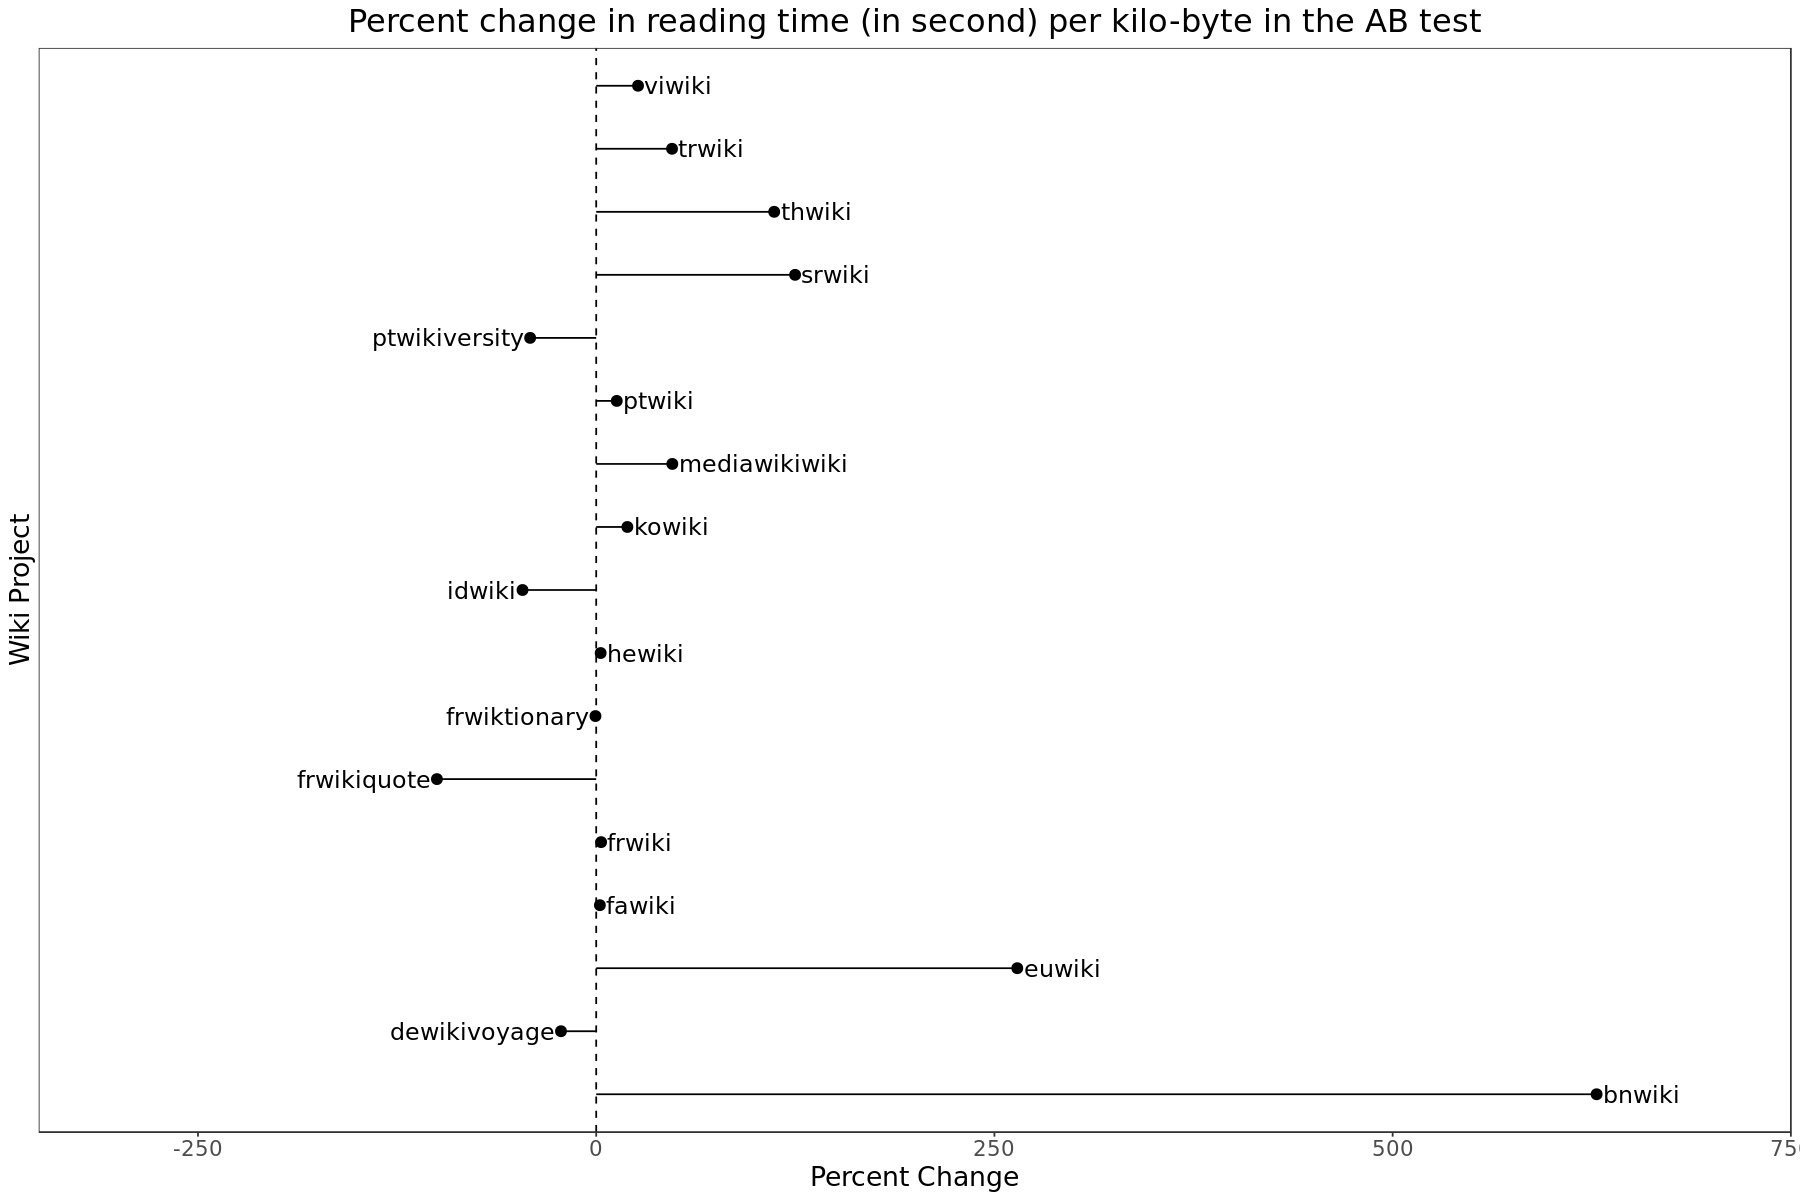

In [225]:
pct_g <- df_r_loggedin_W %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 700)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in reading time (in second) per kilo-byte in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For logged-in readers:
On 5 wikis, reading time in treatment groups is shorter than in control group.  
On 12 wiki, reading time in treatment groups is longer than in control group.   

Do not observe new ToC reduced the reader's reading time.


### Anonymous User

In [217]:
df_r_anon <- df_reading_time_over_page_length %>%
            filter(is_anon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' 
                   & wiki!='vecwiki'
                   & wiki!='viwikibook'& wiki!='plwikinews'& wiki!='ptwikinews'& wiki!='viwikibook' )      

In [218]:
df_r_anon 

wiki          test_group is_anon read_time_avg
1  bnwiki        control    true    10.0074      
2  bnwiki        treatment  true    10.1146      
3  dewikivoyage  control    true     8.2551      
4  dewikivoyage  treatment  true    11.6123      
5  euwiki        control    true    23.1421      
6  euwiki        treatment  true    18.8725      
7  fawiki        control    true    12.1744      
8  fawiki        treatment  true    12.6149      
9  frwiki        control    true     7.3273      
10 frwiki        treatment  true     6.9144      
11 frwikiquote   control    true    12.3970      
12 frwikiquote   treatment  true     2.4718      
13 frwiktionary  control    true    69.5489      
14 frwiktionary  treatment  true    46.3304      
15 hewiki        control    true    11.7172      
16 hewiki        treatment  true    11.4568      
17 idwiki        control    true    19.2986      
18 idwiki        treatment  true    20.1290      
19 kowiki        control    true    16.8761      
20 kowiki        treatment  true    15.5490      
21 mediawikiwiki control    true    13.1234      
22 mediawikiwiki treatment  true    16.6407      
23 ptwiki        control    true    10.2322      
24 ptwiki        treatment  true    10.5792      
25 ptwikiversity control    true    47.5621      
26 ptwikiversity treatment  true    23.5070      
27 srwiki        control    true     9.5096      
28 srwiki        treatment  true     8.6310      
29 thwiki        control    true     6.8824      
30 thwiki        treatment  true     7.4075      
31 trwiki        control    true     5.1505      
32 trwiki        treatment  true     7.4136      
33 viwiki        control    true     8.1346      
34 viwiki        treatment  true     8.4355      
35 viwikibooks   control    true     2.6588      
36 viwikibooks   treatment  true    10.4290

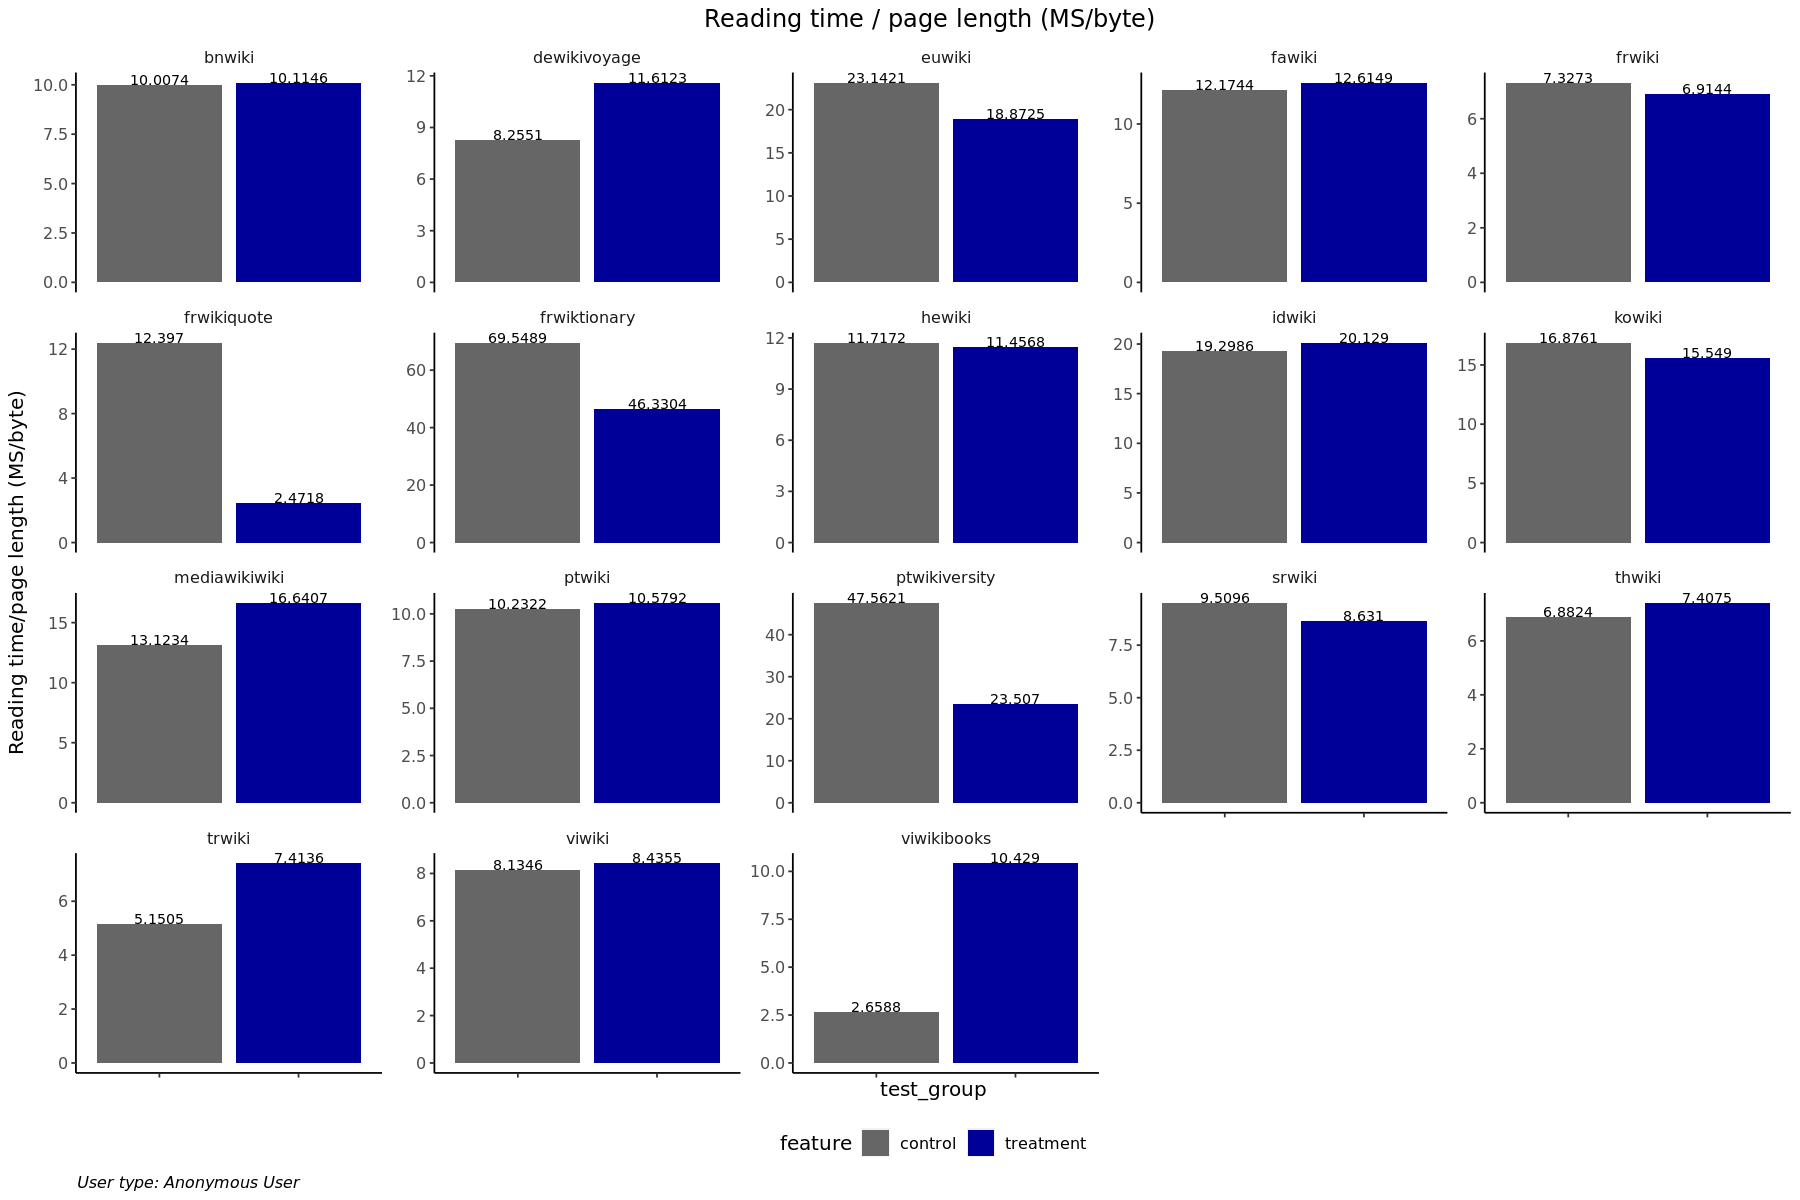

In [219]:
barchart_read_time_anon  <- df_r_anon %>%
        ggplot(aes(x = test_group, y= read_time_avg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(read_time_avg)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Reading time/page length (MS/byte)" ,
             title = "Reading time / page length (MS/byte) " ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_read_time_anon

In [226]:
df_r_anon_W <- df_r_anon %>%
    pivot_wider(names_from = test_group, values_from = read_time_avg, values_fill = 0)

In [227]:
df_r_anon_W <- df_r_anon_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [229]:
df_r_anon_W

wiki          is_anon control treatment pct_change
1  bnwiki        true    10.0074 10.1146     1.07    
2  dewikivoyage  true     8.2551 11.6123    40.67    
3  euwiki        true    23.1421 18.8725   -18.45    
4  fawiki        true    12.1744 12.6149     3.62    
5  frwiki        true     7.3273  6.9144    -5.64    
6  frwikiquote   true    12.3970  2.4718   -80.06    
7  frwiktionary  true    69.5489 46.3304   -33.38    
8  hewiki        true    11.7172 11.4568    -2.22    
9  idwiki        true    19.2986 20.1290     4.30    
10 kowiki        true    16.8761 15.5490    -7.86    
11 mediawikiwiki true    13.1234 16.6407    26.80    
12 ptwiki        true    10.2322 10.5792     3.39    
13 ptwikiversity true    47.5621 23.5070   -50.58    
14 srwiki        true     9.5096  8.6310    -9.24    
15 thwiki        true     6.8824  7.4075     7.63    
16 trwiki        true     5.1505  7.4136    43.94    
17 viwiki        true     8.1346  8.4355     3.70    
18 viwikibooks   true     2.6588 10.4290   292.24

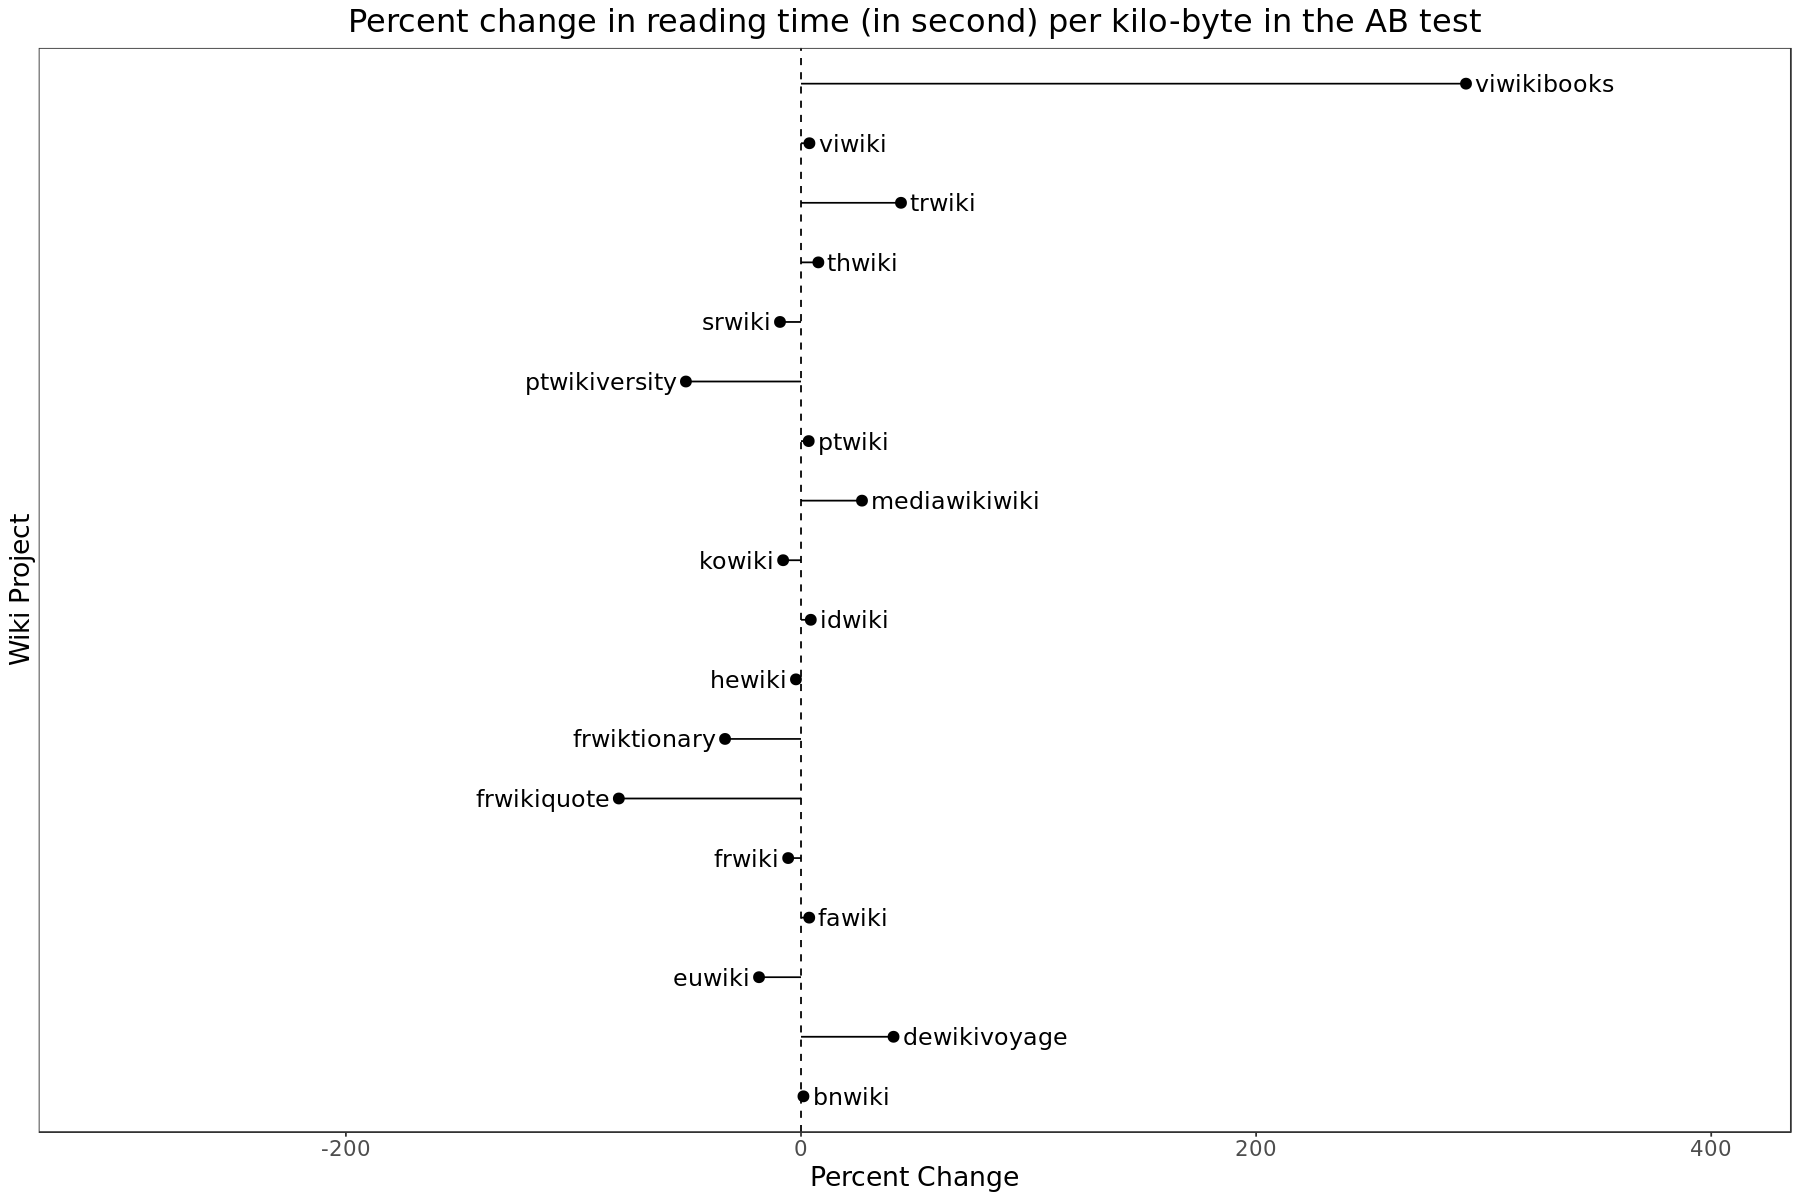

In [231]:
pct_g <- df_r_anon_W %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 400)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in reading time (in second) per kilo-byte in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For anonymous readers:
On 8 wikis, reading time in treatment groups is shorter than in control group.
On 10 wiki, reading time in treatment groups is longer than in control group. 

Do not observe new ToC reduced the reader's reading time.


__Summary:__. 

This question is for curiosity observation. Hypothesis is that the new table of contents would decrease the time people spend scrolling/scrolling quickly. Because a user friedly interface can help reader quickly locate their interested content, resulting in a shorter reading time. 

The hypothesis is NOT supported by data.

## Clicks on ToC by viewport size

### Unique sessions which have clicks on ToC by viewport size bucket

In [60]:
query_click_session <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
AND NOT is_bot
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group,
event.name AS event_name,  event.viewportSizeBucket AS view_size,
count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t3.year=2022 and t3.month IN (5,6)
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t4.session_dt <= t3.meta.dt
AND event.name IN ( 'ui.toc', 'ui.sidebar-toc')
AND event.action='click' AND event.skinversion=2 
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name,  event.viewportSizeBucket
"

In [61]:
df_click_session <- wmfdata::query_hive(query_click_session)

Don't forget to authenticate with Kerberos using kinit



In [124]:
df_click_session_aggr <- df_click_session %>% 
     group_by(wiki, test_group, isanon, event_name, view_size) %>%
     summarize(num_sessions=n_distinct(session_id),total_clicks=sum(clicks), .groups='drop')

In [125]:
filter(df_click_session_aggr, wiki=='frwiki'&isanon=='false' )

wiki   test_group isanon event_name     view_size     num_sessions
1  frwiki control    false  ui.toc         >2000px        156        
2  frwiki control    false  ui.toc         1000px-1199px  489        
3  frwiki control    false  ui.toc         1200px-2000px 4137        
4  frwiki control    false  ui.toc         320px-719px    126        
5  frwiki control    false  ui.toc         720px-999px    268        
6  frwiki treatment  false  ui.sidebar-toc >2000px         15        
7  frwiki treatment  false  ui.sidebar-toc 1000px-1199px   83        
8  frwiki treatment  false  ui.sidebar-toc 1200px-2000px  673        
9  frwiki treatment  false  ui.sidebar-toc 320px-719px      1        
10 frwiki treatment  false  ui.toc         <320px           2        
11 frwiki treatment  false  ui.toc         >2000px         37        
12 frwiki treatment  false  ui.toc         1000px-1199px  140        
13 frwiki treatment  false  ui.toc         1200px-2000px 1250        
14 frwiki treatment  false  ui.toc         320px-719px     34        
15 frwiki treatment  false  ui.toc         720px-999px     67        
   total_clicks
1   252        
2   855        
3  6761        
4   187        
5   373        
6    40        
7   192        
8  1406        
9     1        
10    2        
11   49        
12  197        
13 1841        
14   42        
15   97

In [126]:
filter(df_click_session_aggr, wiki=='frwiki'&isanon=='true' )

wiki   test_group isanon event_name     view_size     num_sessions
1  frwiki control    true   ui.sidebar-toc 1200px-2000px      7      
2  frwiki control    true   ui.toc         <320px            76      
3  frwiki control    true   ui.toc         >2000px         4361      
4  frwiki control    true   ui.toc         1000px-1199px  24625      
5  frwiki control    true   ui.toc         1200-2000          1      
6  frwiki control    true   ui.toc         1200px-2000px 183868      
7  frwiki control    true   ui.toc         320px-719px     3074      
8  frwiki control    true   ui.toc         720px-999px     9101      
9  frwiki treatment  true   ui.sidebar-toc <320px             4      
10 frwiki treatment  true   ui.sidebar-toc >2000px          457      
11 frwiki treatment  true   ui.sidebar-toc 1000px-1199px   5311      
12 frwiki treatment  true   ui.sidebar-toc 1200px-2000px  25154      
13 frwiki treatment  true   ui.sidebar-toc 320px-719px       49      
14 frwiki treatment  true   ui.sidebar-toc 720px-999px      117      
15 frwiki treatment  true   ui.toc         <320px            13      
16 frwiki treatment  true   ui.toc         >2000px          785      
17 frwiki treatment  true   ui.toc         1000px-1199px   4043      
18 frwiki treatment  true   ui.toc         1200px-2000px  34106      
19 frwiki treatment  true   ui.toc         320px-719px      610      
20 frwiki treatment  true   ui.toc         720px-999px     1677      
   total_clicks
1       8      
2      89      
3    4979      
4   30025      
5       1      
6  220673      
7    3805      
8   11058      
9       4      
10    698      
11   8663      
12  42990      
13     64      
14    142      
15     14      
16    897      
17   4821      
18  39955      
19    713      
20   1982

In [127]:
df_click_session_aggr <- df_click_session_aggr %>%
    mutate(
        view_size_lab = factor(
            view_size , 
            levels = c("<320px", "320px-719px", "720px-999px","1000px-1199px", "1200px-2000px", ">2000px"),
            labels = c("<320px", "<720px", "<1000px","<1200px", "<2000px", "above" )
              )
          )

In [128]:
head(df_click_session_aggr)

wiki    test_group isanon event_name     view_size     num_sessions
1 arywiki control    true   ui.toc         1000px-1199px  1          
2 arywiki control    true   ui.toc         1200px-2000px  2          
3 arywiki treatment  true   ui.sidebar-toc 1200px-2000px  2          
4 bnwiki  control    false  ui.toc         1000px-1199px  6          
5 bnwiki  control    false  ui.toc         1200px-2000px 29          
6 bnwiki  control    false  ui.toc         720px-999px    4          
  total_clicks view_size_lab
1  1           <1200px      
2  2           <2000px      
3  2           <2000px      
4  7           <1200px      
5 39           <2000px      
6  5           <1000px

In [105]:
options(repr.plot.width = 15, repr.plot.height = 15)

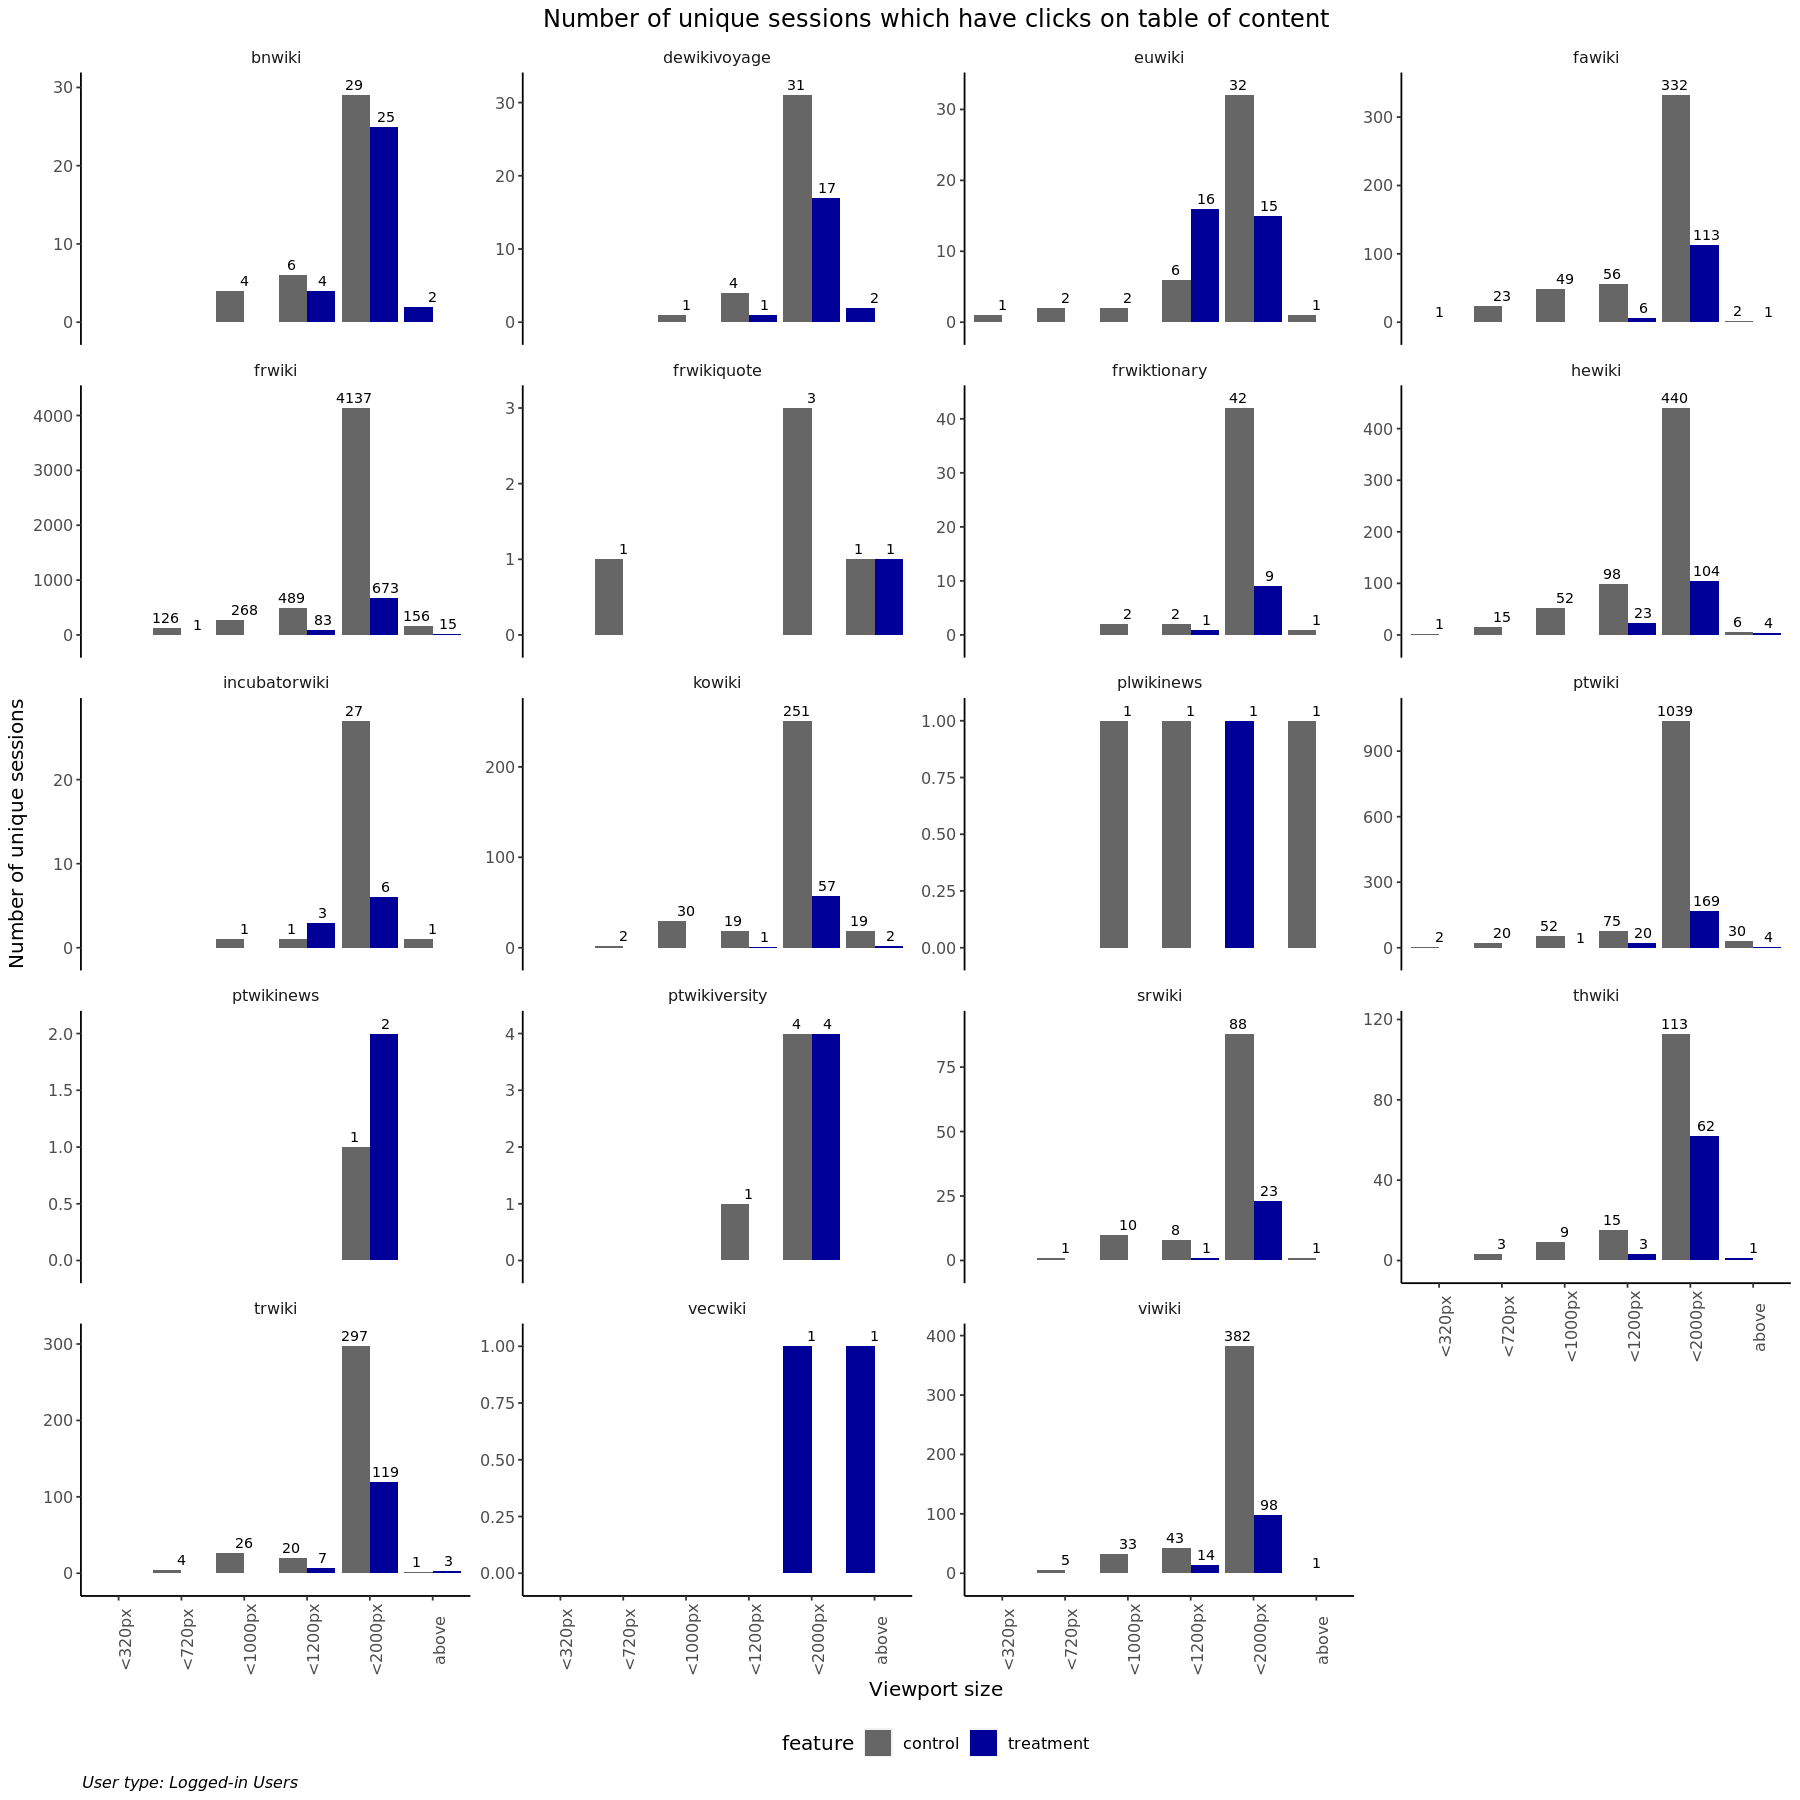

In [121]:
col_click_sessions_loggedin  <- df_click_session_aggr  %>%
        filter(isanon=='false'& wiki!='foundationwiki') %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
        ggplot(aes(x = view_size_lab, y= num_sessions, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +        
        geom_text(aes(label = paste(num_sessions)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~wiki, ncol=4, scale = 'free_y' ) +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.1)) +
        labs (
              y = "Number of unique sessions" ,
             x = "Viewport size",
             title = "Number of unique sessions which have clicks on table of content" ,
             caption = "User type: Logged-in Users" ) +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
col_click_sessions_loggedin 

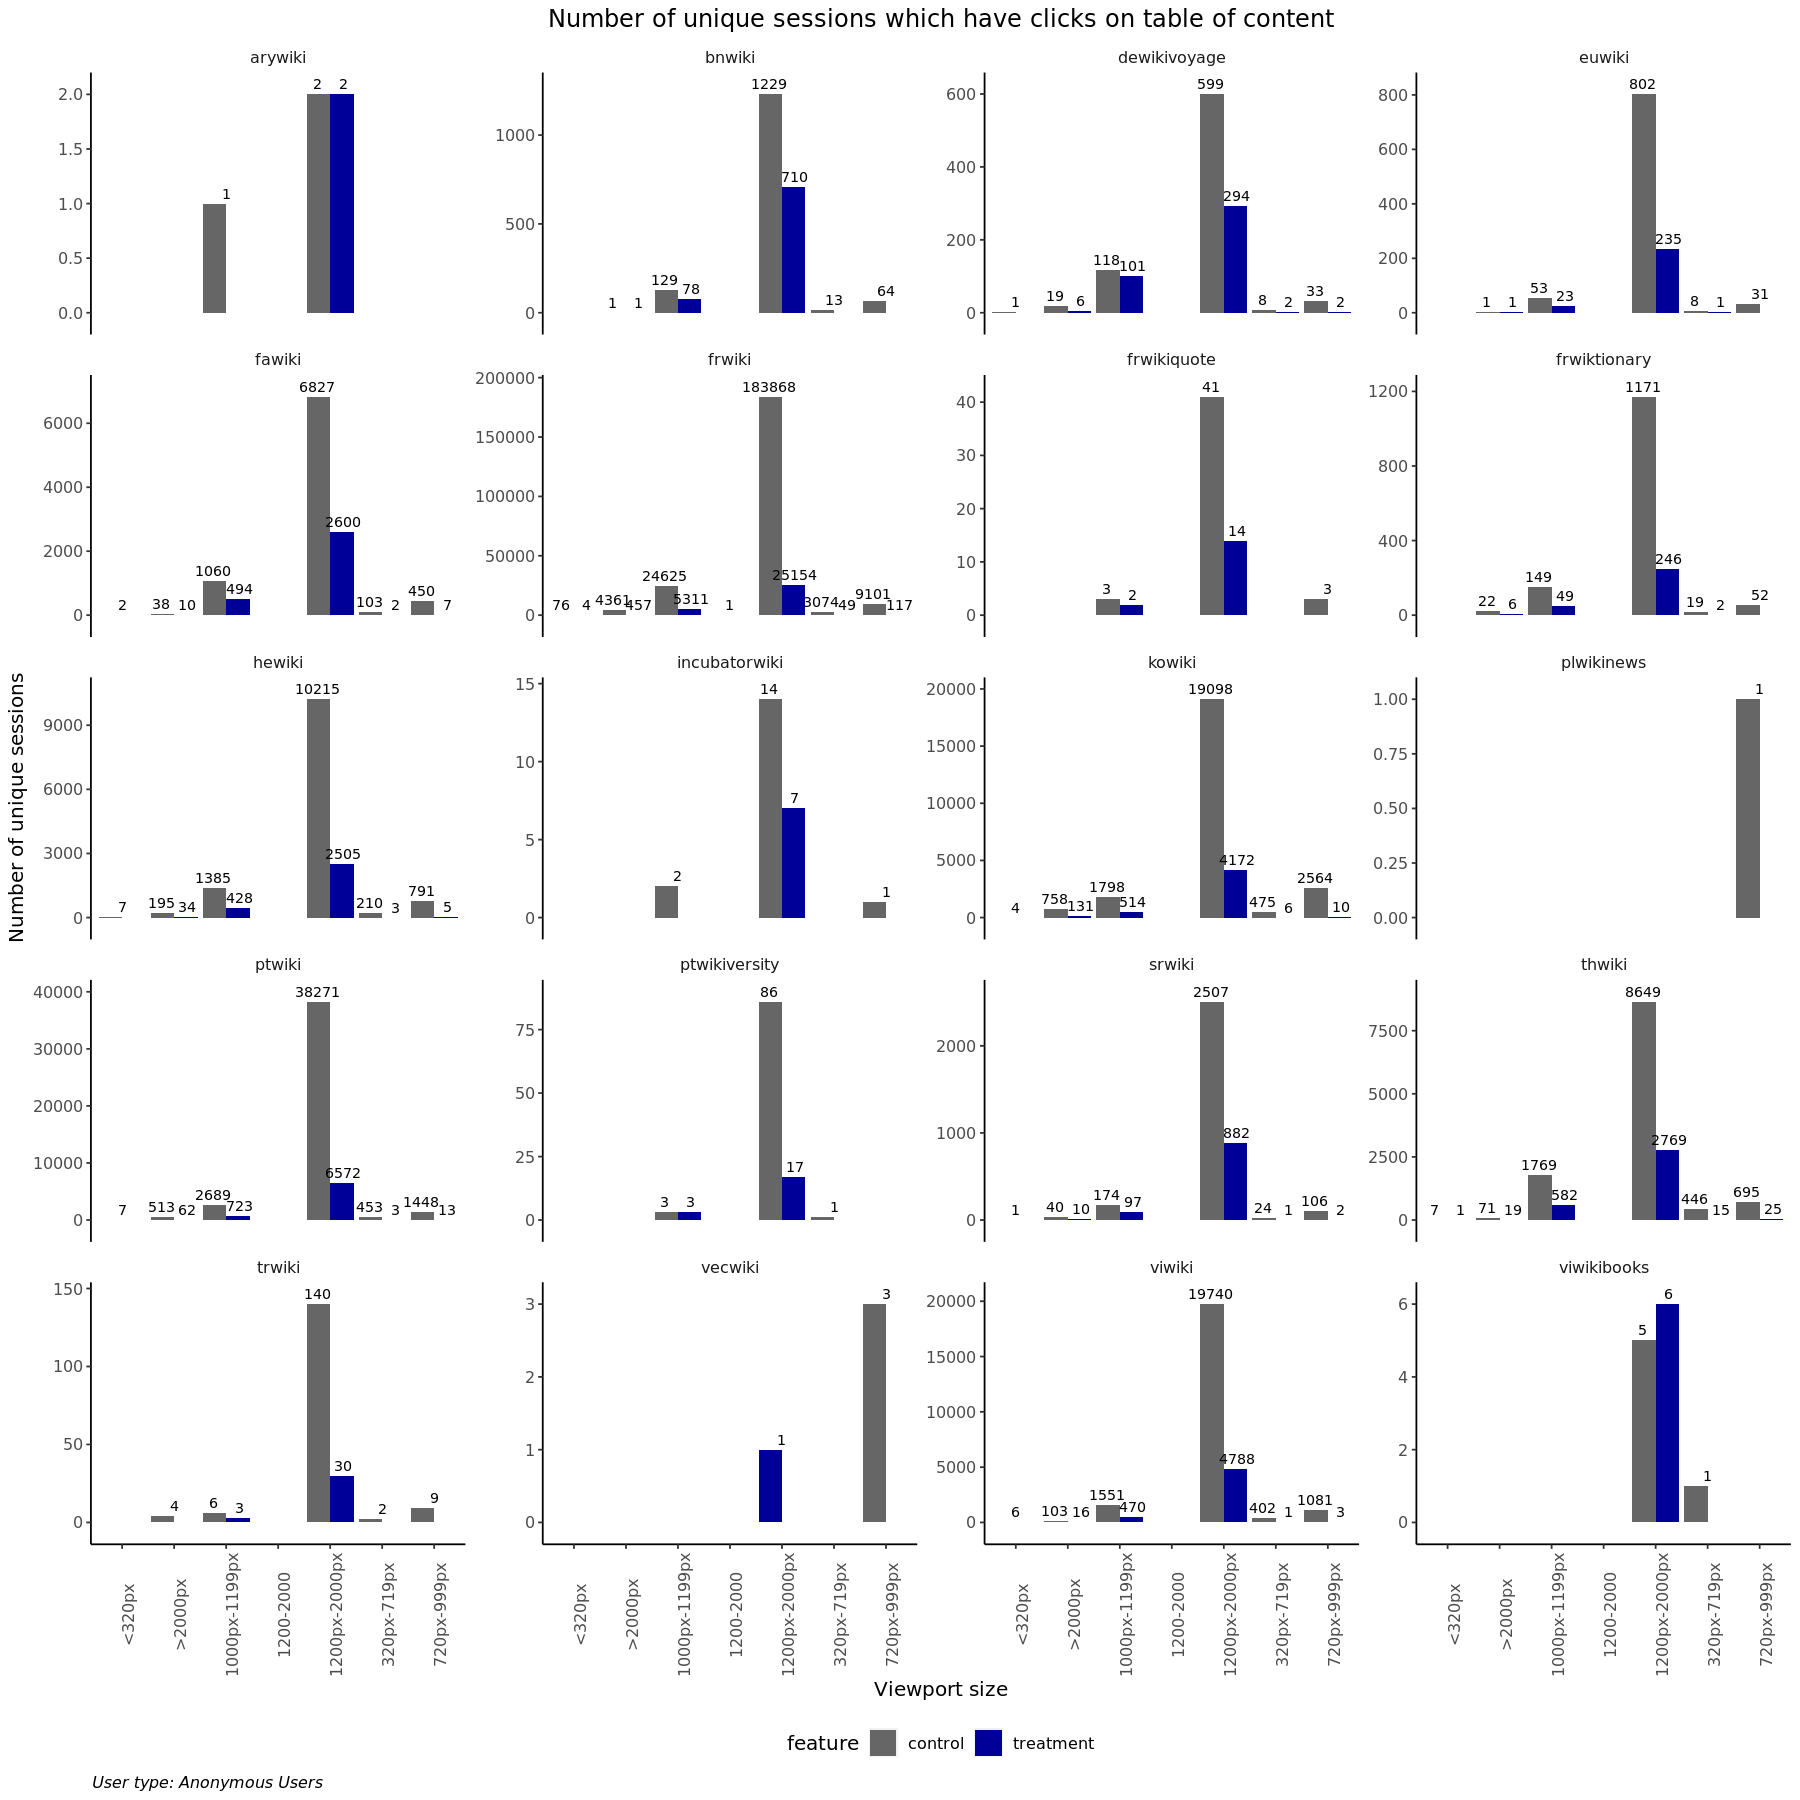

In [122]:
col_click_sessions_anon  <- df_click_session_aggr  %>%
        filter(isanon=='true' & wiki!='foundationwiki')  %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
        ggplot(aes(x = view_size, y= num_sessions, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +       
        geom_text(aes(label = paste(num_sessions)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~wiki, ncol=4, scale = 'free_y') +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.1)) +
        labs (
              y = "Number of unique sessions" ,
              x = "Viewport size",
             title = "Number of unique sessions which have clicks on table of content" ,
             caption = "User type: Anonymous Users" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
col_click_sessions_anon 

### Clicks on ToC by viewport size bucket

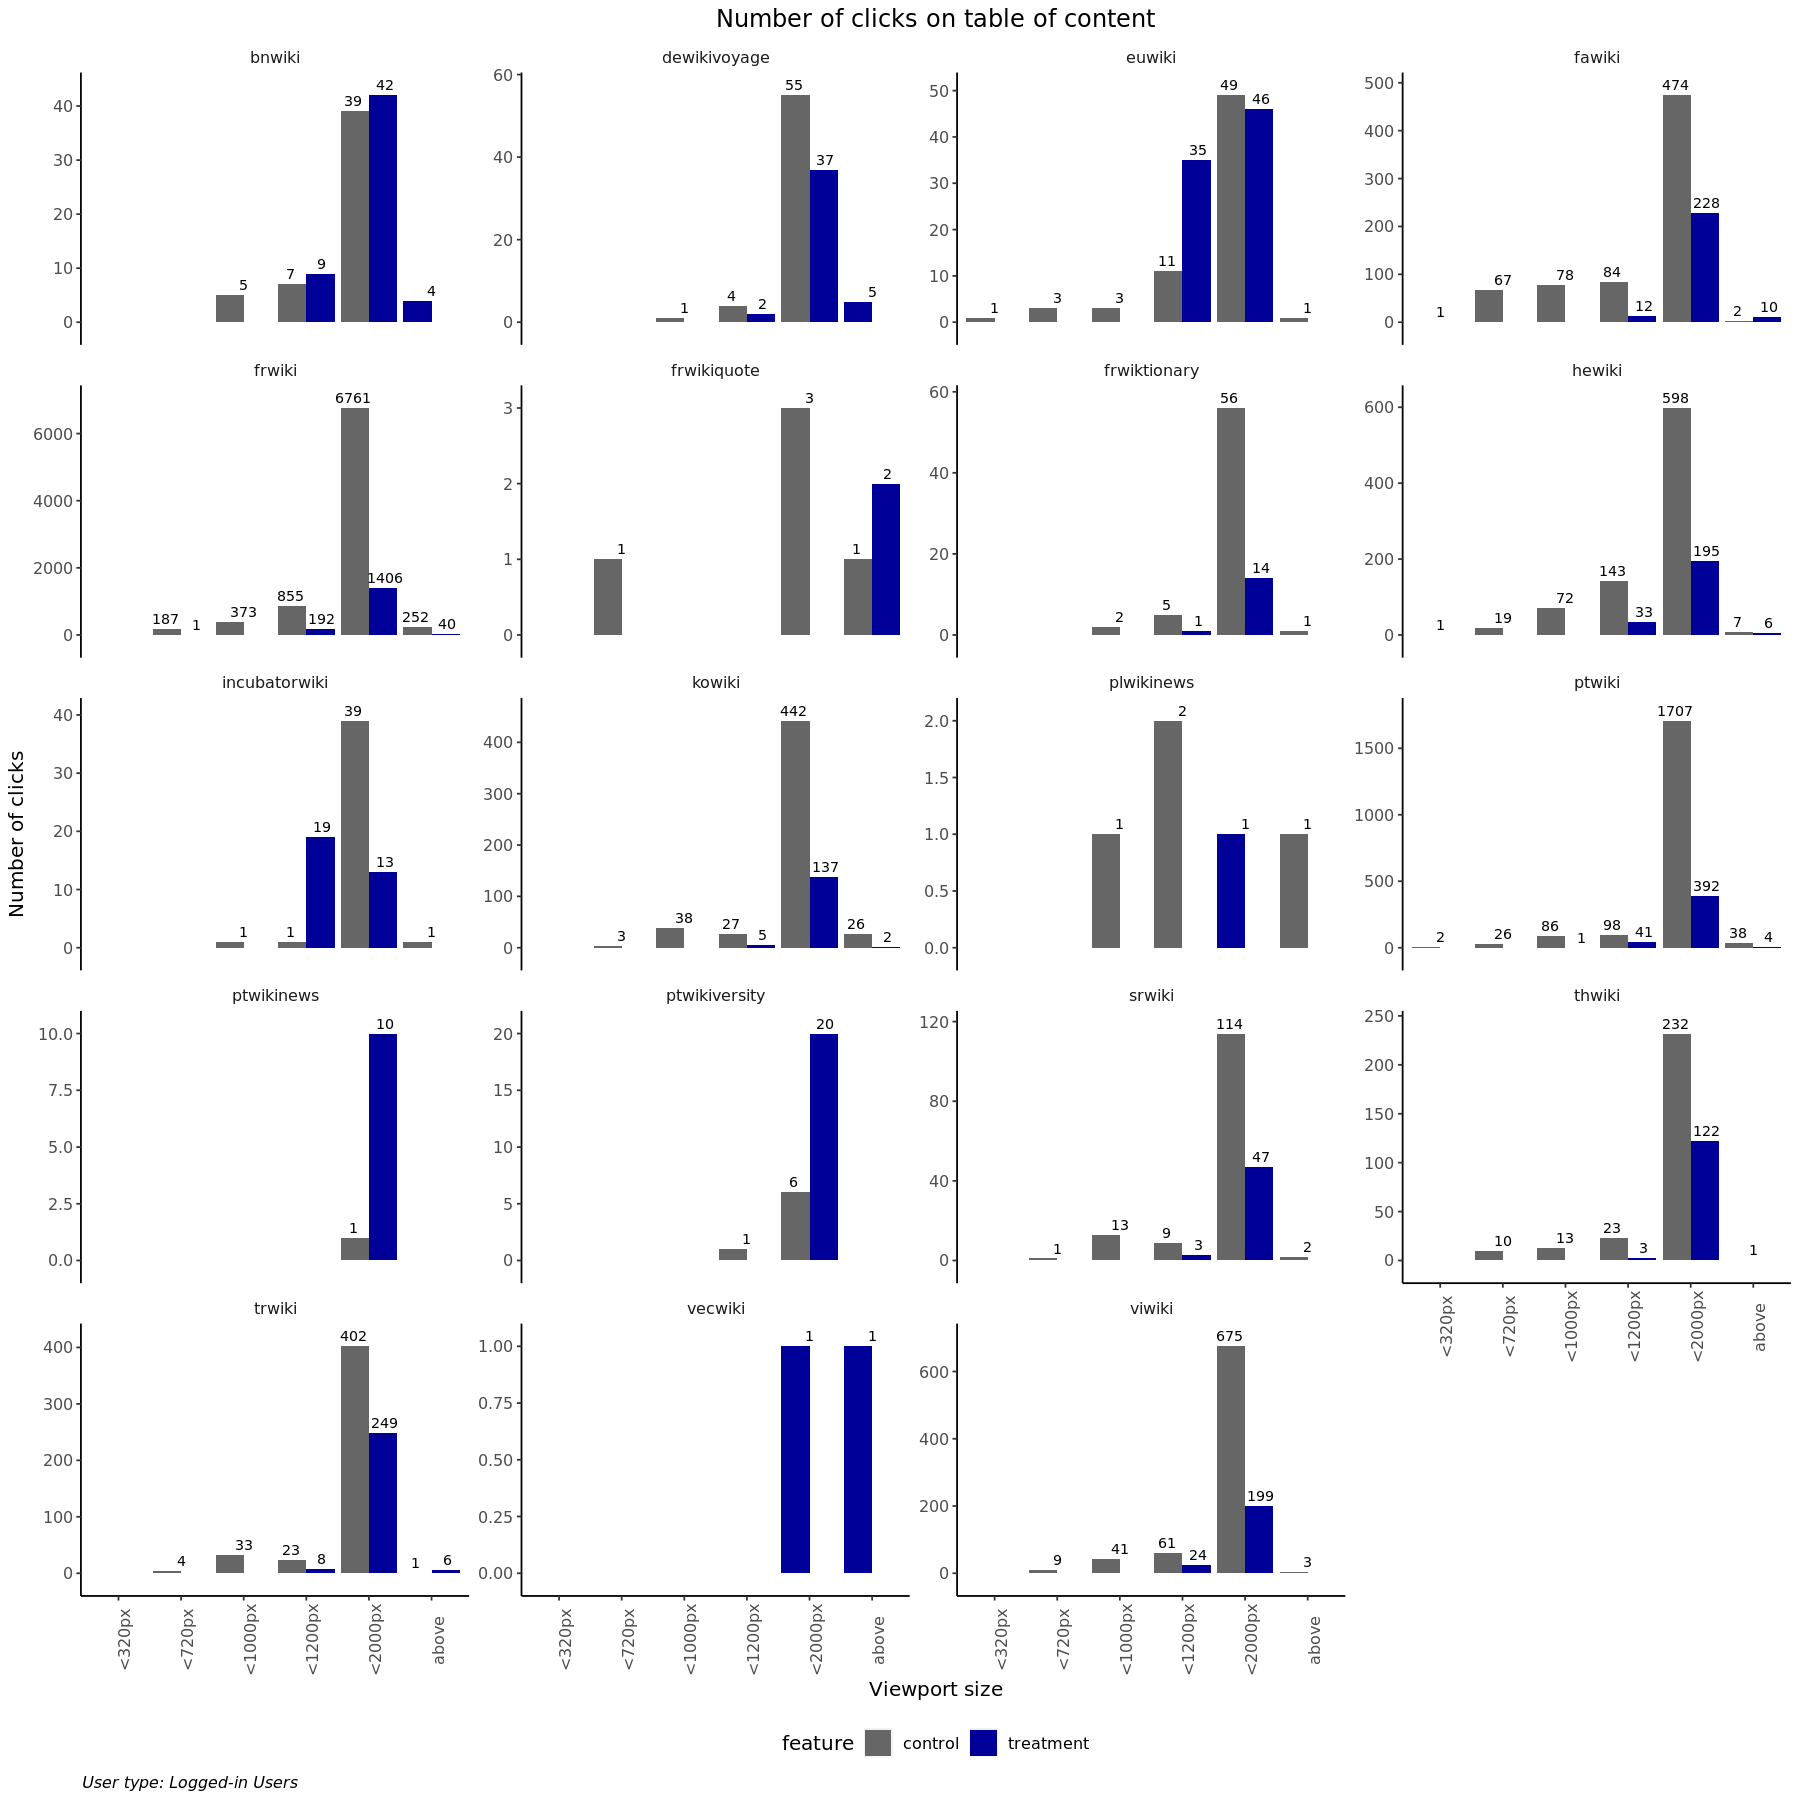

In [129]:
col_clicks_loggedin  <- df_click_session_aggr  %>%
        filter(isanon=='false'& wiki!='foundationwiki') %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
        ggplot(aes(x = view_size_lab, y= total_clicks, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +        
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~wiki, ncol=4, scale = 'free_y' ) +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.1)) +
        labs (
              y = "Number of clicks" ,
             x = "Viewport size",
             title = "Number of clicks on table of content" ,
             caption = "User type: Logged-in Users" ) +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
col_clicks_loggedin 

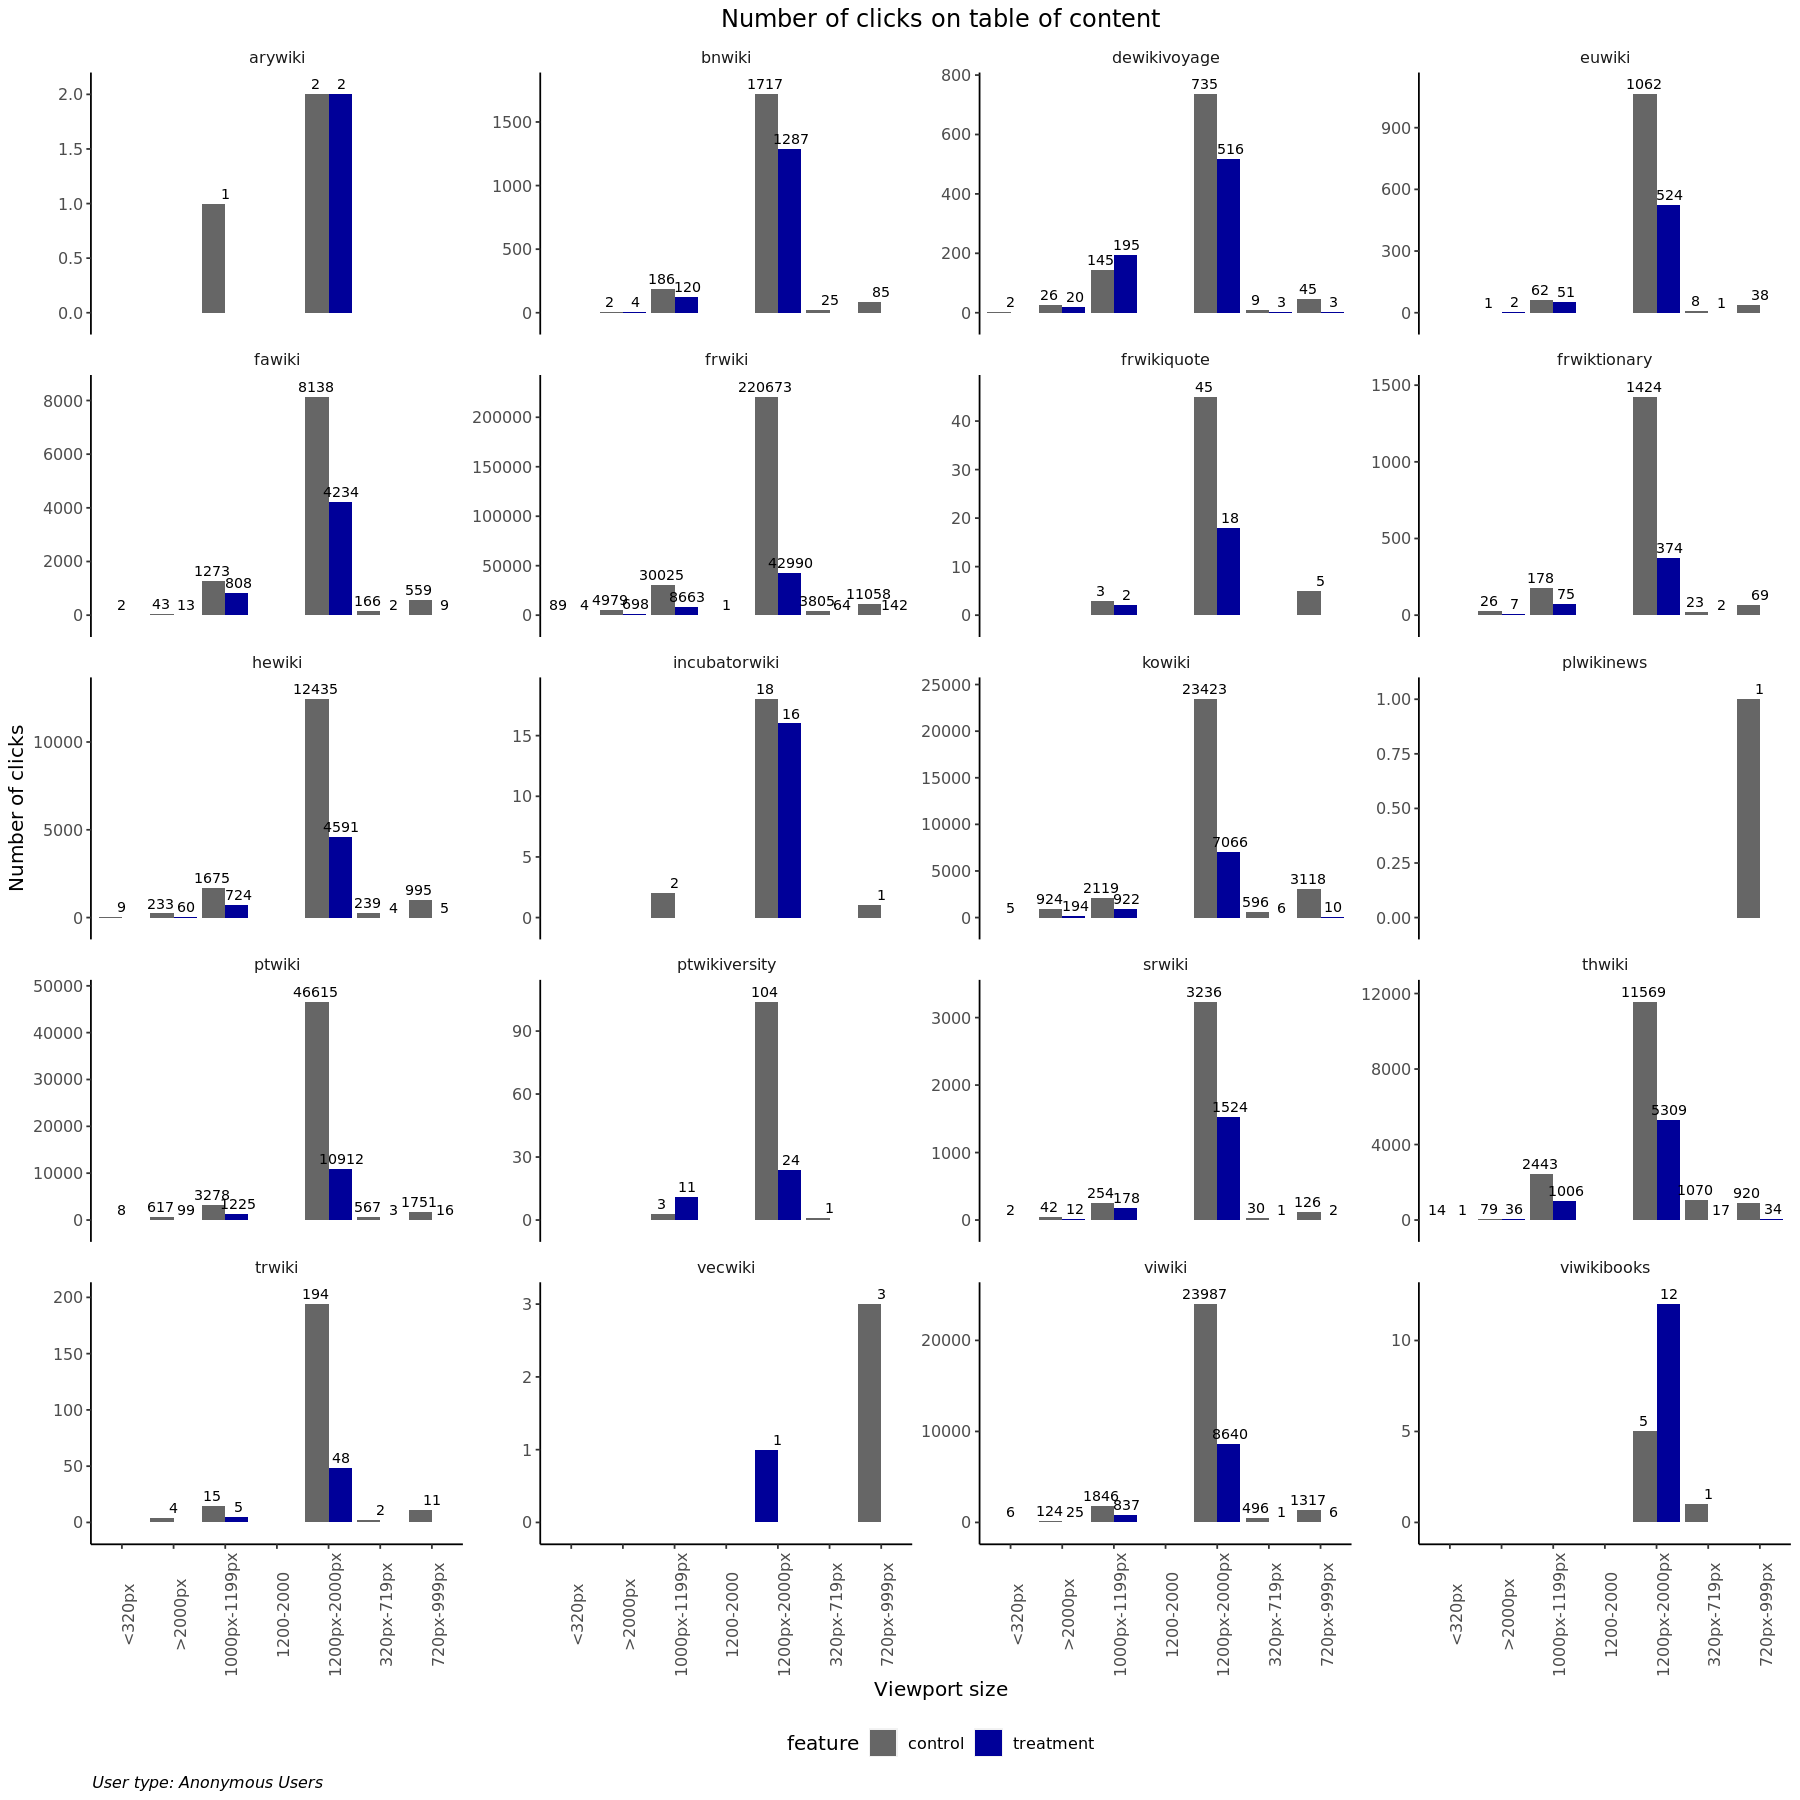

In [130]:
col_clicks_anon  <- df_click_session_aggr  %>%
        filter(isanon=='true' & wiki!='foundationwiki')  %>%
        filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
        ggplot(aes(x = view_size, y= total_clicks, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +       
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~wiki, ncol=4, scale = 'free_y') +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.1)) +
        labs (
              y = "Number of clicks" ,
              x = "Viewport size",
             title = "Number of clicks on table of content" ,
             caption = "User type: Anonymous Users" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
col_clicks_anon 

__Check whether the session was duplicated assigned to `ui.sidebar-toc` and `ui.toc`__

In [198]:
df_test <- df_click_session %>%
    group_by(session_id, wiki, isanon,test_group) %>%
    summarize(n_event_name=n_distinct(event_name), .groups='drop')

In [214]:
 df_click_session %>%
  filter(wiki!='foundationwiki') %>%
  filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
  filter(test_group=='treatment'&isanon=='false') %>%
  summary()

  session_id            wiki              isanon           test_group       
 Length:1719        Length:1719        Length:1719        Length:1719       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  event_name         view_size             clicks      
 Length:1719        Length:1719        Min.   : 1.000  
 Class :character   Class :character   1st Qu.: 1.000  
 Mode  :character   Mode  :character   Median : 1.000  
                                       Mean   : 2.111  
                                       3rd Qu.: 2.000  
                                       Max.   :76.000  

In [215]:
 df_click_session %>%
  filter(wiki!='foundationwiki') %>%
  filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
  filter(test_group=='control'&isanon=='false') %>%
  summary()

  session_id            wiki              isanon           test_group       
 Length:9060        Length:9060        Length:9060        Length:9060       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  event_name         view_size             clicks      
 Length:9060        Length:9060        Min.   : 1.000  
 Class :character   Class :character   1st Qu.: 1.000  
 Mode  :character   Mode  :character   Median : 1.000  
                                       Mean   : 1.594  
                                       3rd Qu.: 2.000  
                                       Max.   :63.000  

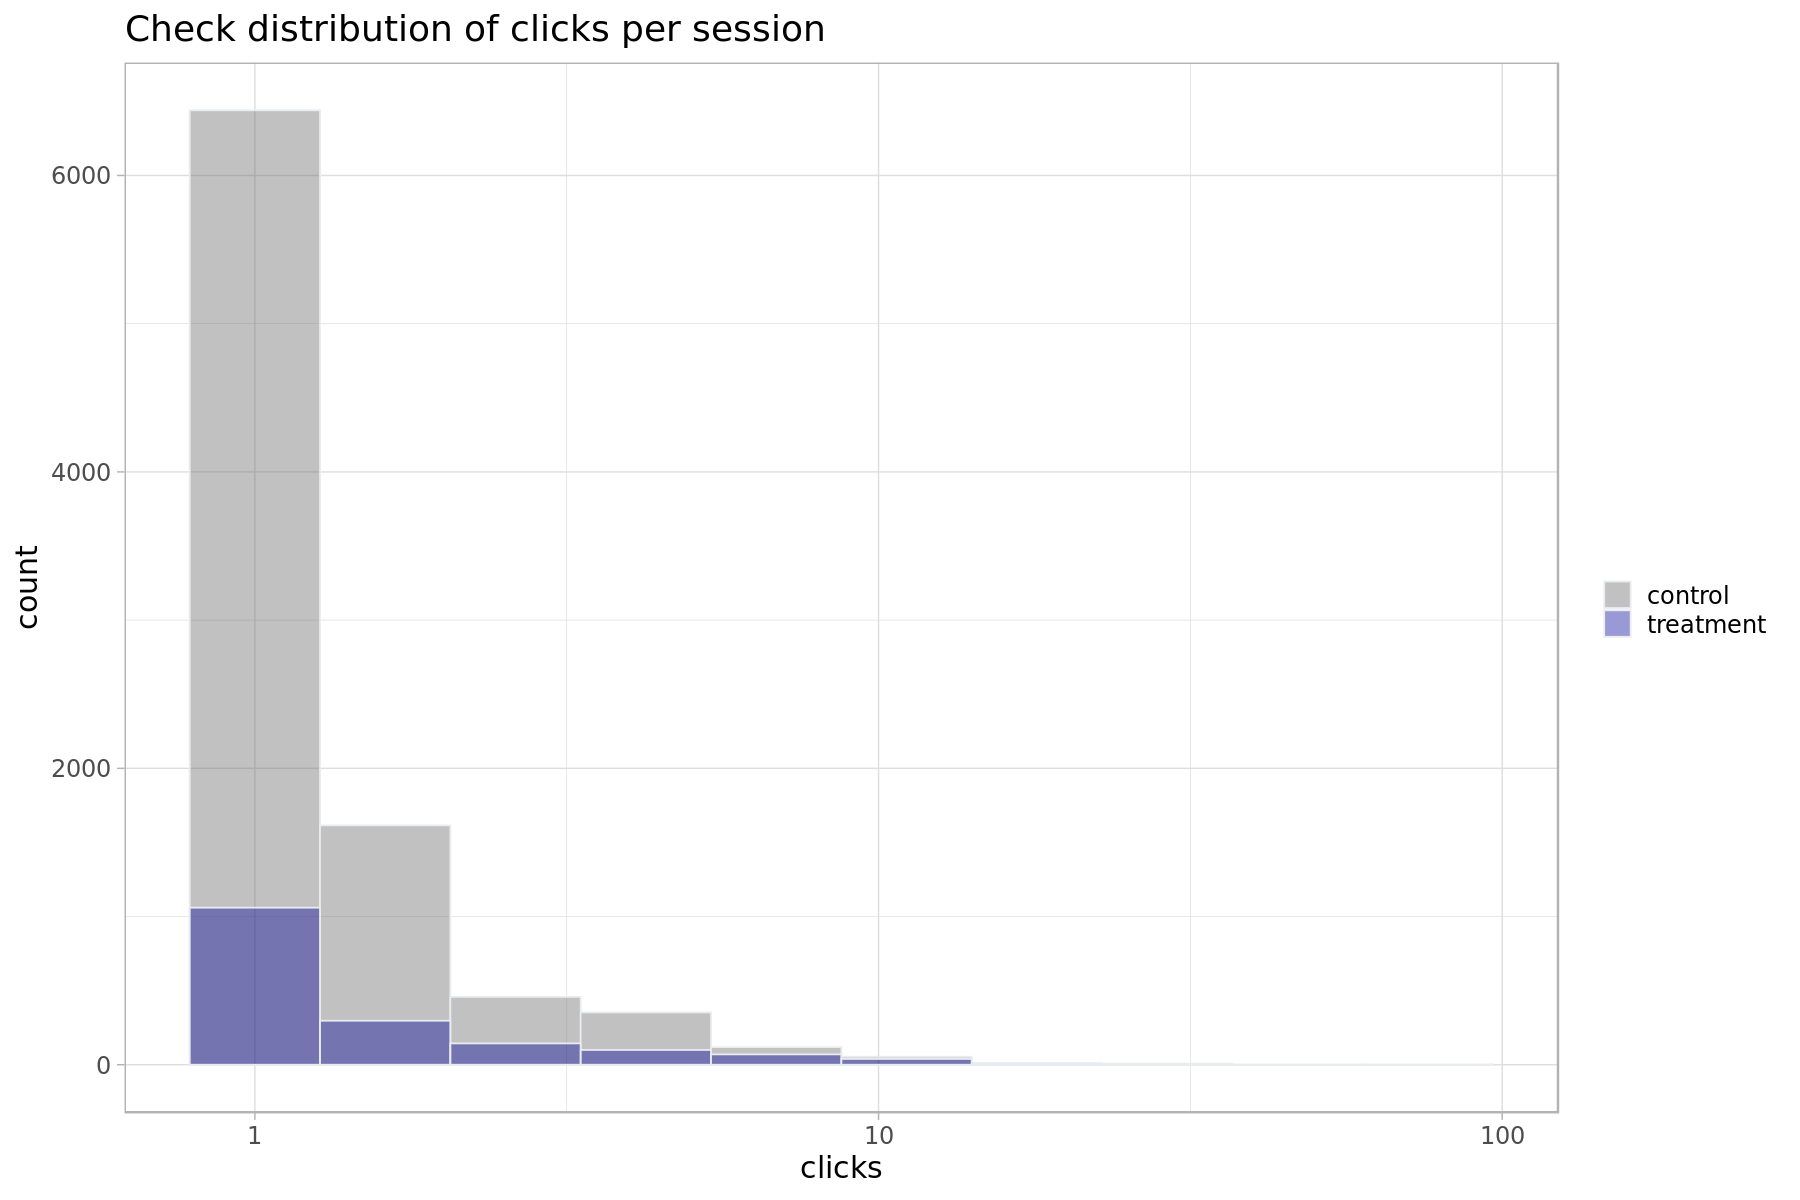

In [220]:
p2 <- df_click_session %>%
  filter(wiki!='foundationwiki') %>%
  filter(!(test_group=='control' & event_name=='ui.sidebar-toc') & !(test_group=='treatment' & event_name=='ui.toc')) %>%
  filter(isanon=='false') %>%
  ggplot( aes(x=clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=10) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of clicks per session",
         fill="") +
    theme_light(base_size=18)
p2

__Note:__   
Data shows in treatment group, some of sessions saw the old ToC, and some of sessions saw the new ToC, no matter the viewport size. For example on frwiki, in treatment group  more than half of the sessions with larger than 1000px viewport are assigned to old ToC.
In control group, few sessions (only 2) have this issue, which can be ingored. It leads to unblanced bucketing between control group and treatment group. 

With such a test group assignment, the AB test analysis on scrolls to ToC and reading time is invalid. Because schema mediawiki_web_ab_test_enrollment, mediawiki_reading_depth and mediawiki_web_ui_scroll do not record events on old ToC and new ToC seperated. The treatment group and control group can not be correctly categorized purely based on schema mediawiki_web_ab_test_enrollment. 

## Investigate sessions see both old ToC and new ToC in schema DesktopWebUIActionsTracking

In [224]:
query_ui_tracking <- "
SELECT event.token AS session_id, 
wiki, event.isanon,  event.viewportSizeBucket AS view_size,
COUNT(DISTINCT event.name) AS n_event_name
FROM event.DesktopWebUIActionsTracking 
WHERE wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND year=2022 and month IN (5,6)
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND event.name IN ( 'ui.toc', 'ui.sidebar-toc')
AND event.action='click' AND event.skinversion=2 
GROUP BY event.token, wiki, event.isanon,  event.viewportSizeBucket
HAVING n_event_name >1
"

In [225]:
df_check_ui_tracking <- wmfdata::query_hive(query_ui_tracking)

Don't forget to authenticate with Kerberos using kinit



In [247]:
query_1 <- "
SELECT `group`, wiki, meta.dt, substr(meta.dt, 1,19) as dt_sub
FROM event.mediawiki_web_ab_test_enrollment
WHERE  wiki='frwiki' 
AND year = 2022 AND month in (5, 6)
AND web_session_id='002708c8787bcbcce17c'
AND  experiment_name='skin-vector-toc-experiment'
ORDER BY dt_sub 
LIMIT 100
"

In [ ]:
df_1 <- wmfdata::query_hive(query_1)

Don't forget to authenticate with Kerberos using kinit



In [ ]:
df_1 

In [244]:
query_2 <- "
SELECT dt, event.action, event.name,event
FROM event.desktopwebuiactionstracking 
WHERE year = 2022 and month in (5, 6 ) AND event.action IN ('init' ,'click')
AND event.token='002708c8787bcbcce17c' 
AND wiki='frwiki' 
ORDER BY dt LIMIT 100000 
"


In [245]:
df_2 <- wmfdata::query_hive(query_2)

Don't forget to authenticate with Kerberos using kinit



__Code credit__

Mikhail Popov’s wmfdata: R package https://github.com/wikimedia/wmfdata-r  
Megan Neisler’s data visualization code in https://nbviewer.org/github/wikimedia-research/Desktop-Improvements-Search-Widget-Analysis-2021/blob/main/Search-widget-ab-test-report.ipynb